# Le but de ce notebook est d'identifier des caractéristiques très simples permettant d'analyser des battements de coeur de foetus

In [1]:
#pip install hyperopt

import os
import pandas as pd
import numpy as np
import copy

# permet de charger les fichiers matlab (*.mat)
from scipy.io import loadmat
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import PercentFormatter
from typing import List,Set,Tuple,Dict

# le répertoire de travail
directory = os.path.abspath('')

# répertoire où se trouvent toutes les données associés à ce challenge
data_directory = os.path.join(directory, 'Data')

# fichier CSV contenant les targets (1 / 0)
targets_path = os.path.join(data_directory, 'CTG_Challenge_files_GroundTruth.csv')

# répertoire où se trouvent les fichiers de données matlab
matlab_directory = os.path.join(data_directory, 'ctg_workshop_database')

# dans l'électrocardiogramme, nous avons 4 mesures par seconde
# chaque mesure correspondent à au nombre de battements de coeurs par minute
elements_en_1s = 4
elements_en_1minute = int(elements_en_1s*60)
elements_en_5minutes = 5*elements_en_1minute
elements_en_30minutes = 30*elements_en_1minute
elements_en_1heure = 60*elements_en_1minute

# retourne tous les fichiers matlab présents dans le repertoire 'path'
def all_mat_files_in_directory(path: str):
    return [os.path.join(path,f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith('.mat')]

# calcule la moyenne de la séquence ''fhr' en ignorant les NaN
def moyenne(fhr):
    return fhr[~np.isnan(fhr)].mean()

# calcule la std dev de la séquence ''fhr' en ignorant les NaN
def ecart_type(fhr):
    return fhr[~np.isnan(fhr)].std()

# calcul des 3 quartiles Q1 , Q2 (=mediane), Q3 (en ignorant les NaN)
def compute_quartiles_Q1_Q2_Q3(fhr) -> Tuple[float,float,float]:
    # Remove NaN values
    cleaned_data = fhr[~np.isnan(fhr)]
    Q1 = np.percentile(cleaned_data, 25)
    Q2 = np.percentile(cleaned_data, 50)  # This is the median
    Q3 = np.percentile(cleaned_data, 75)
    return Q1,Q2,Q3

# nombre d elements NaN dans la séquence 'fhr'
def nan_count(fhr):
    return np.count_nonzero(np.isnan(fhr))



# PRIVE: Chargement des données d'entraînement

In [2]:
# chemin vers tous les fichiers matlab de la base d'entraînement
id_to_path = dict()
for filename in all_mat_files_in_directory(matlab_directory):
    filename_without_extension = os.path.splitext(os.path.basename(filename))[0]    
    id = int(filename_without_extension.lstrip('0'))
    id_to_path[id] = filename

# on charge les targets associés à chaque fichier d'entraînement
targets_df = pd.read_csv(targets_path)
id_to_target = dict()
for _, row in targets_df.iterrows():
    id_to_target[row['ChallengeID']] = row['TrueOutcome']

# lecture des battements de coeurs des foetus
id_to_fhr_full = dict()
id_to_fhr_last_hour = dict() #uniquement la dernière heure
all_lengths = []
for id, path in id_to_path.items():
    matlab_file = loadmat(path)
    id_to_fhr_full[id] = matlab_file['fhr'].flatten()
    id_to_fhr_last_hour[id] = copy.copy(id_to_fhr_full[id][-60*4*60:])


# PRIVE: Calcul de statistiques sur ces données d'entraînement
## (pour faciliter la recherche des caractéristiques)

In [3]:
ids = []
targets = []
mean_full = []
std_dev_full = []
count_full = []
nan_count_full = []
Q1_full = []
Q2_full = []
Q3_full = []
interquartile_range_full = []

mean_last_hour = []
std_dev_last_hour = []
count_last_hour = []
nan_count_last_hour = []
Q1_last_hour = []
Q2_last_hour = []
Q3_last_hour = []
interquartile_range_last_hour = []

for id in list(id_to_path.keys()):
    ids.append(id)
    targets.append(id_to_target[id])
    
    fhr_full = id_to_fhr_full[id]
    
    mean_full.append(moyenne(fhr_full))
    std_dev_full.append(ecart_type(fhr_full)) 
    count_full.append(fhr_full.size)
    nan_count_full.append(nan_count(fhr_full))
    (Q1,Q2,Q3) = compute_quartiles_Q1_Q2_Q3(fhr_full)
    Q1_full.append(Q1)
    Q2_full.append(Q2)
    Q3_full.append(Q3)
    interquartile_range_full.append(Q3-Q1)
    
    fhr_last_hour = id_to_fhr_last_hour[id]
    mean_last_hour.append(moyenne(fhr_last_hour))
    std_dev_last_hour.append(ecart_type(fhr_last_hour)) 
    count_last_hour.append(fhr_last_hour.size)
    nan_count_last_hour.append(nan_count(fhr_last_hour))
    (Q1,Q2,Q3) = compute_quartiles_Q1_Q2_Q3(fhr_last_hour)
    Q1_last_hour.append(Q1)
    Q2_last_hour.append(Q2)
    Q3_last_hour.append(Q3)
    interquartile_range_last_hour.append(Q3-Q1)

    
# Sauvegarde de ces statistiques dans un DataFrame
fhr_stats = pd.DataFrame(
    {'ids': ids,
    'targets': targets,
    'mean_full' : mean_full,
    'std_dev_full' : std_dev_full,
    'count_full' : count_full,
    'nan_count_full' : nan_count_full,
    'Q1_full' : Q1_full,
    'Q2_full' : Q2_full,
    'Q3_full' : Q3_full,
    'interquartile_range_full' : interquartile_range_full,
    'mean_last_hour' : mean_last_hour,
    'std_dev_last_hour' : std_dev_last_hour,
    'count_last_hour' : count_last_hour,
    'nan_count_last_hour' : nan_count_last_hour,
    'Q1_last_hour' : Q1_last_hour,
    'Q2_last_hour' : Q2_last_hour,
    'Q3_last_hour' : Q3_last_hour,
    'interquartile_range_last_hour' : interquartile_range_last_hour,
    })

# on sauvegarde ces stats sur le disque
fhr_stats.to_csv(os.path.join(directory, 'fhr_stats.csv'), index=False)    

# PRIVE: méthodes permettant l'affichage d'électrocardiogrammes et d'histogrammes

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import copy

def interpolate_nans(array):
    not_nan = ~np.isnan(array)
    indices = np.arange(len(array))
    interpolated_array = np.copy(array)
    interpolated_array[np.isnan(array)] = np.interp(indices[np.isnan(array)], indices[not_nan], array[not_nan])
    return interpolated_array

def display_electrocardiogram(id: int, start_minut:float, duration_in_minuts: float, display_mean: bool = True, interpolate_missing_values:bool = True, min_y_value: int = None, max_y_value: int = None):
    fhr_full = loadmat(id_to_path[id])['fhr'].ravel()
    start_idx = int(start_minut*4*60)
    if start_idx<0: 
        start_idx+=len(fhr_full)
    start_idx = max(0, start_idx-1)
    end_idx = min( start_idx+1+int(duration_in_minuts*4*60) , len(fhr_full) )
    
    fhr = fhr_full[start_idx:end_idx]
    if interpolate_missing_values:
        fhr = interpolate_nans(fhr)
    
    # nombre d'éléments dans l'électrocardiogramme
    n = len(fhr)
    
    # Create an array of time points (assuming each heart rate measurement is taken at regular intervals)
    time_in_minuts = np.arange(n)/(60*4)
    # Plot the heart rate data
    plt.figure(figsize=(20, 10))
    plt.plot(time_in_minuts, fhr, linestyle='-', color='black', linewidth=1)
    # Formater les ticks pour afficher le temps au format hh:mm
    def format_func(time_in_minuts, tick_number):
        #time_in_minuts = int(time_in_minuts/(60*4))
        hours = int(time_in_minuts) // 60
        minutes = int(time_in_minuts) % 60
        return f'{hours:02d}:{minutes:02d}'
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    comment = 'sujet sain' if id_to_target[id] == 0 else 'sujet malade'
    
    if display_mean:
        observed_mean = int(moyenne(fhr))
        plt.axhline(y=observed_mean, color='red', linewidth=1, linestyle='-', label='Moyenne: '+str(observed_mean))
        # Annotate the y-value on the vertical axis
        plt.text(x=0, y=observed_mean, s=f'{observed_mean:.0f}', color='red', va='center', ha='right')

    # Add labels and title
    plt.xlabel('Temps (minutes)', fontsize=15)
    plt.ylabel('Battements de coeur par minutes', fontsize=15)
    plt.title(f"Electrocardiogramme pour un {comment} ({id})", fontsize=15)
    plt.xlim(0, max(time_in_minuts))
    plt.ylim(min_y_value or 60, max_y_value or 180)
    # Display grid
    plt.grid(True)

    if display_mean:
        plt.legend()
    # Show the plot
    plt.show()


def display_histogram(id: int, start_minut:float, duration_in_minuts: float, display_mean: bool = True):
    fhr_full = loadmat(id_to_path[id])['fhr'].ravel()
    start_idx = int(start_minut*4*60)
    if start_idx<0: 
        start_idx+=len(fhr_full)
    start_idx = max(0, start_idx-1)
    end_idx = min( start_idx+1+int(duration_in_minuts*4*60) , len(fhr_full) )
    data = fhr_full[start_idx:end_idx]
    # we discard NaN
    data = data[~np.isnan(data)] 
    plt.figure(figsize=(16, 6))  # Increase the width for better horizontal display
    # Plotting the histogram
    counts, bins, patches = plt.hist(data, bins=30, edgecolor='black', weights=[100/len(data)]*len(data))
    
    # Adding title and labels
    comment = 'sujet sain' if id_to_target[id] == 0 else 'sujet malade'

    plt.title("Histogramme")
    plt.xlabel('Nombre de battements de coeur à la minute')
    plt.ylabel('Fréquence (%)')

    if display_mean:
        observed_mean = int(moyenne(data))
        plt.axvline(observed_mean, color='red', linestyle='-', linewidth=2)
        plt.text(observed_mean, plt.ylim()[1]*0.9, f'Moyenne: {observed_mean:.2f}', color='red', ha='center')
    
    # Display the plot
    plt.show()


def display_electrocardiograms(count:int, start_minut:int, duration_in_minuts: int, label: int, start_id:int = 1, display_mean: bool = True, interpolate_missing_values:bool = True, min_y_value: int = None, max_y_value: int = None):
    displayed_count = 0
    for idx in range(start_id, start_id+300,1):
        id = idx if idx <=300 else idx-300
        if id_to_target[id] != label:
            continue
        display_electrocardiogram(id, start_minut, duration_in_minuts, display_mean=display_mean, interpolate_missing_values=interpolate_missing_values, min_y_value=min_y_value, max_y_value=max_y_value)
        display_histogram(id, start_minut, duration_in_minuts, display_mean=display_mean)
        displayed_count+= 1
        if displayed_count>=count:
            break

# Affichage d'exemples de données pour des sujets sains

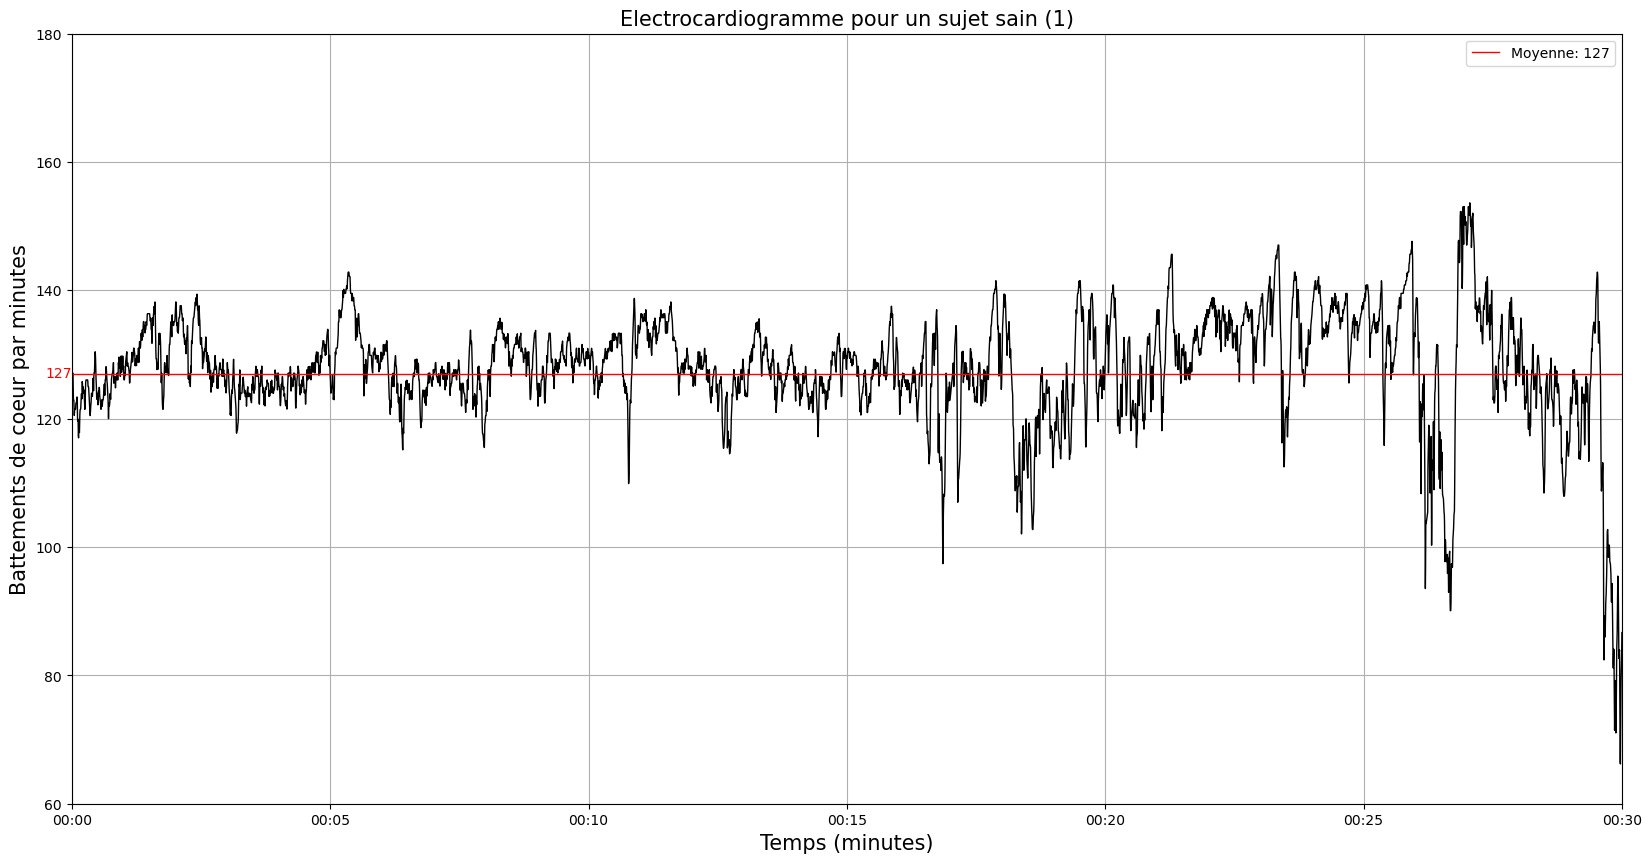

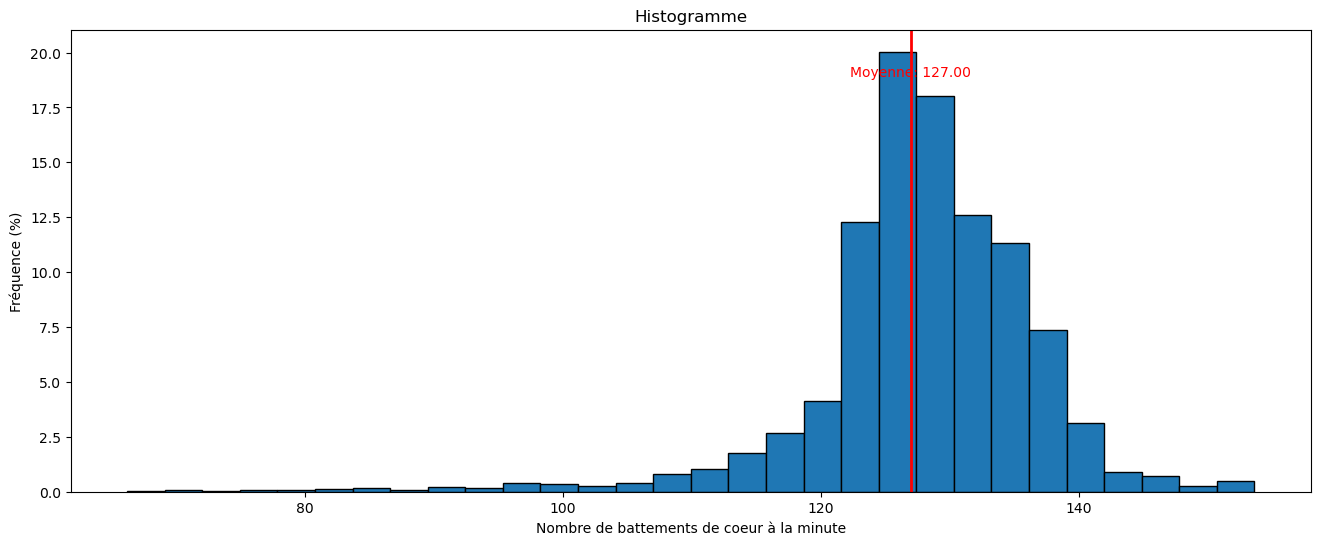

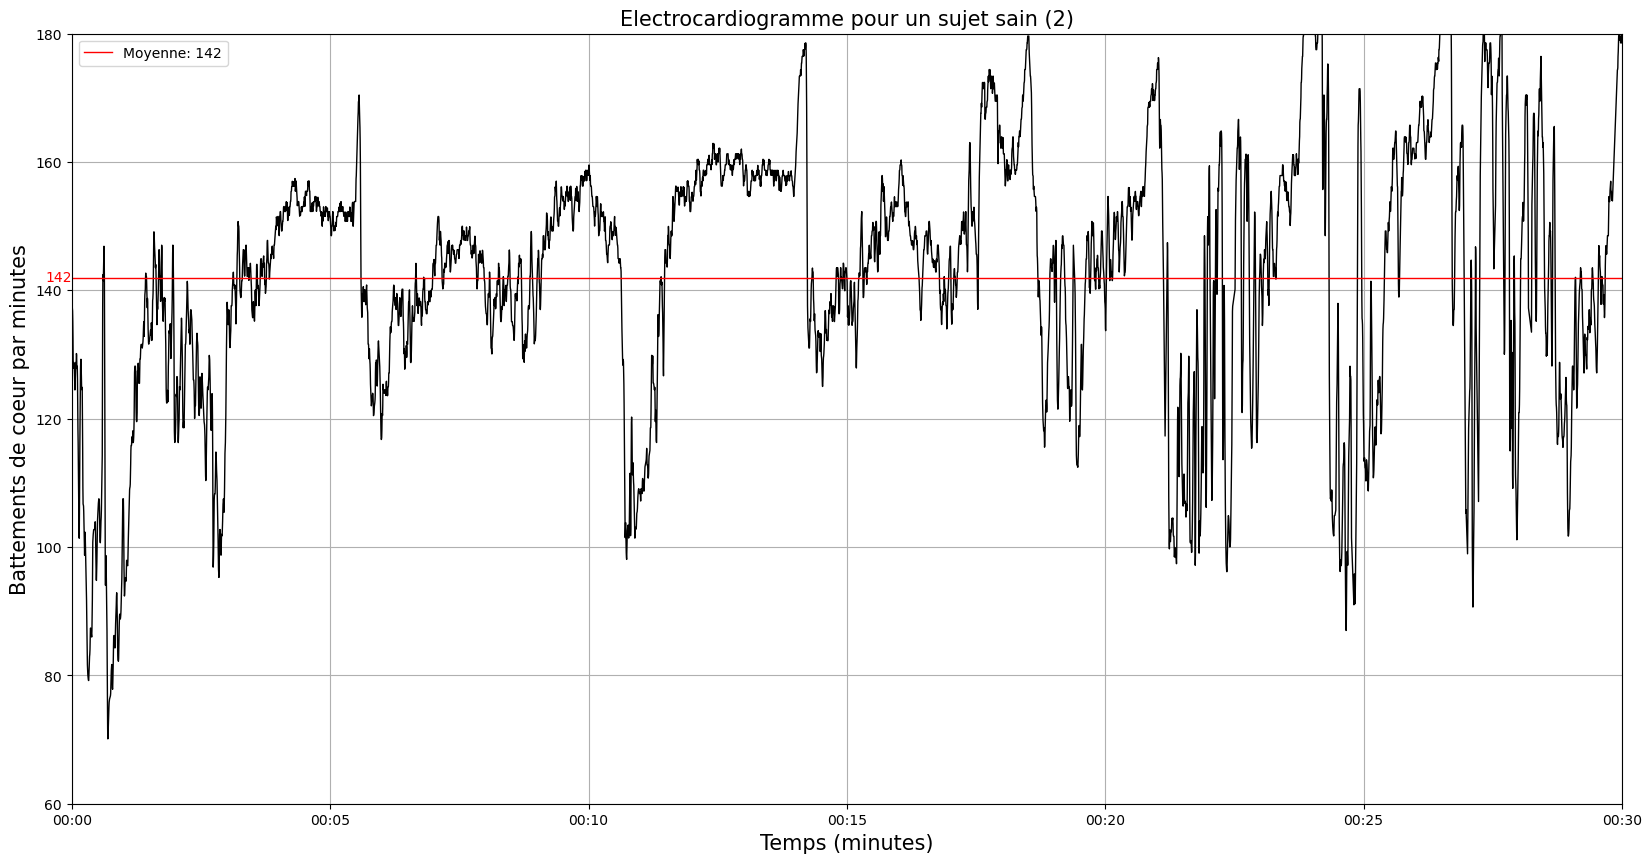

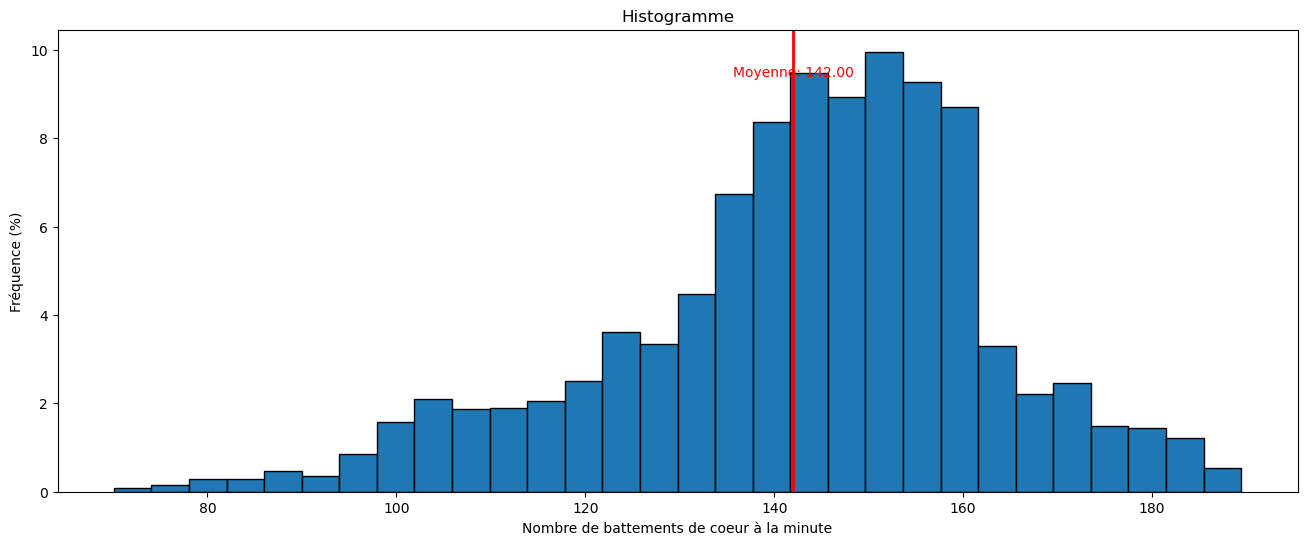

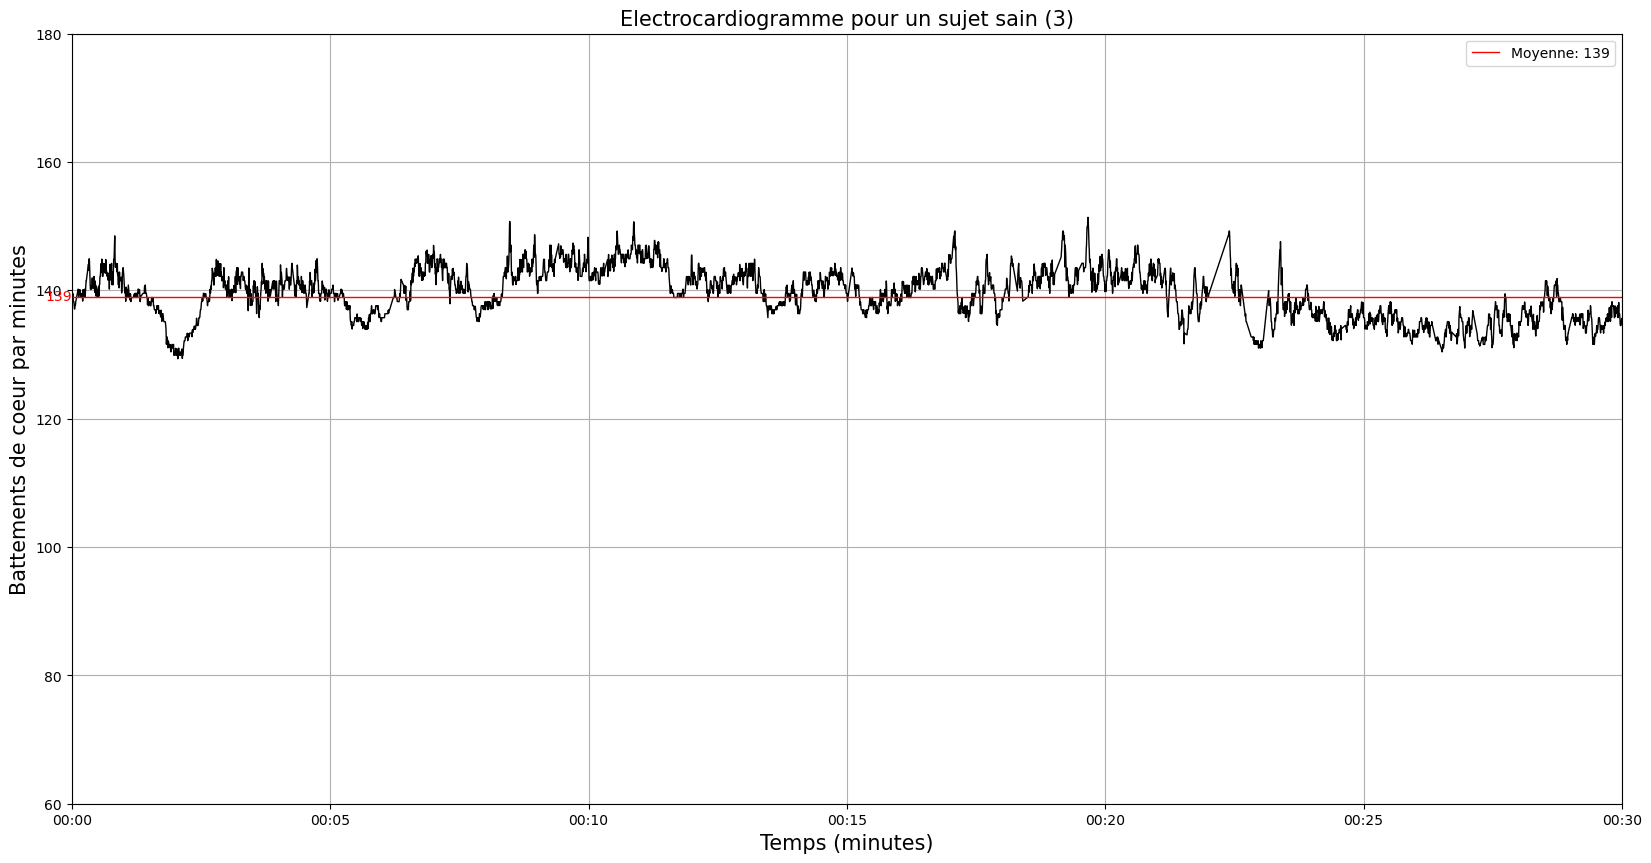

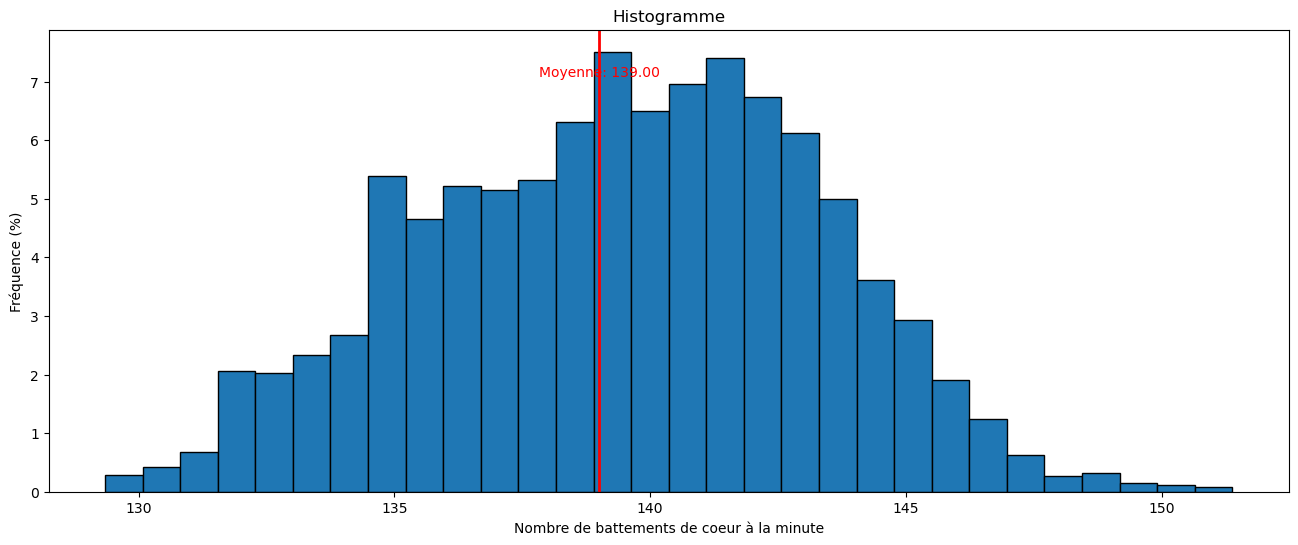

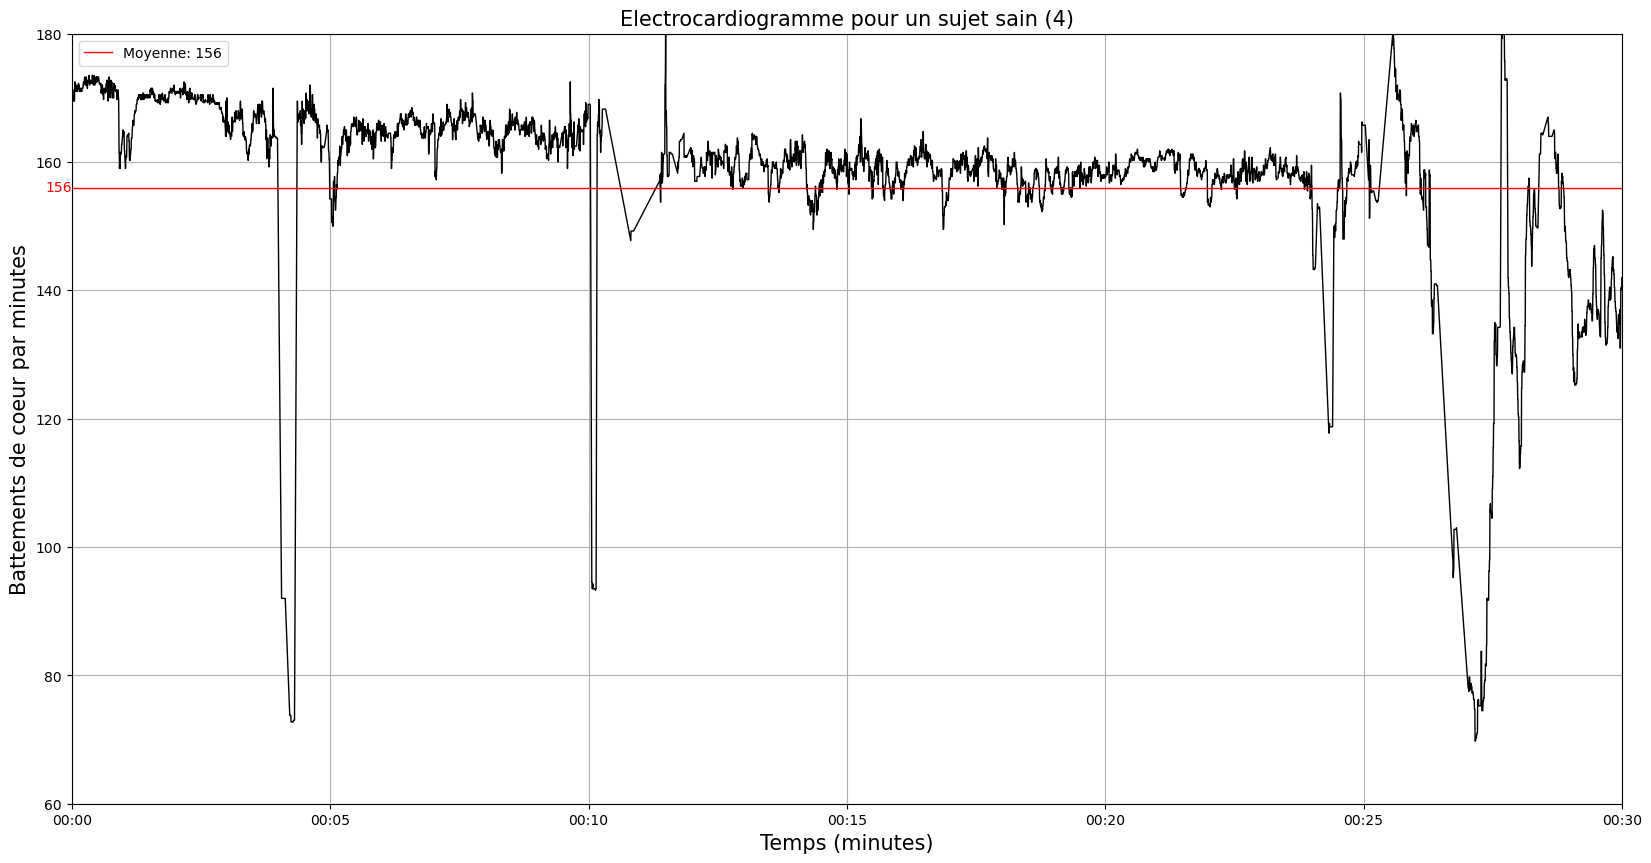

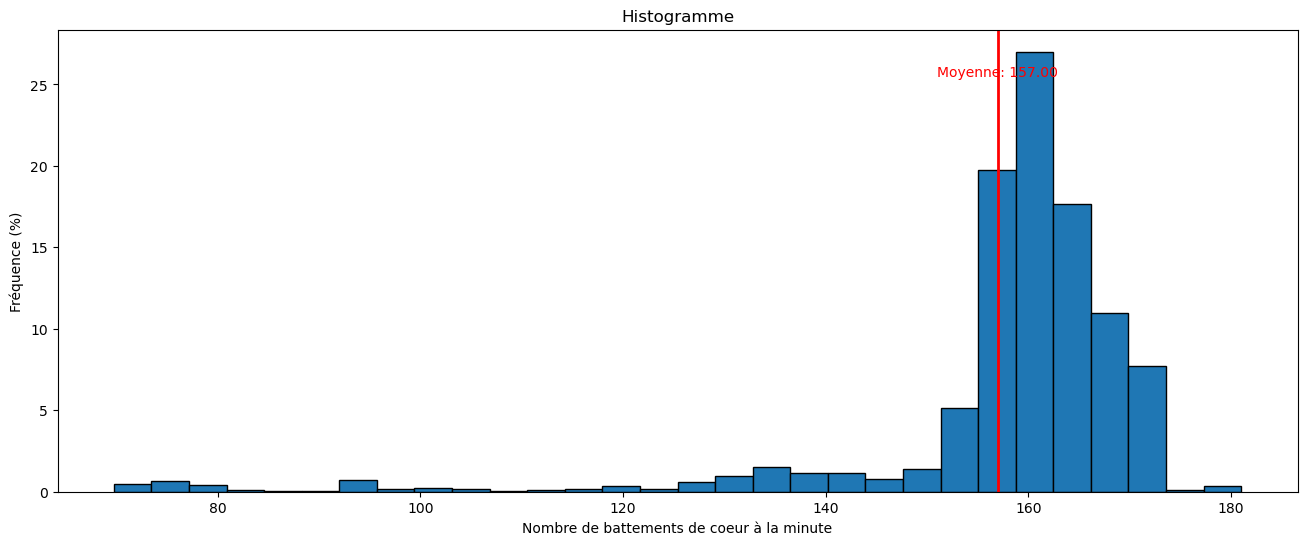

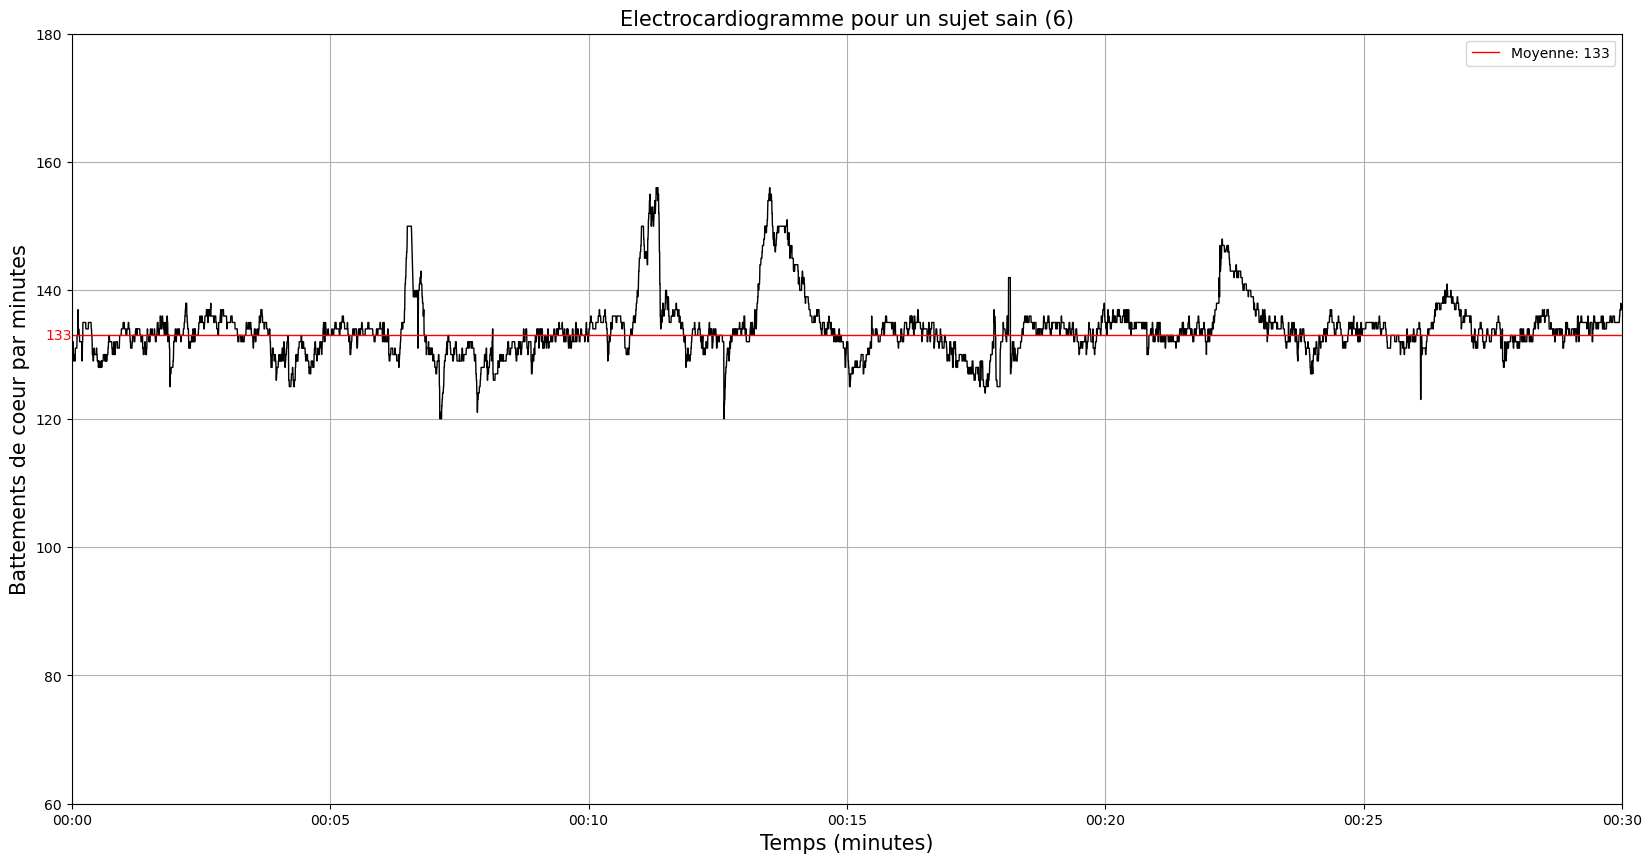

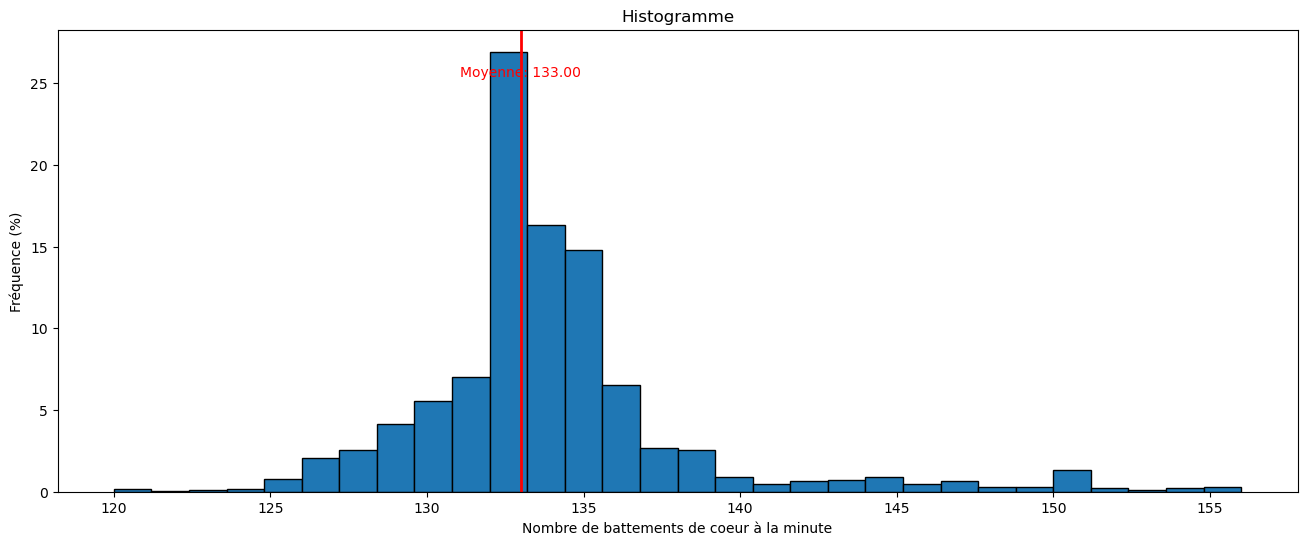

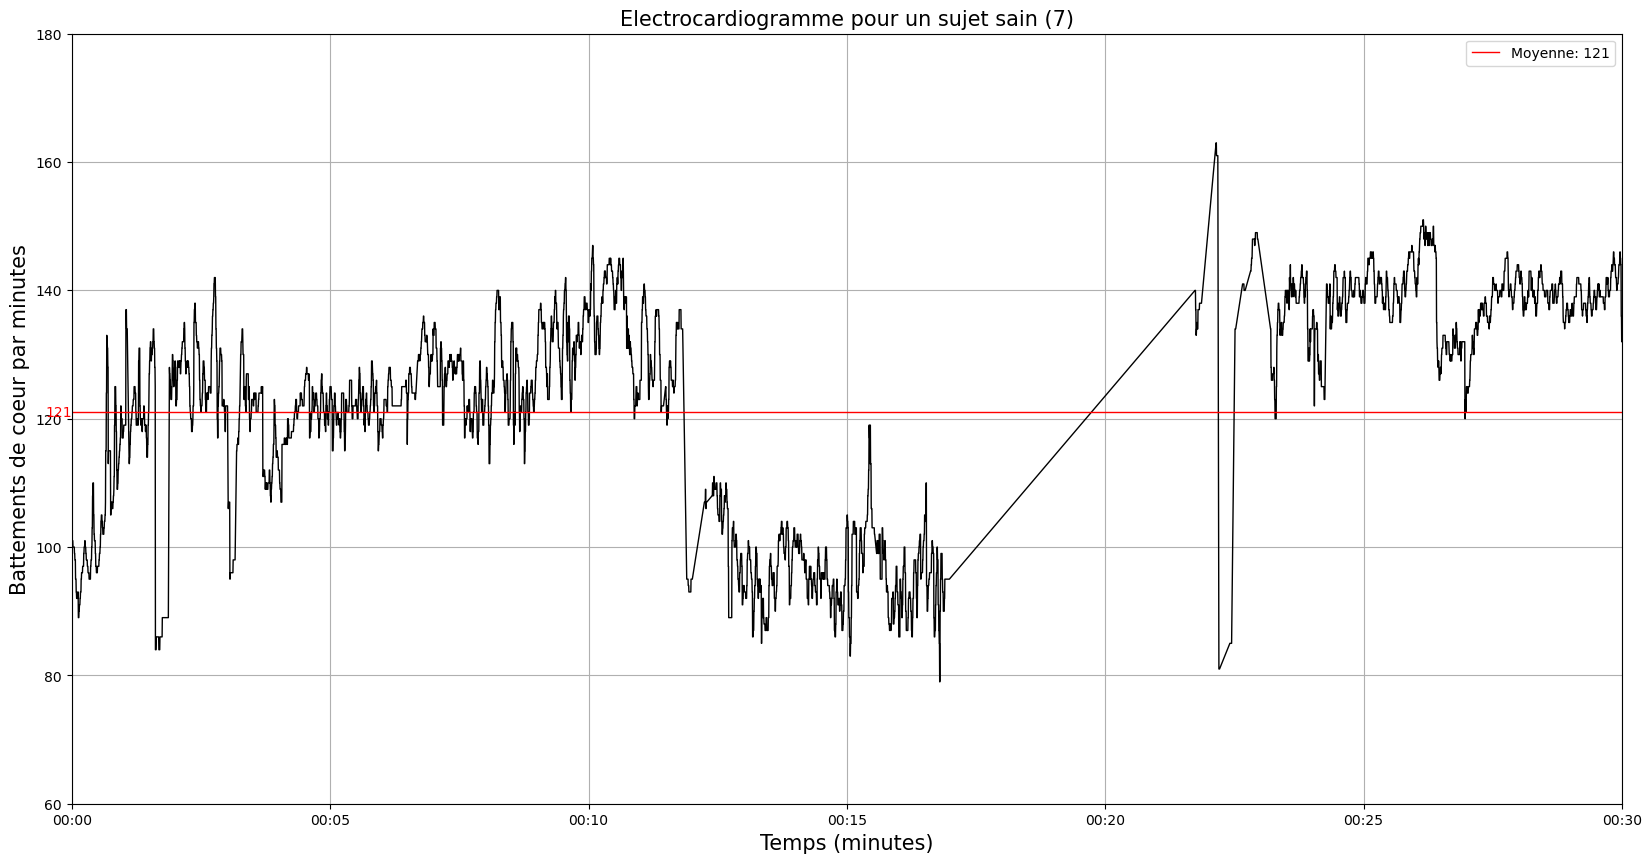

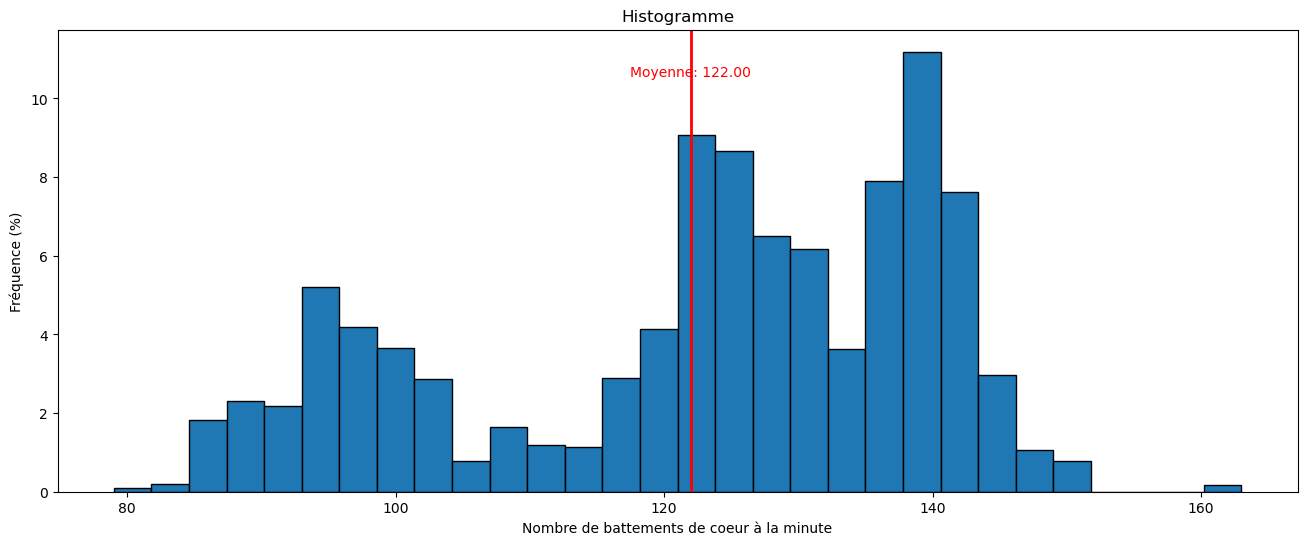

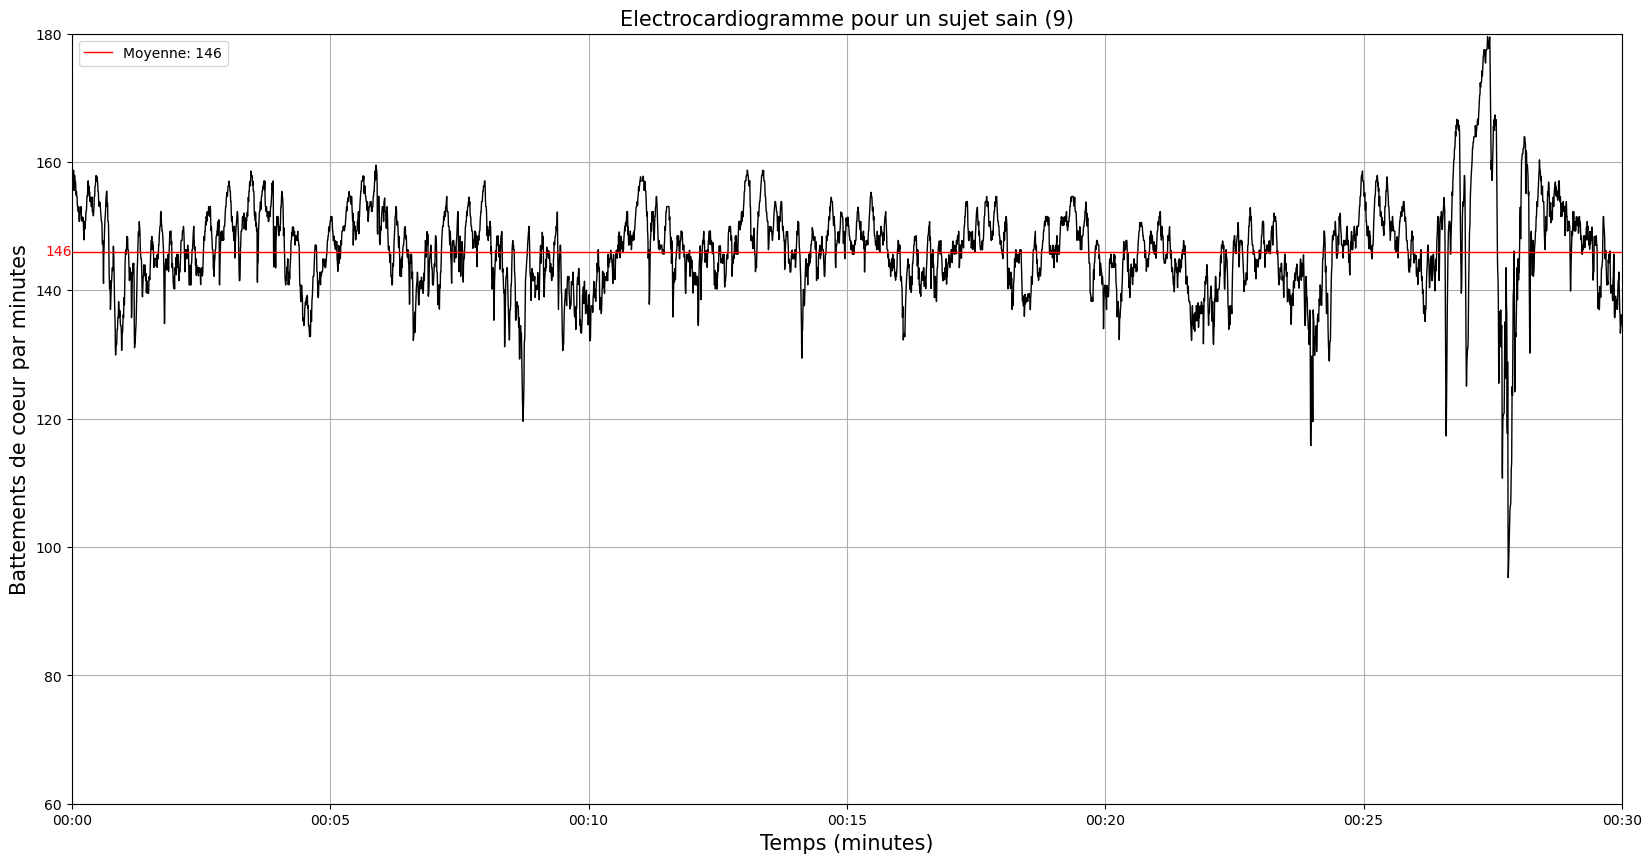

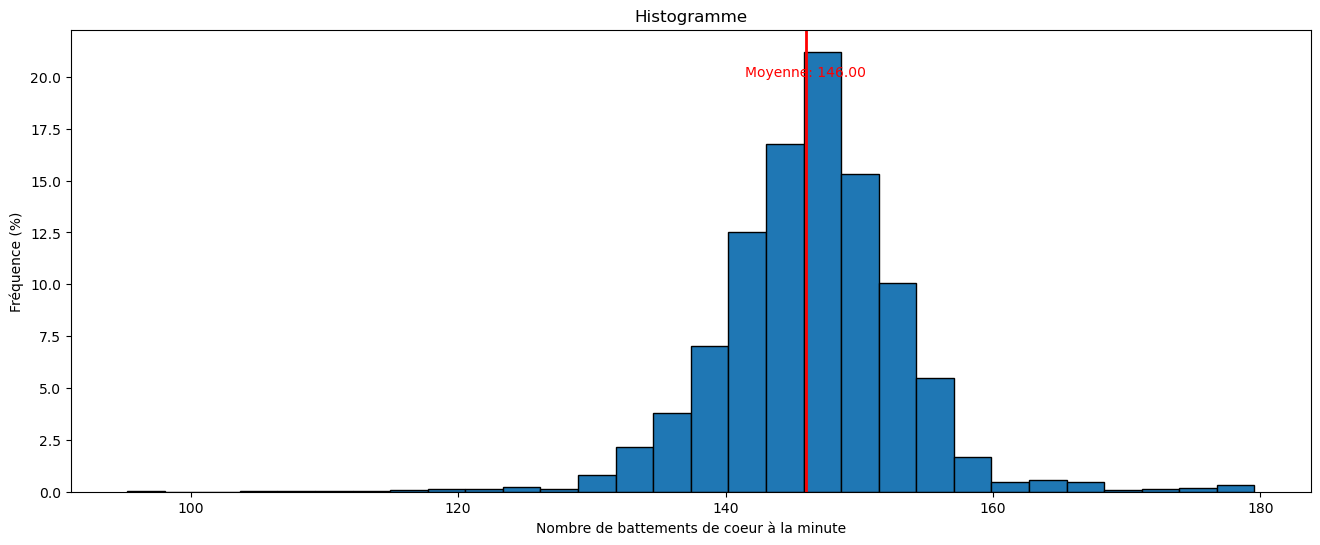

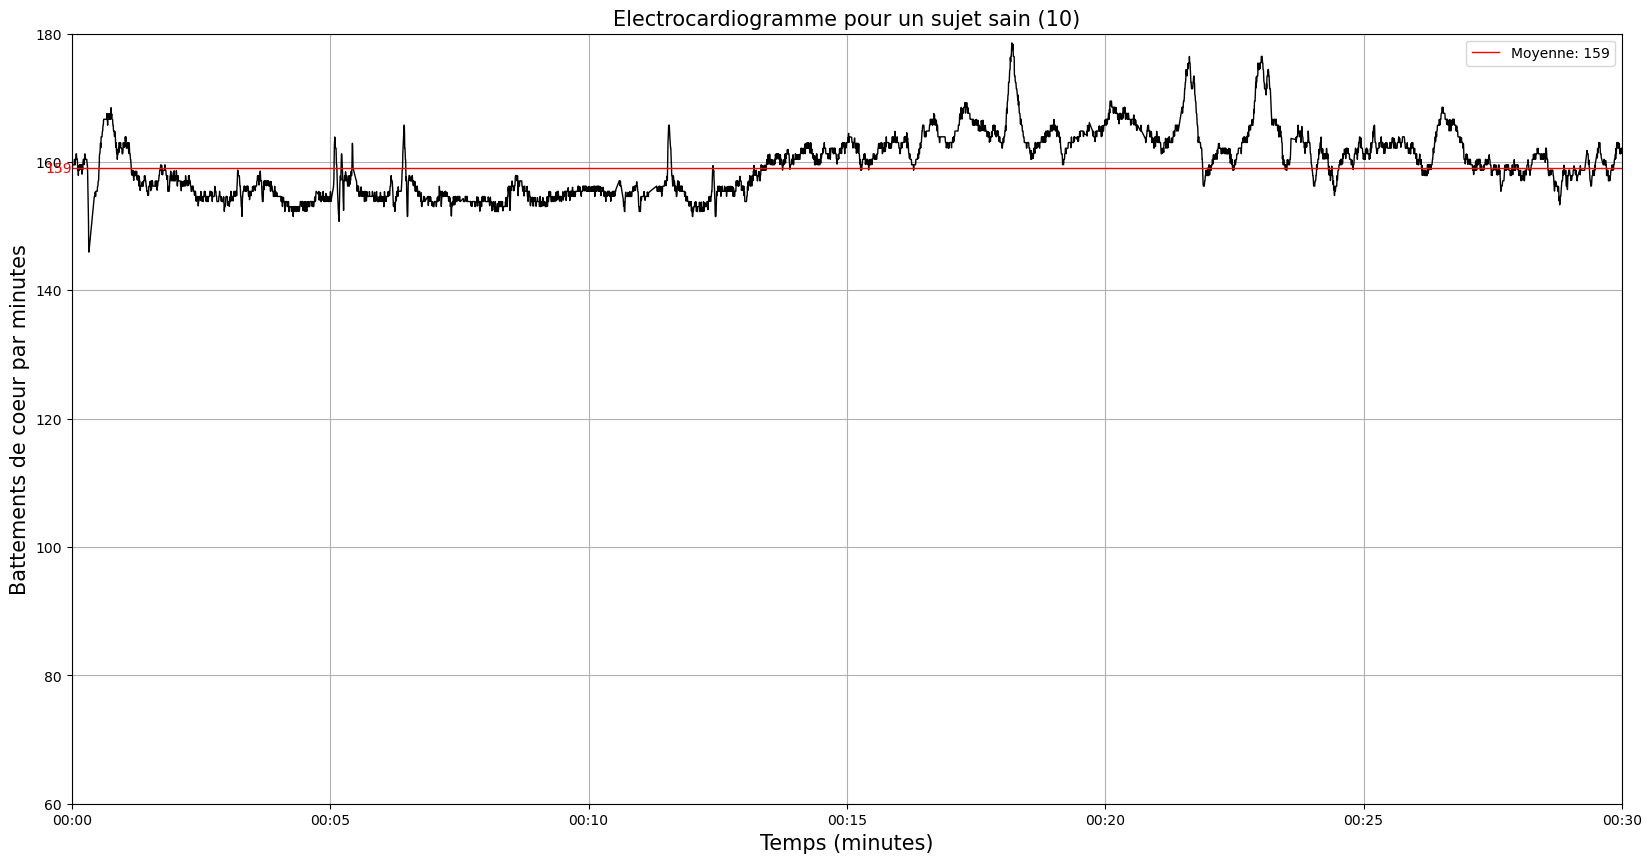

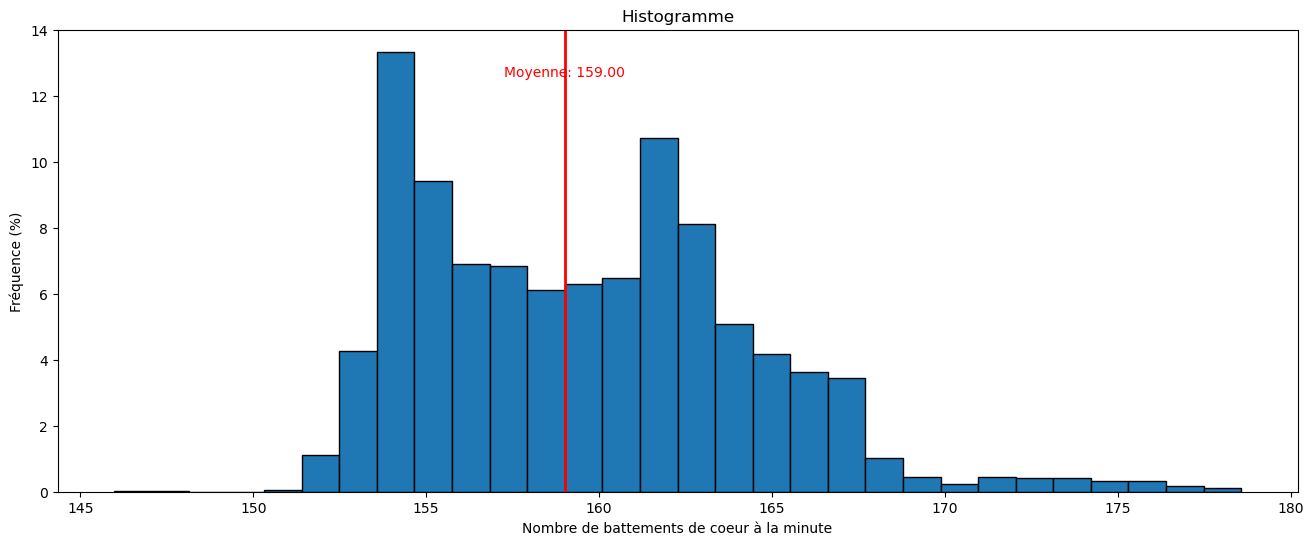

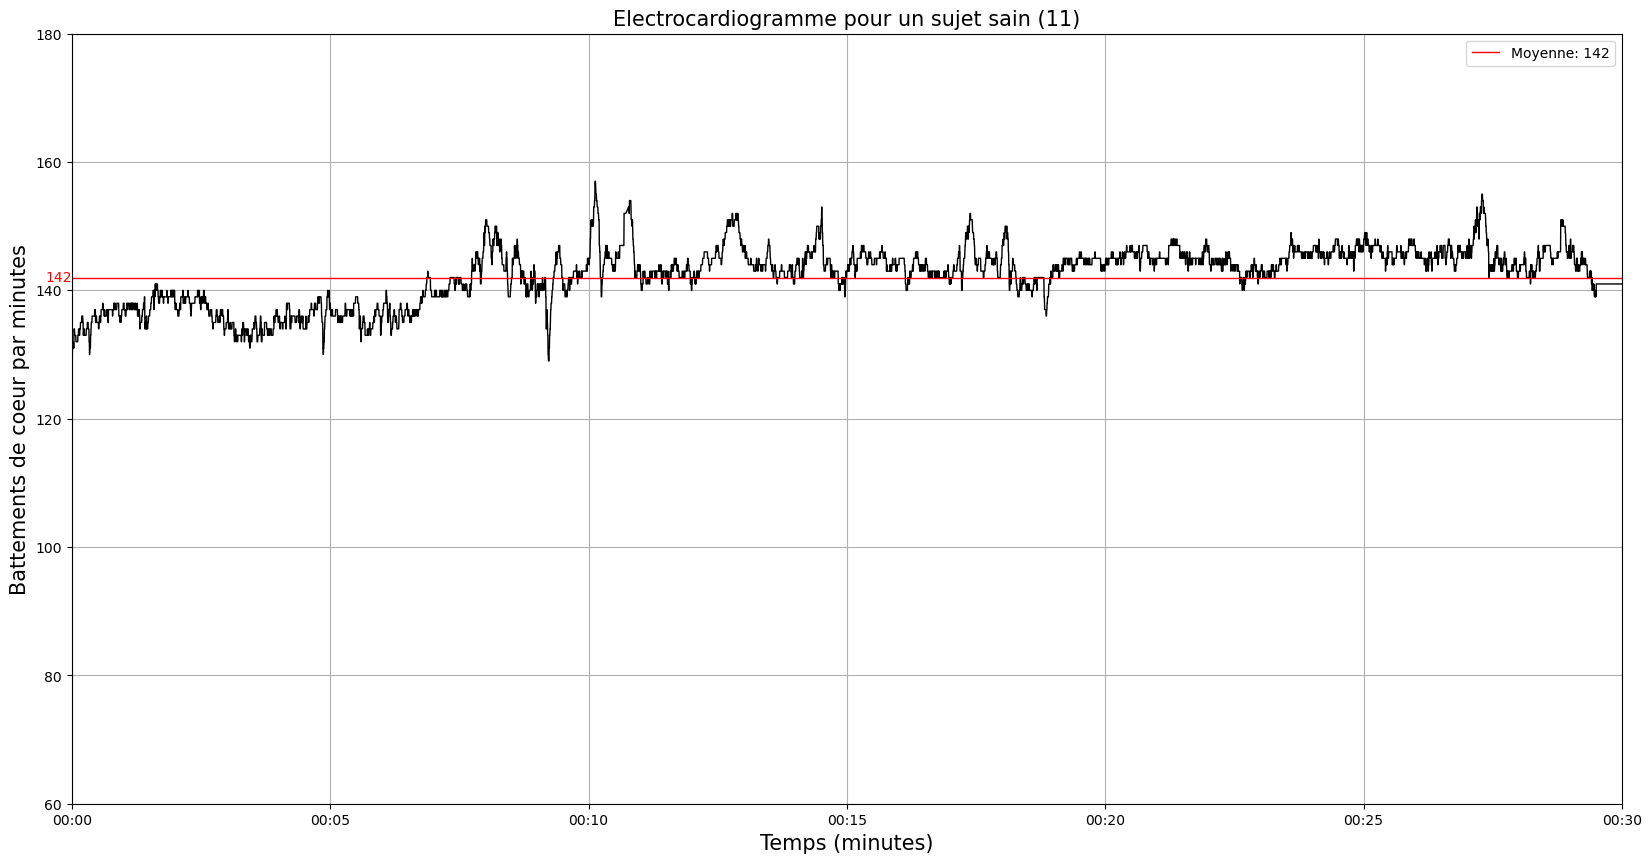

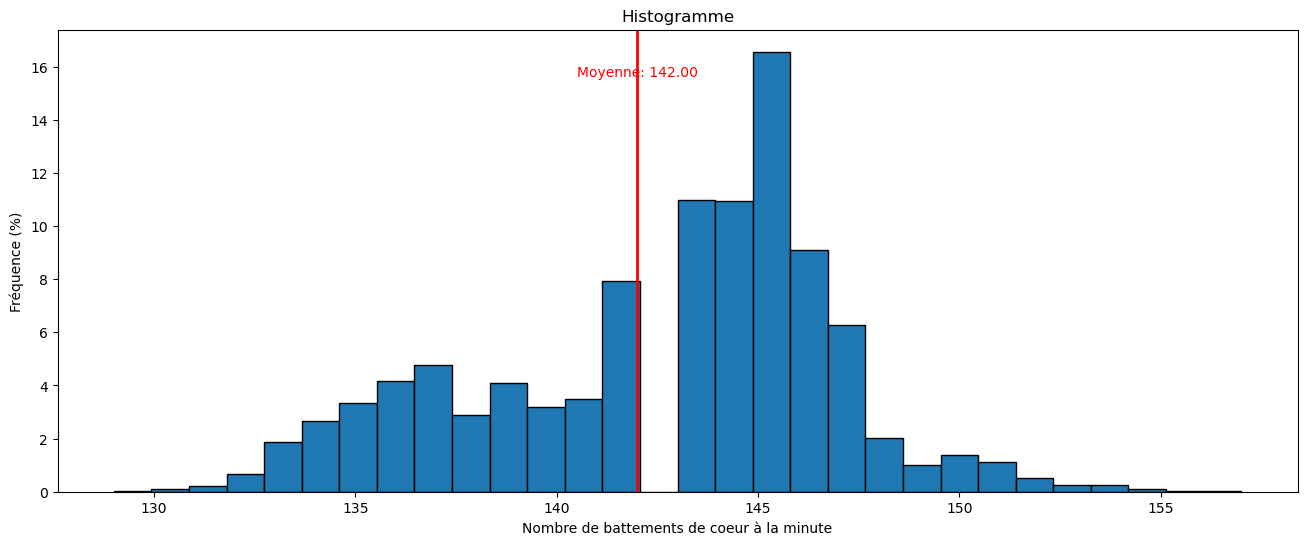

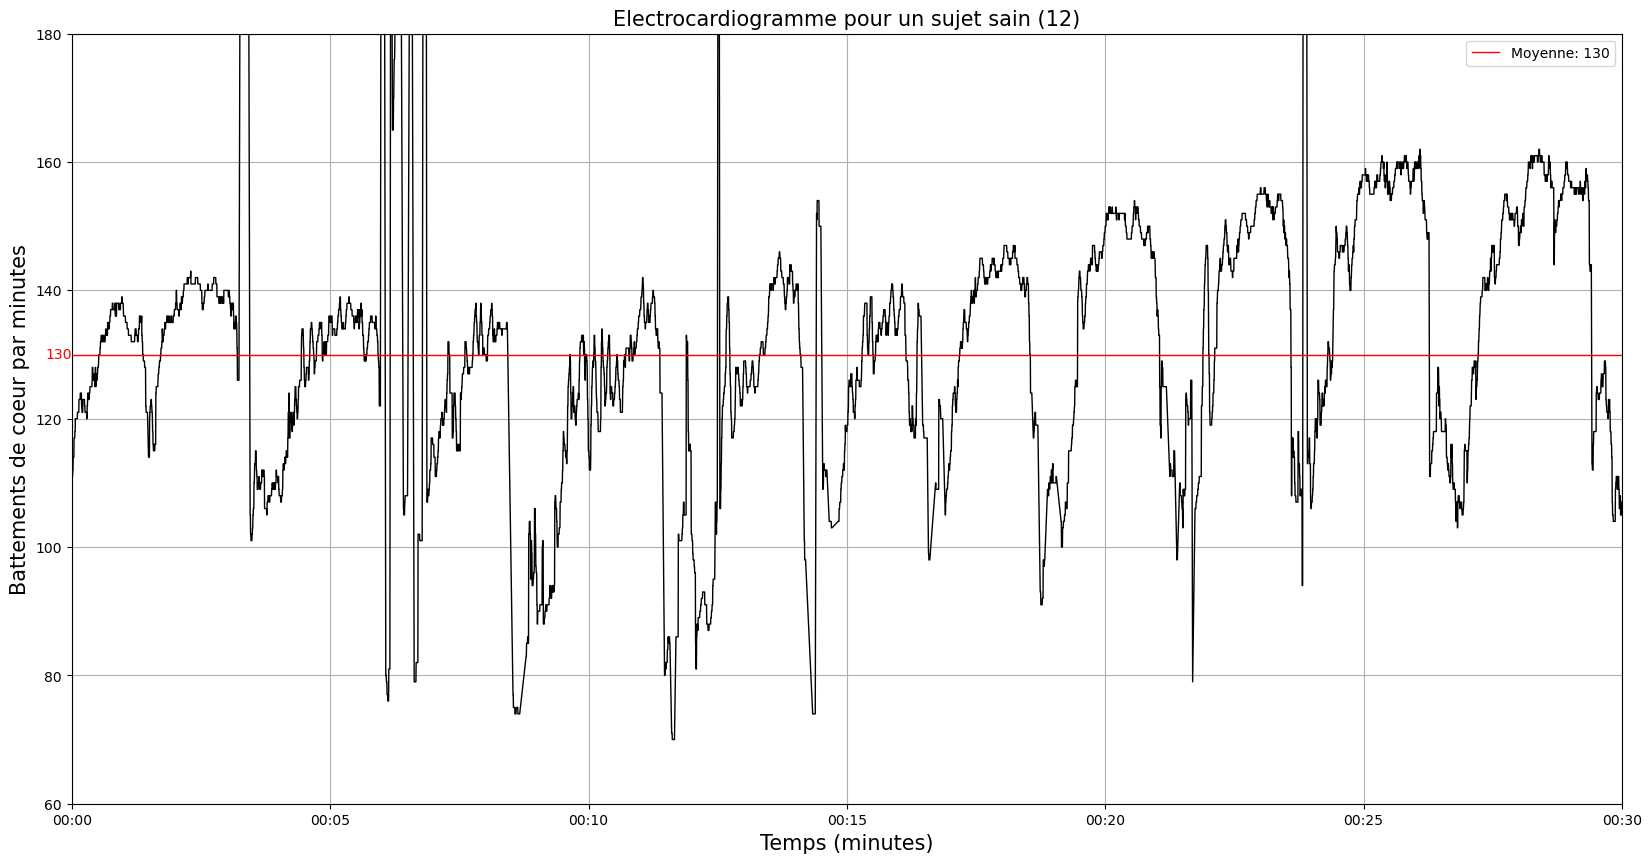

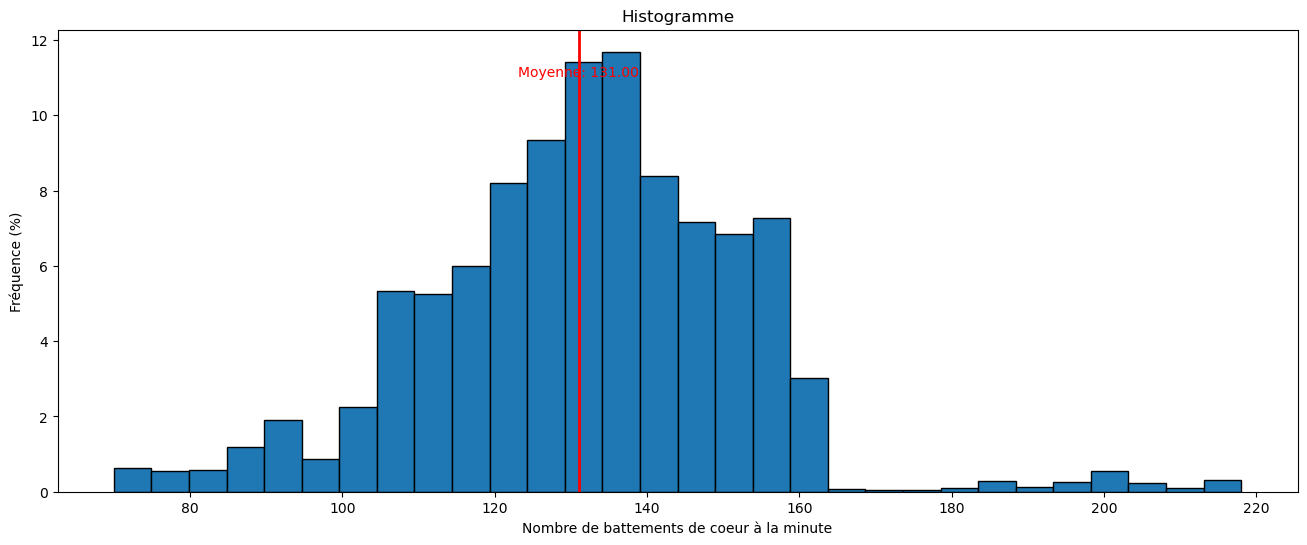

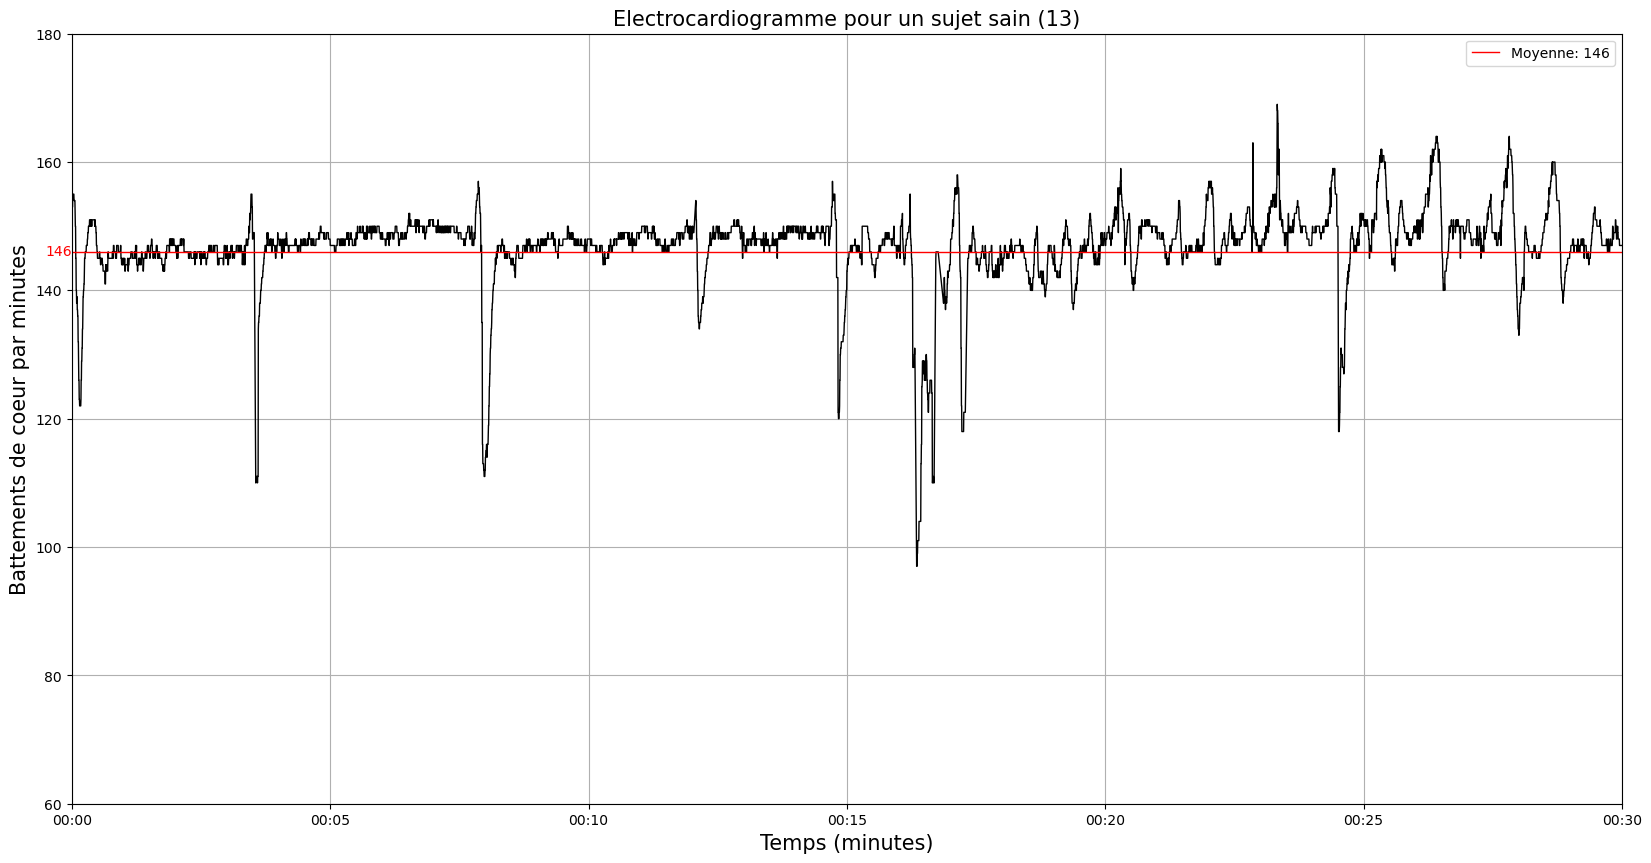

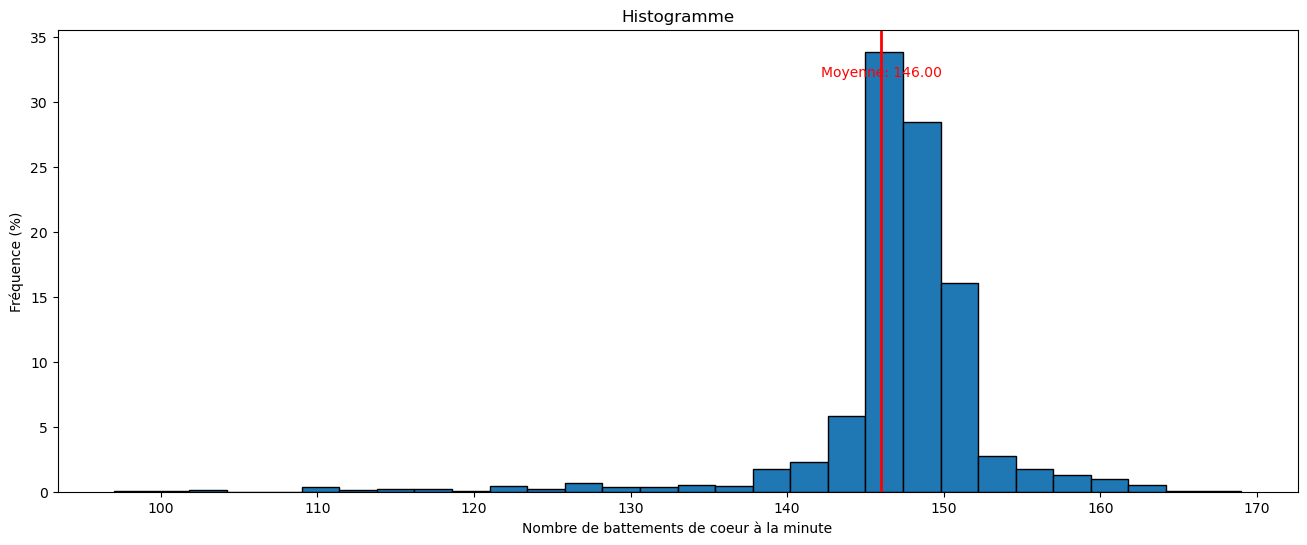

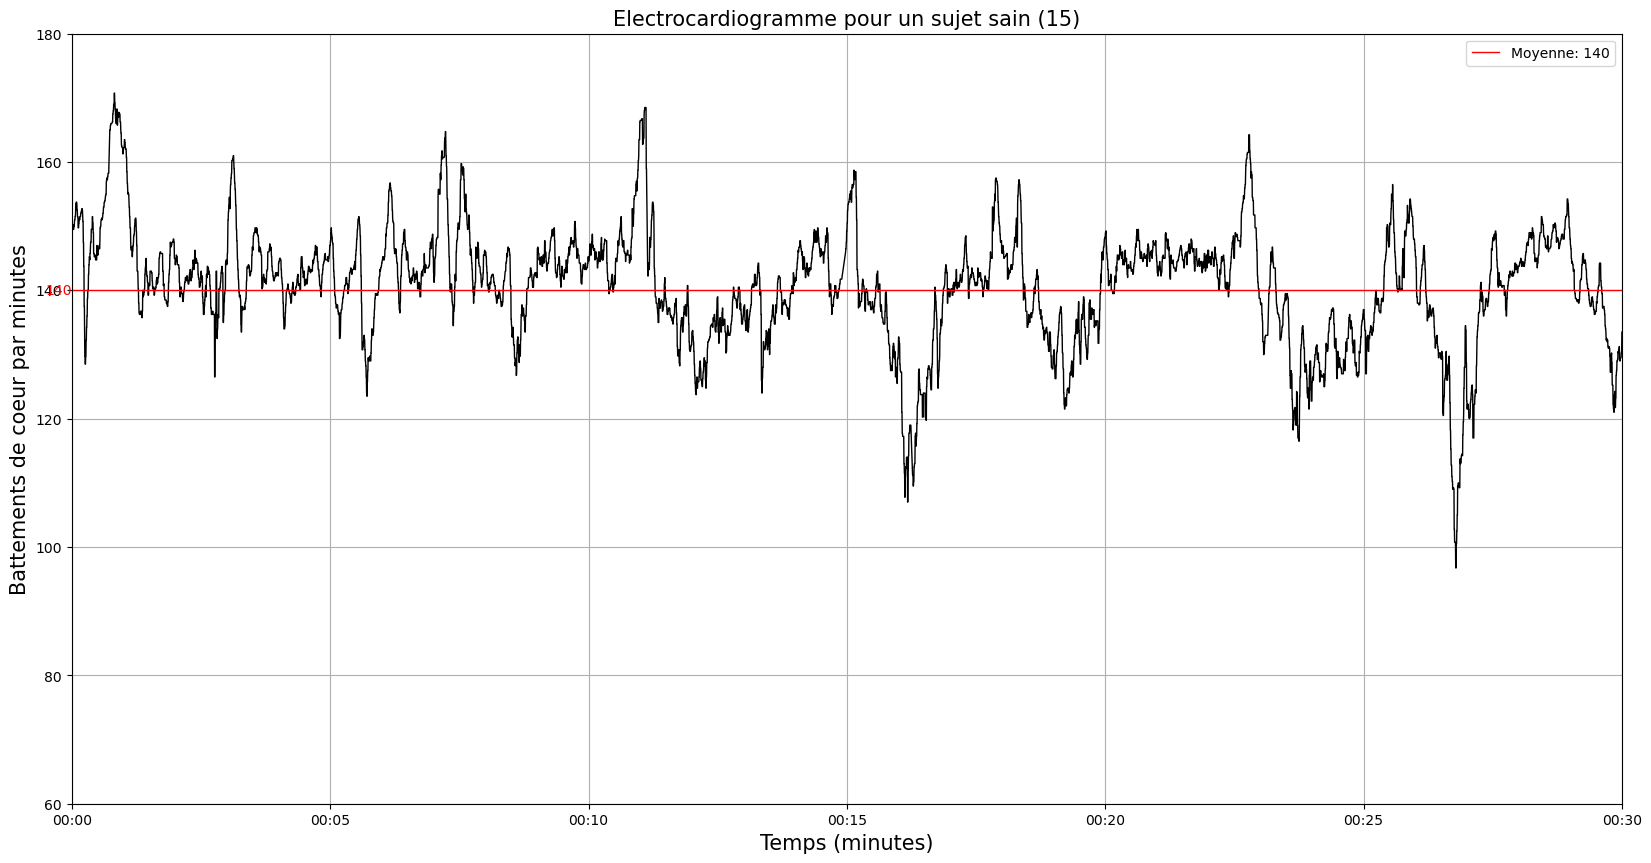

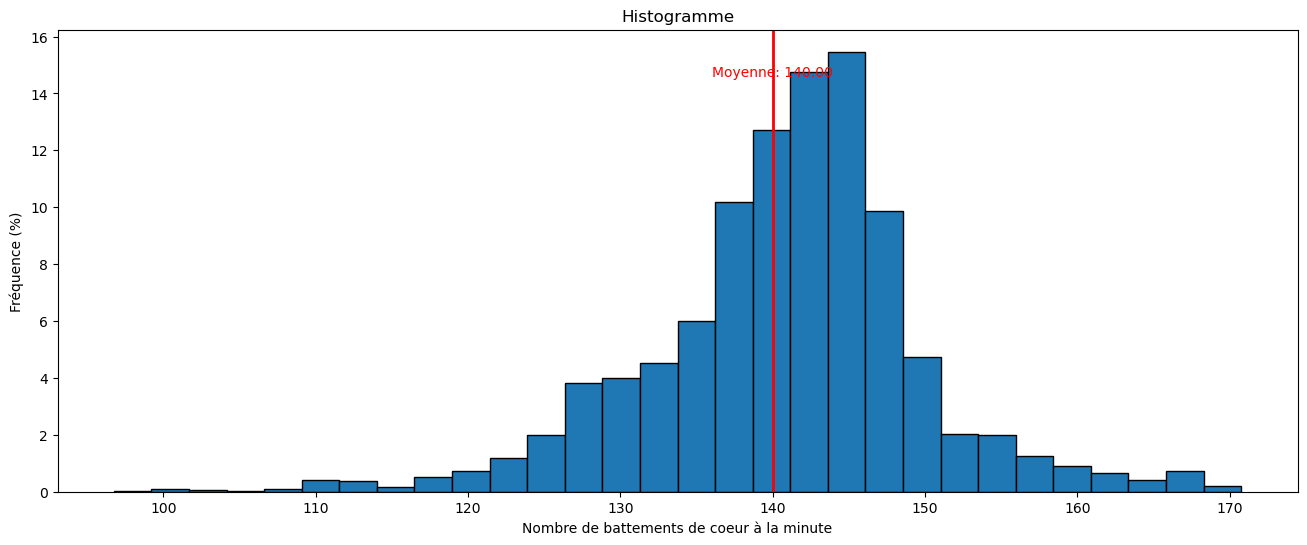

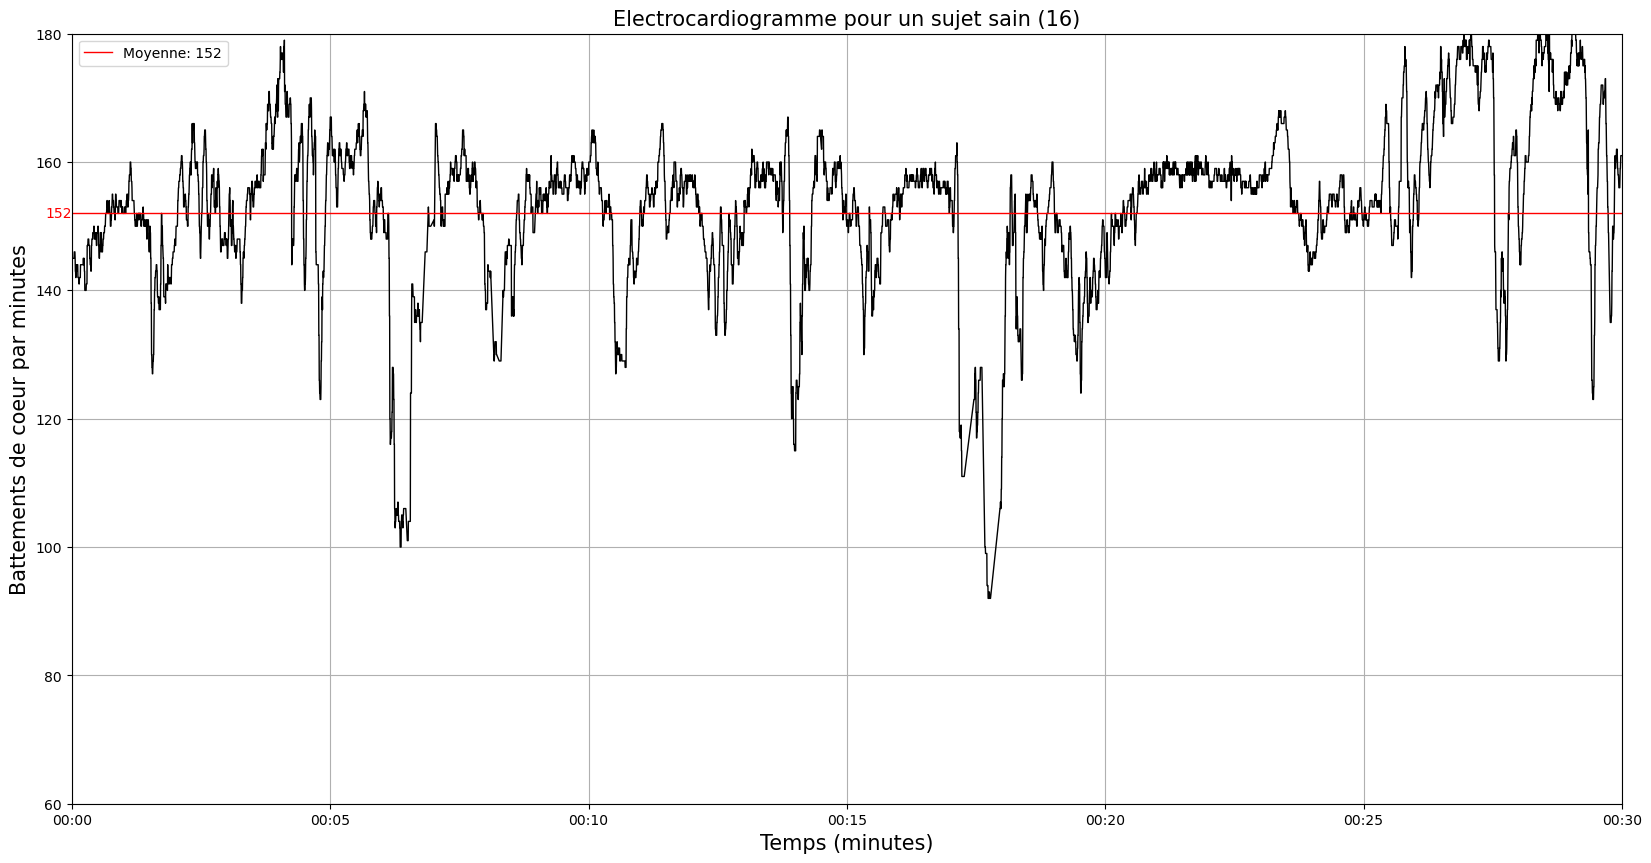

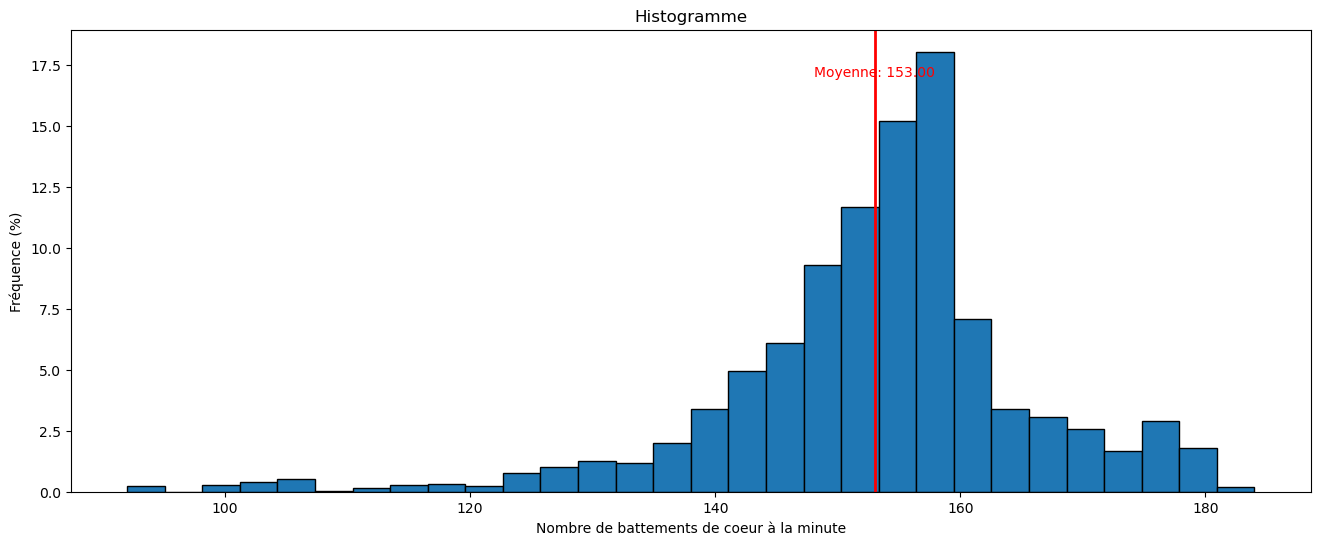

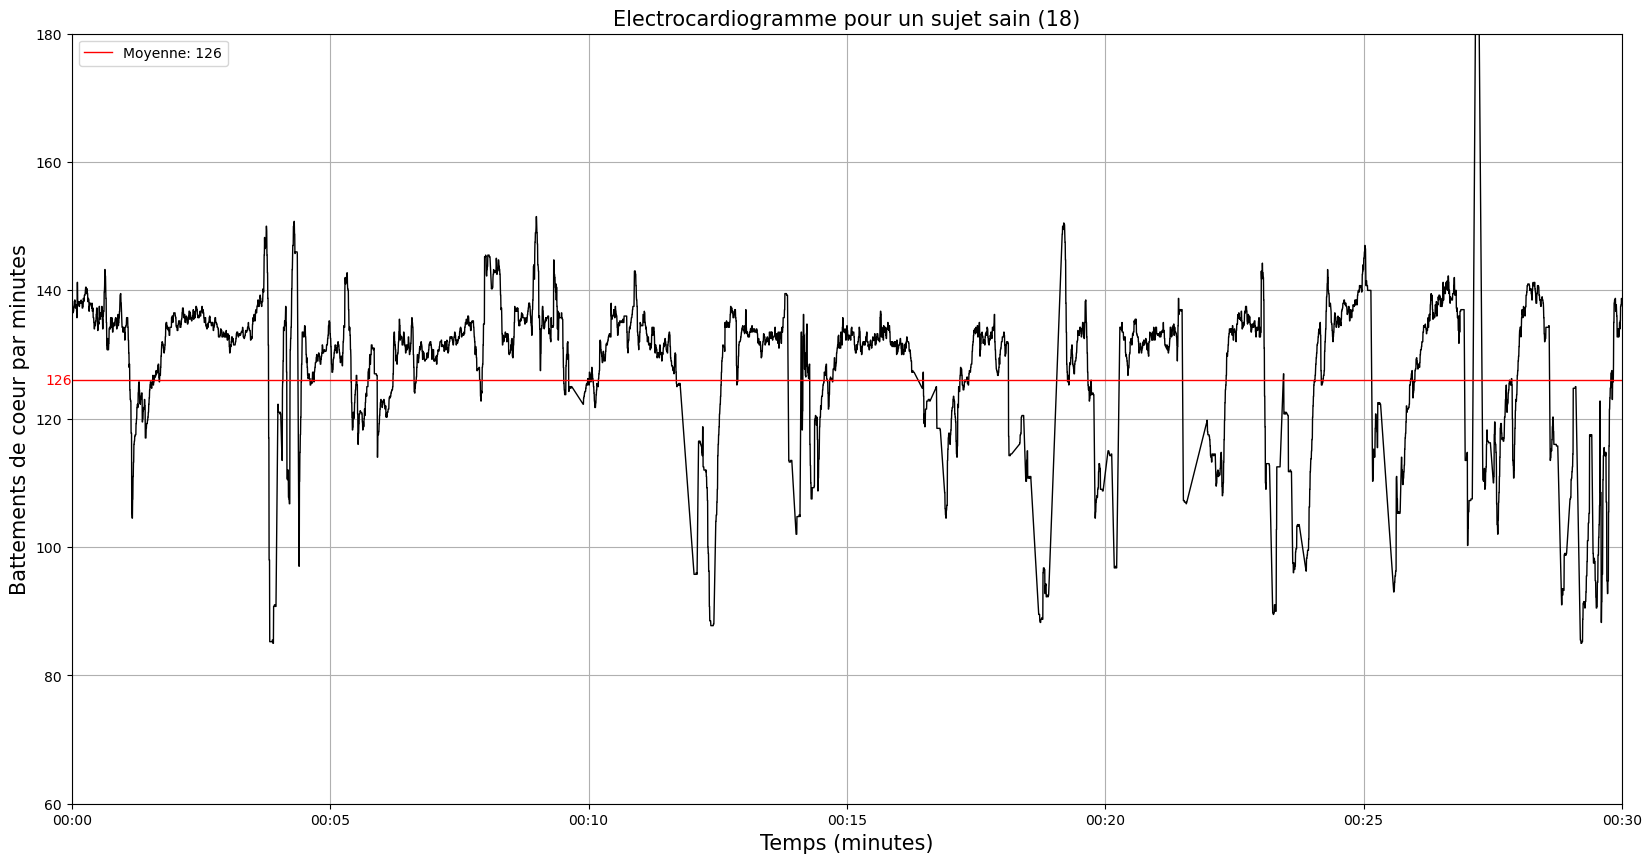

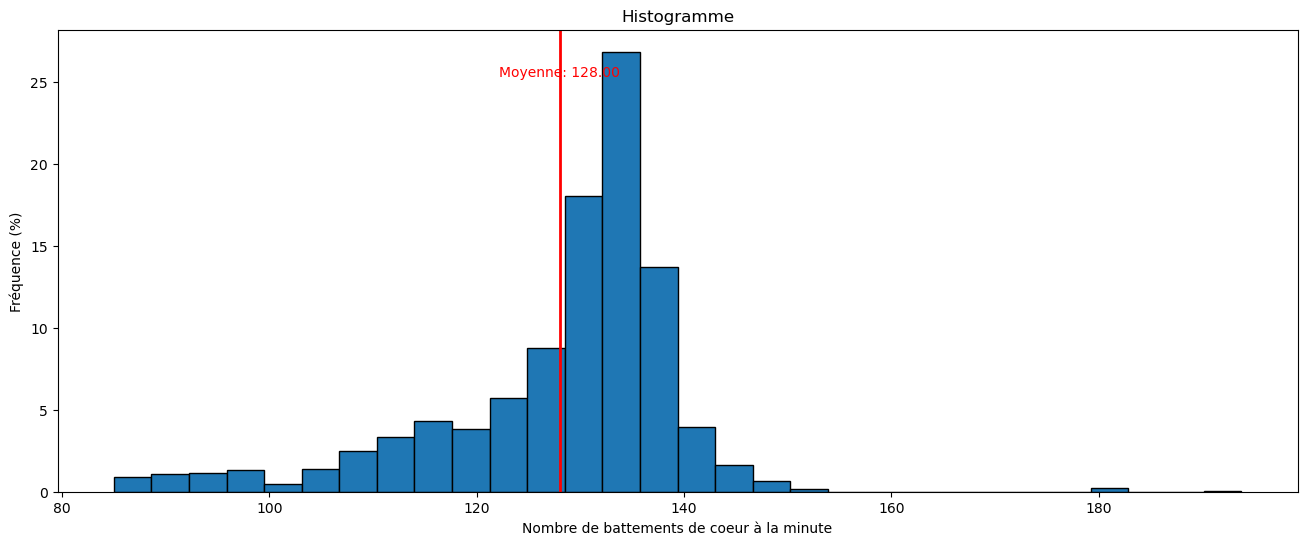

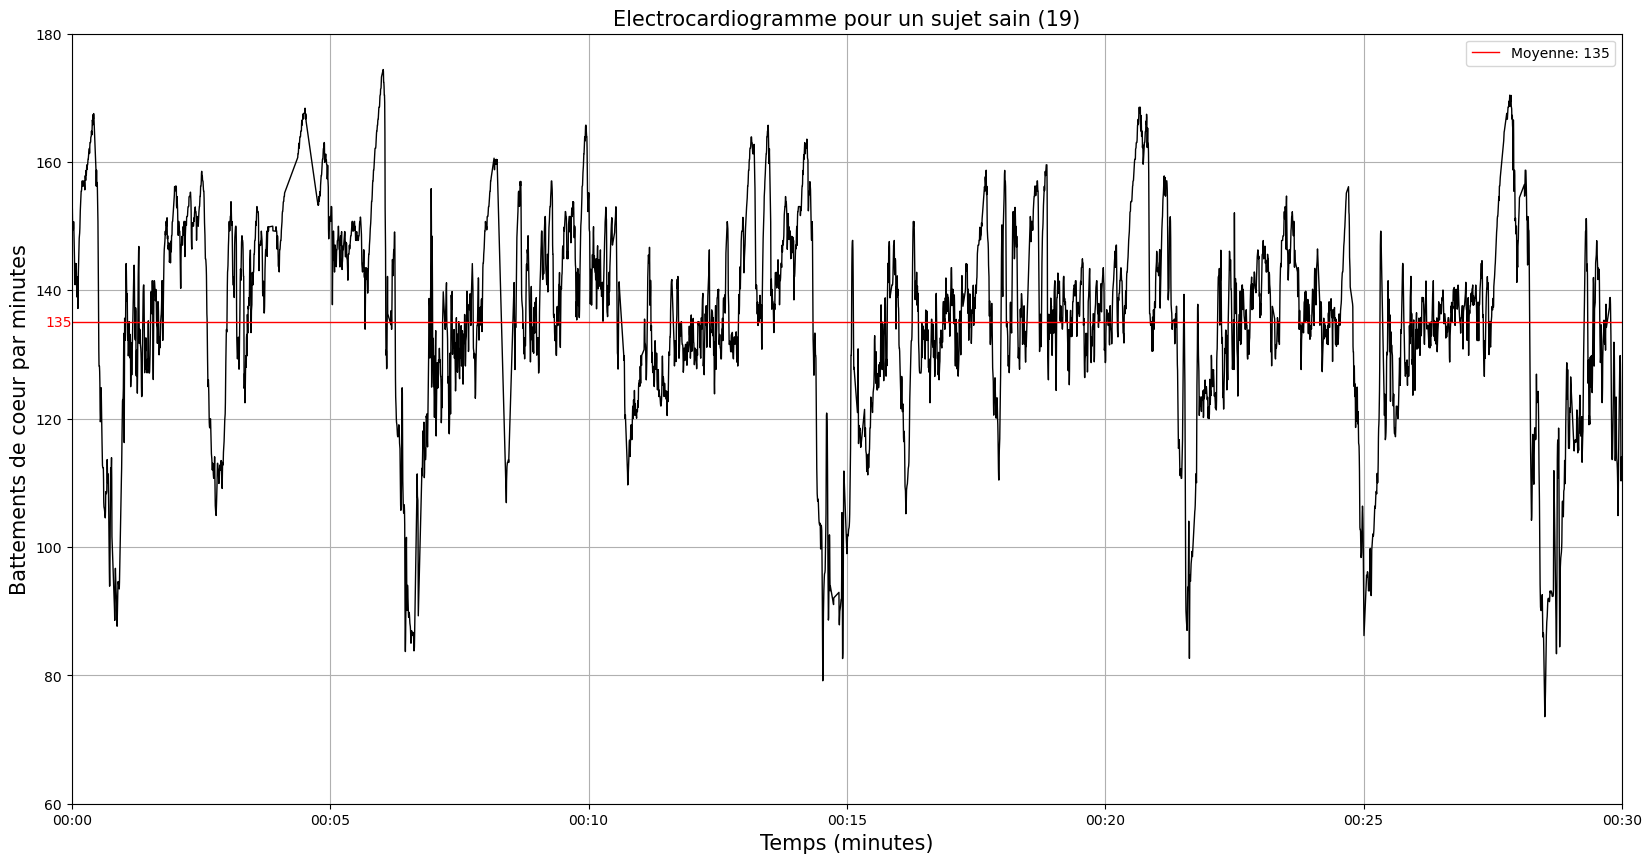

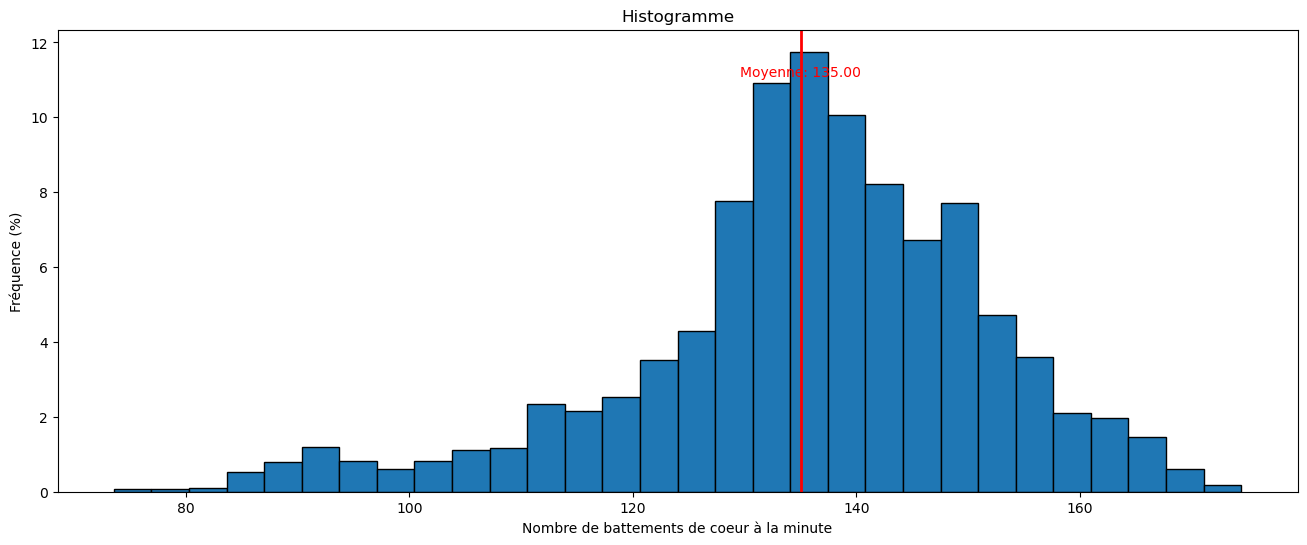

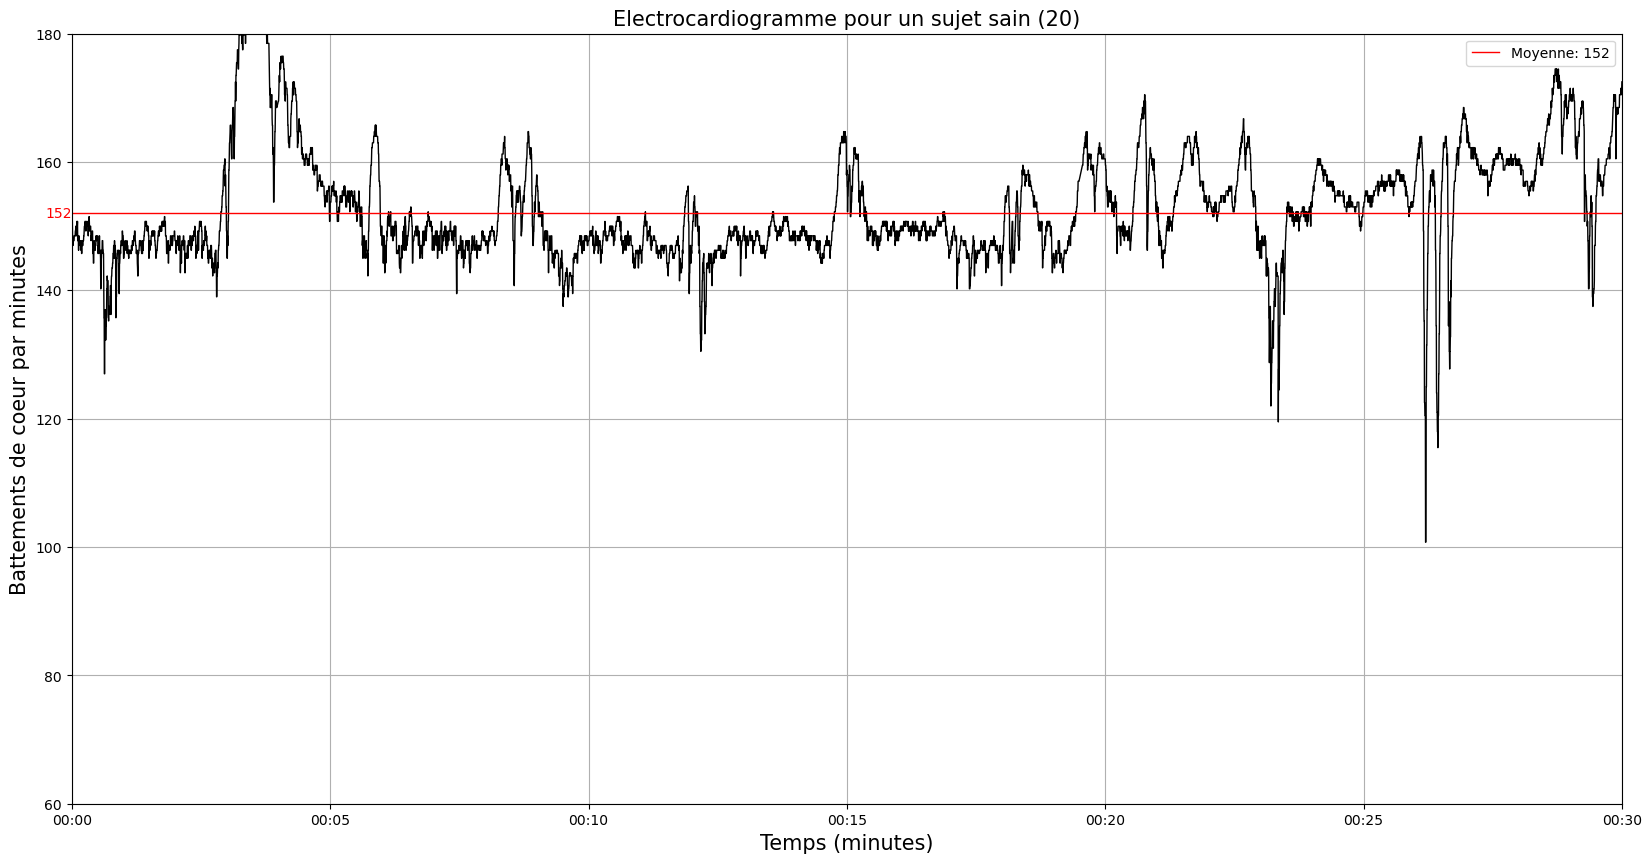

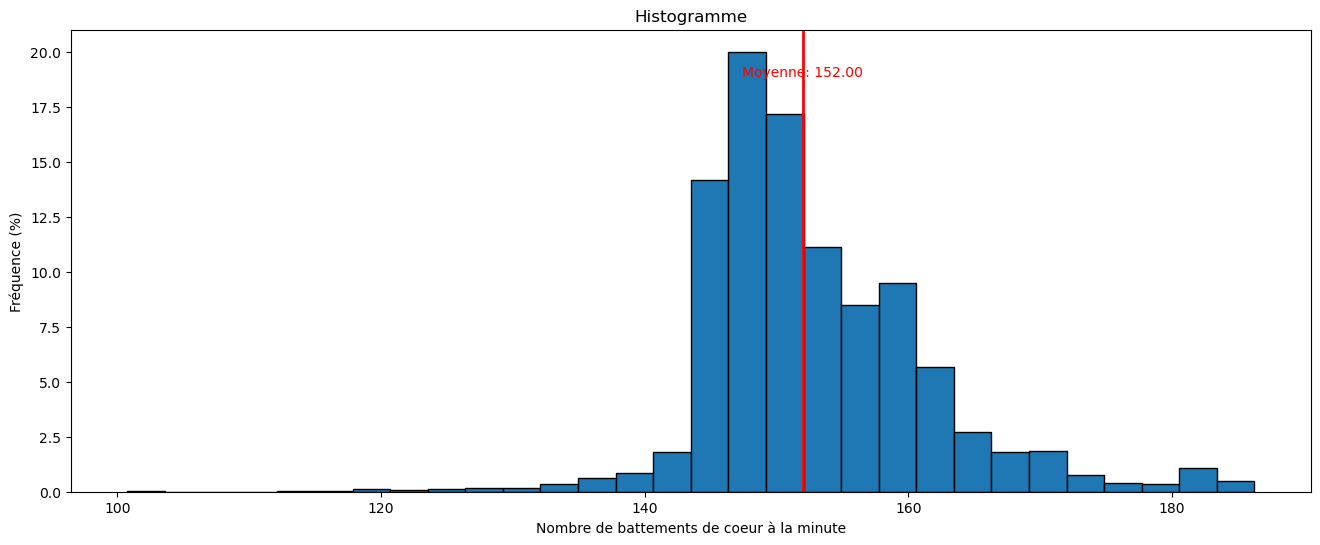

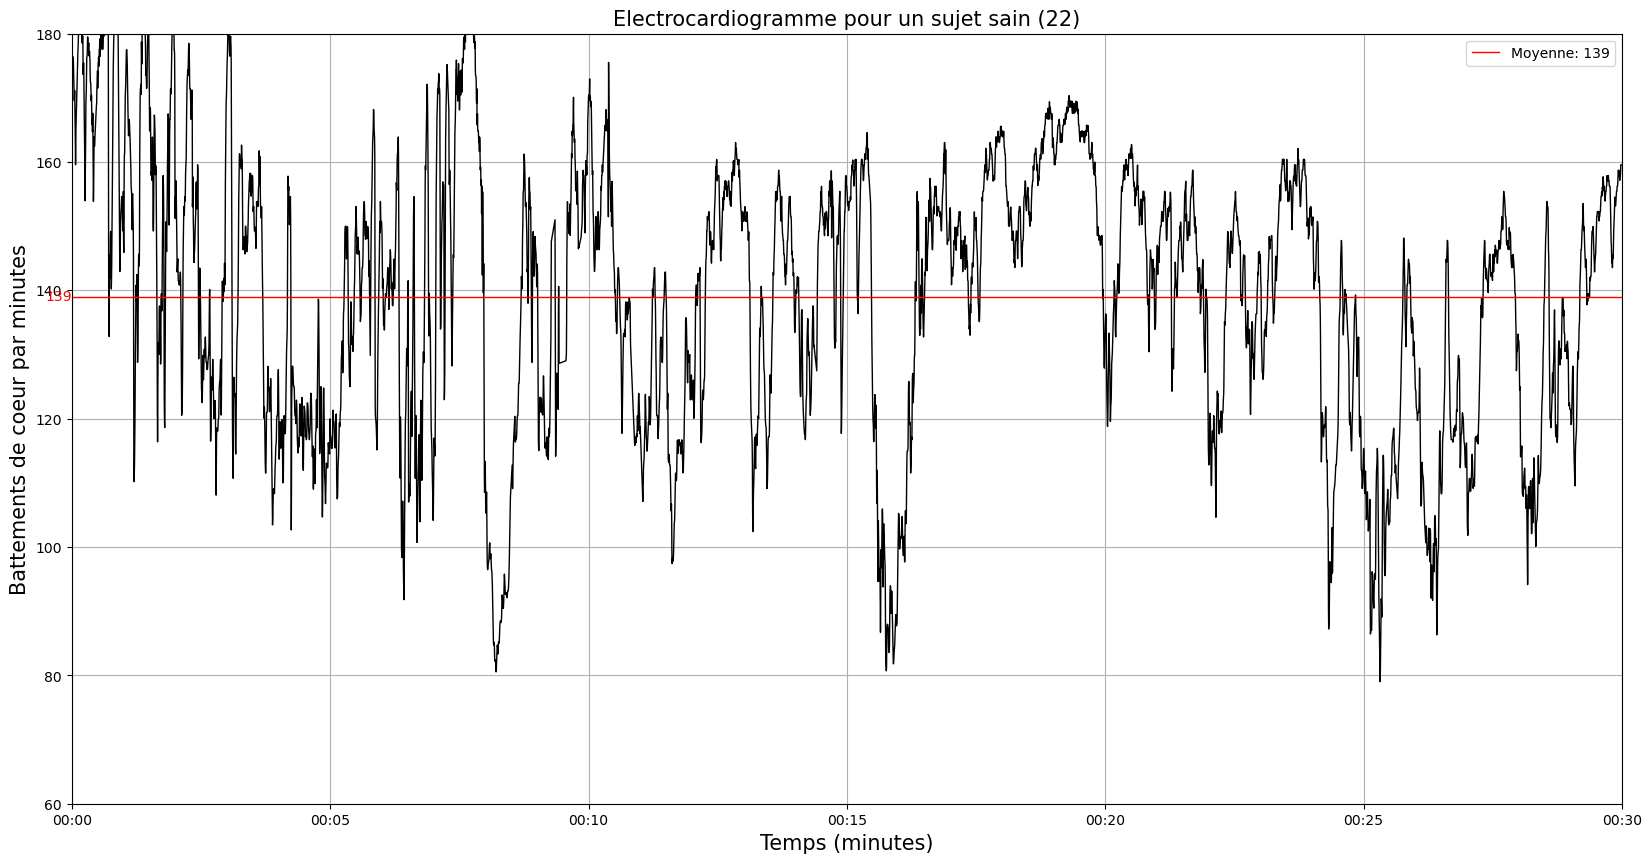

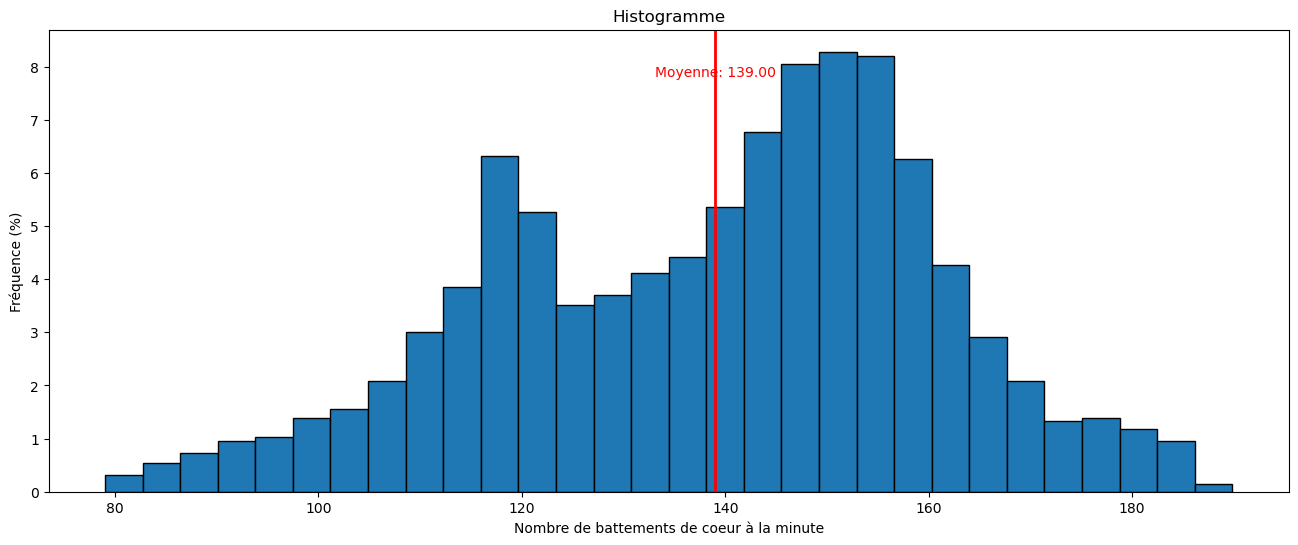

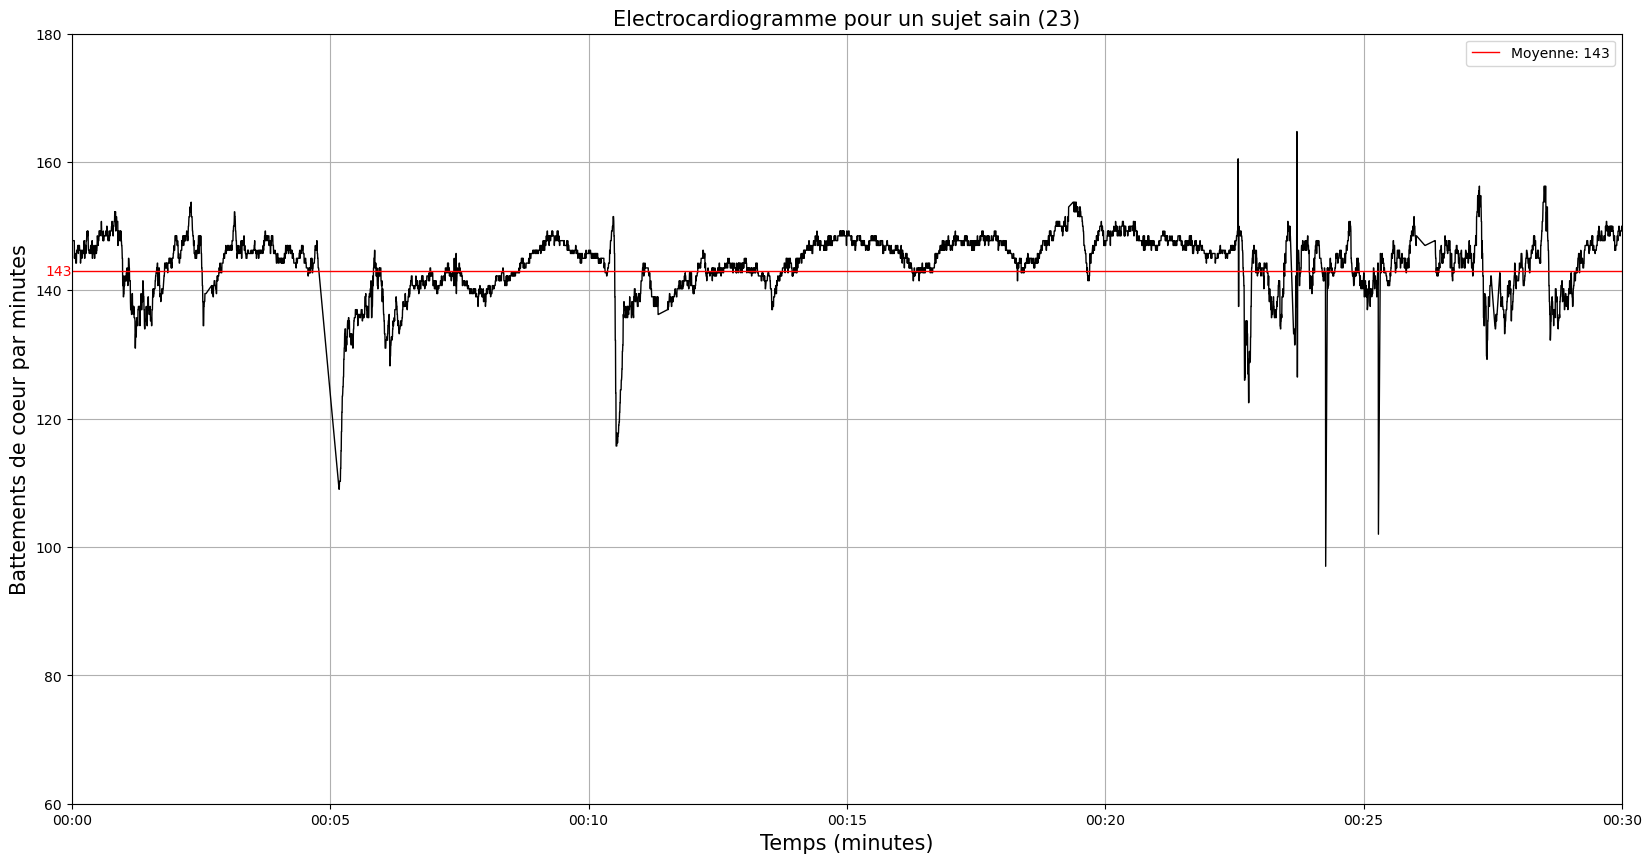

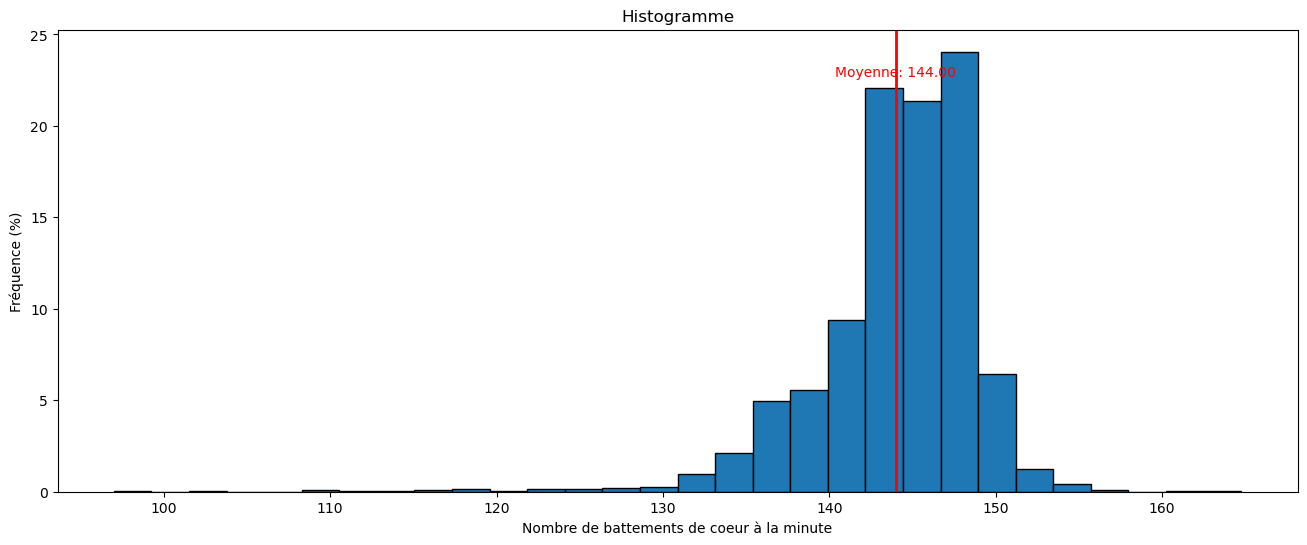

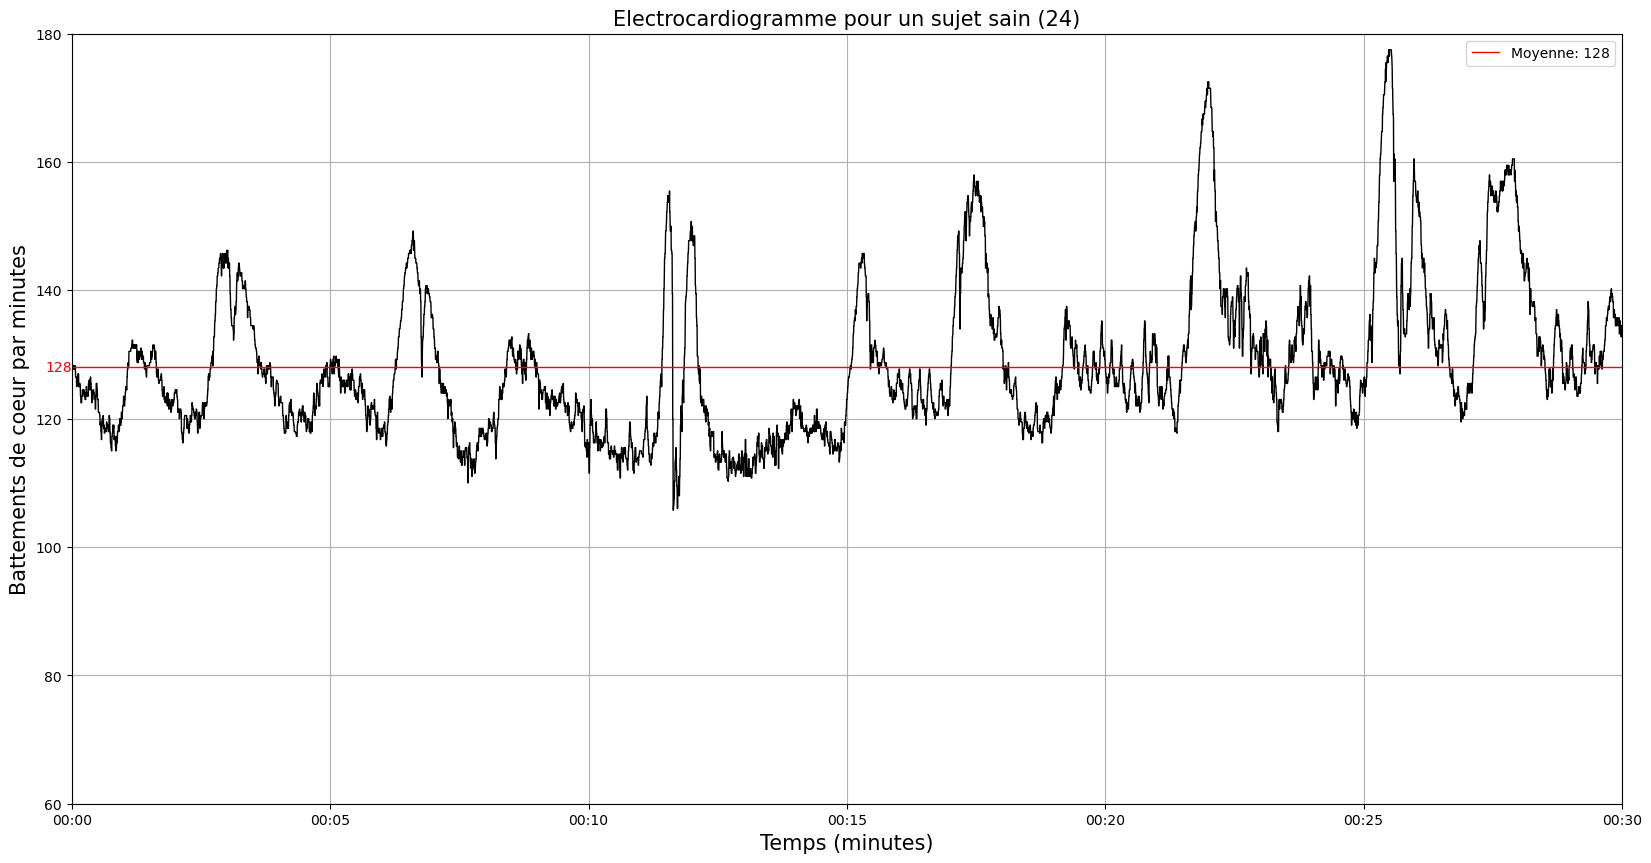

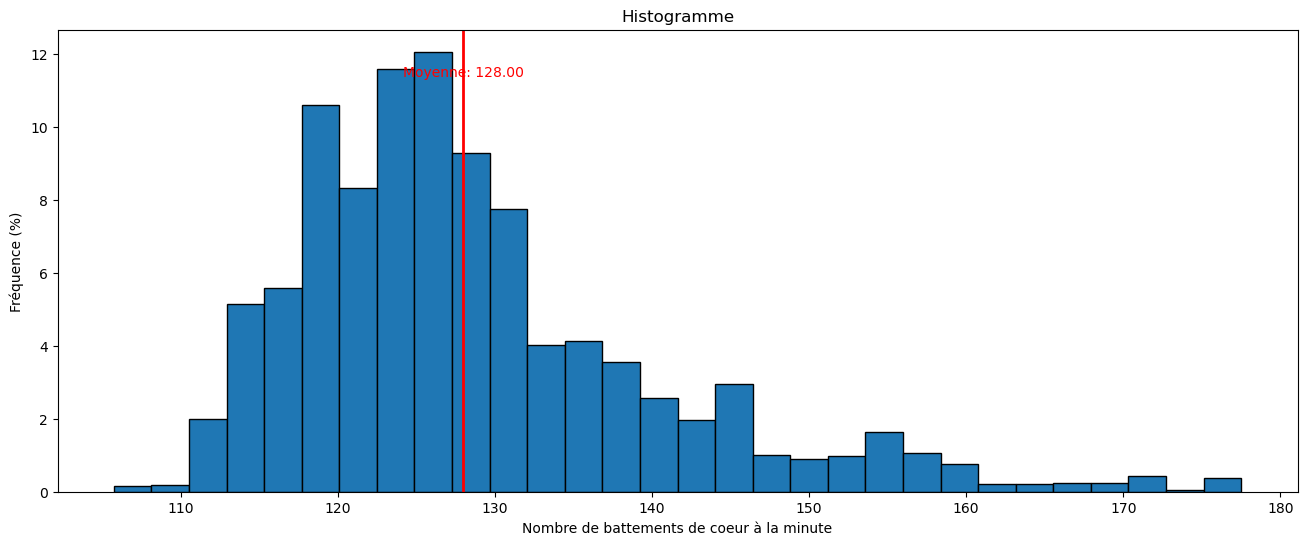

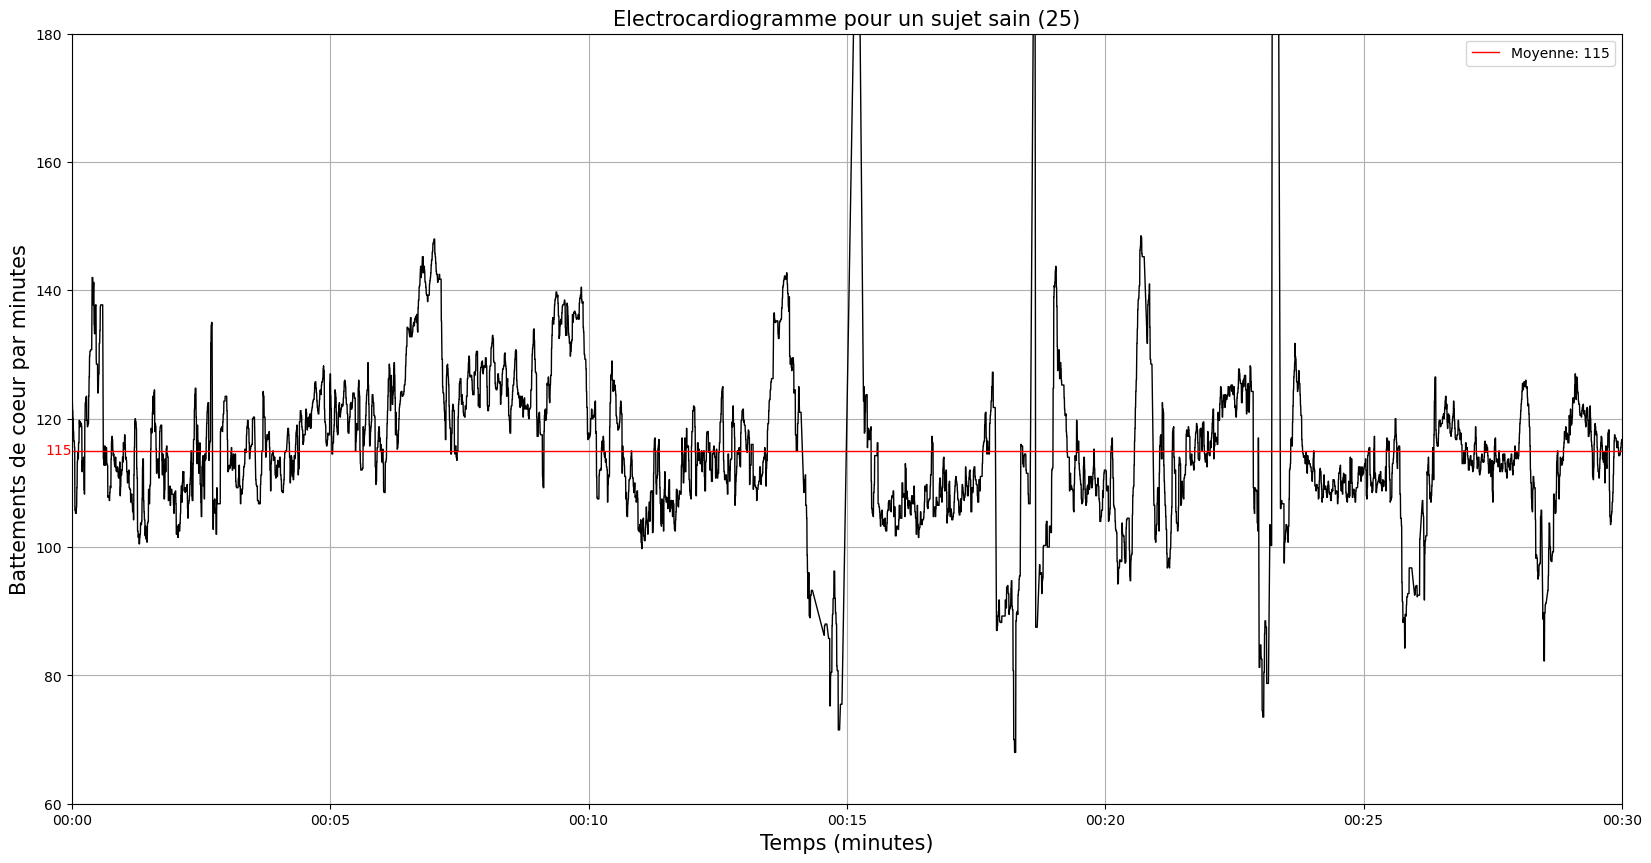

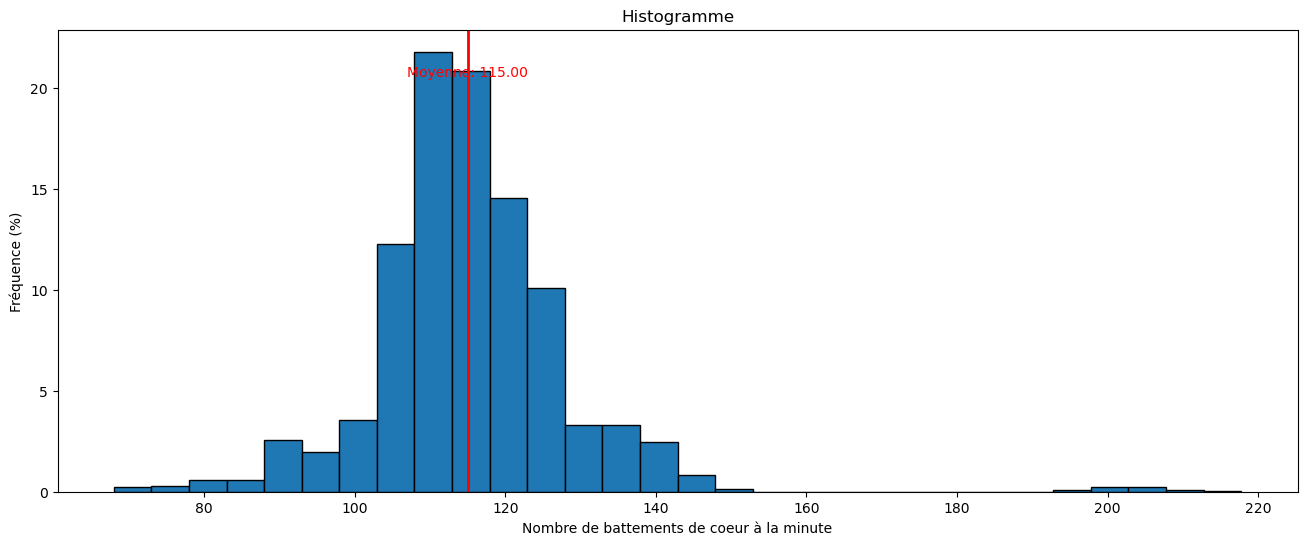

In [24]:
nombre_a_afficher = 20
start_minut = -60
duration_in_minuts = 30
label = 0  #0 pour les sujets sains , 1 pour les sujets malades
start_id =1 # id du 1er élément à afficher

display_electrocardiograms(nombre_a_afficher, start_minut, duration_in_minuts, label, start_id, display_mean=True)

# Affichage d'exemples de données pour des sujets malades

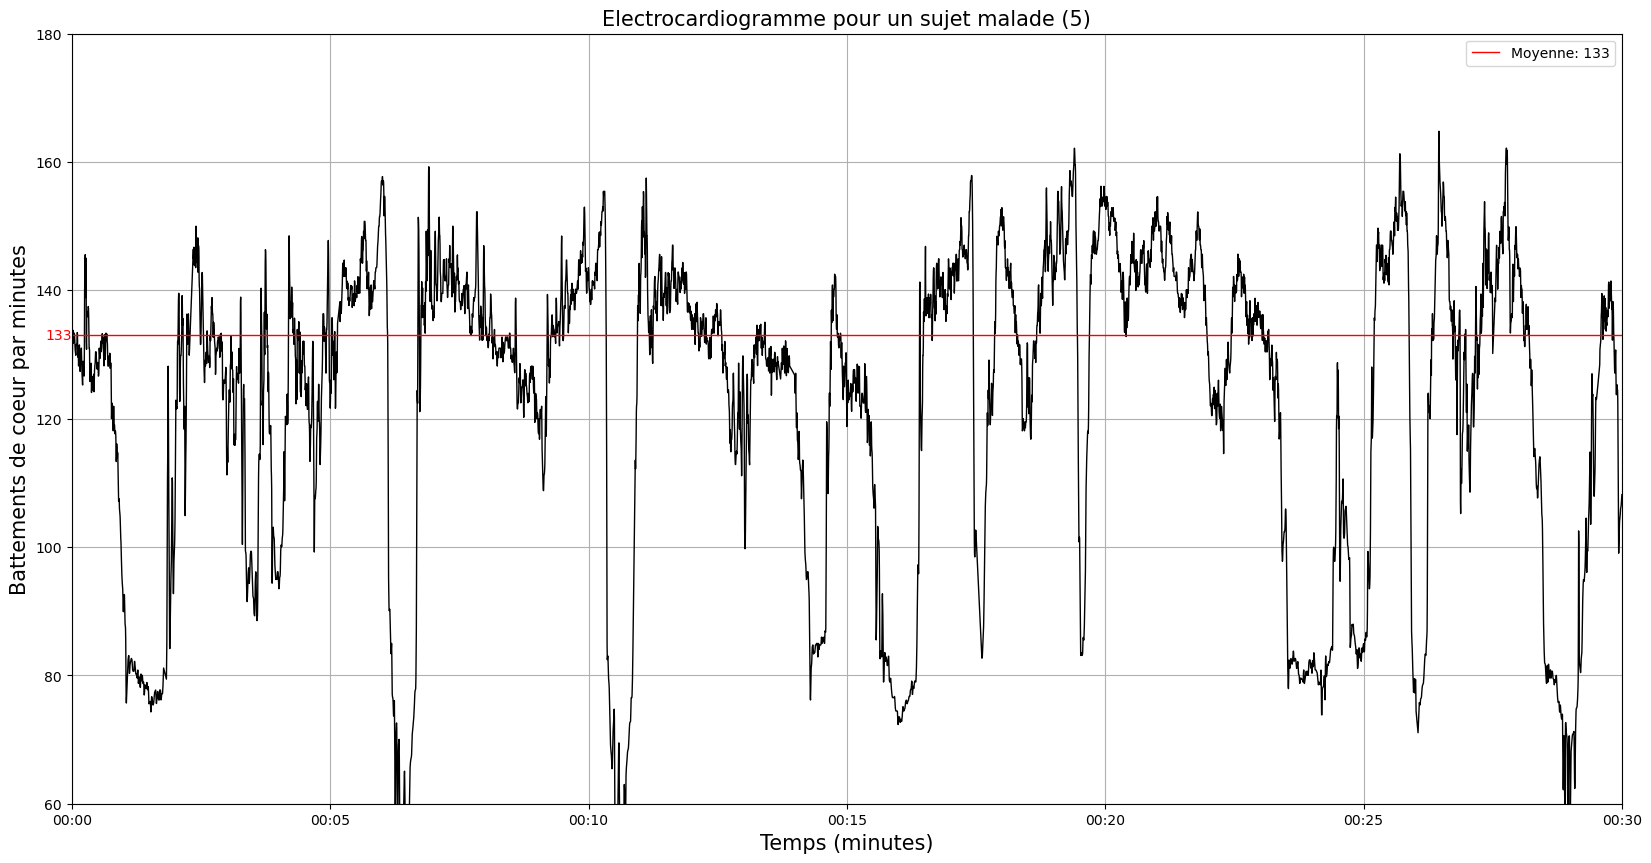

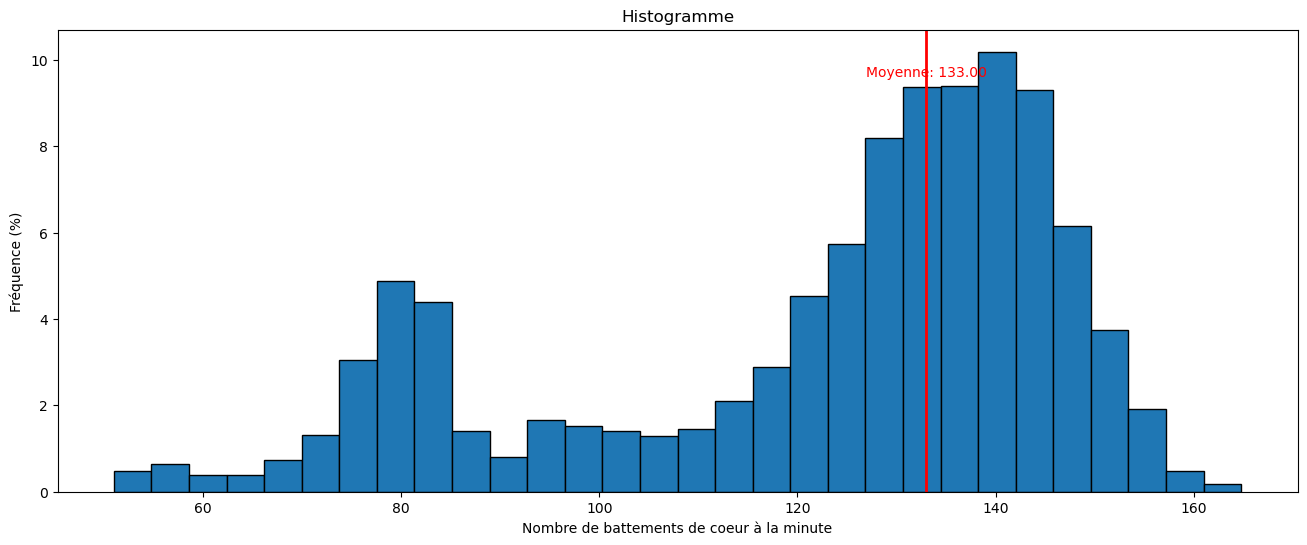

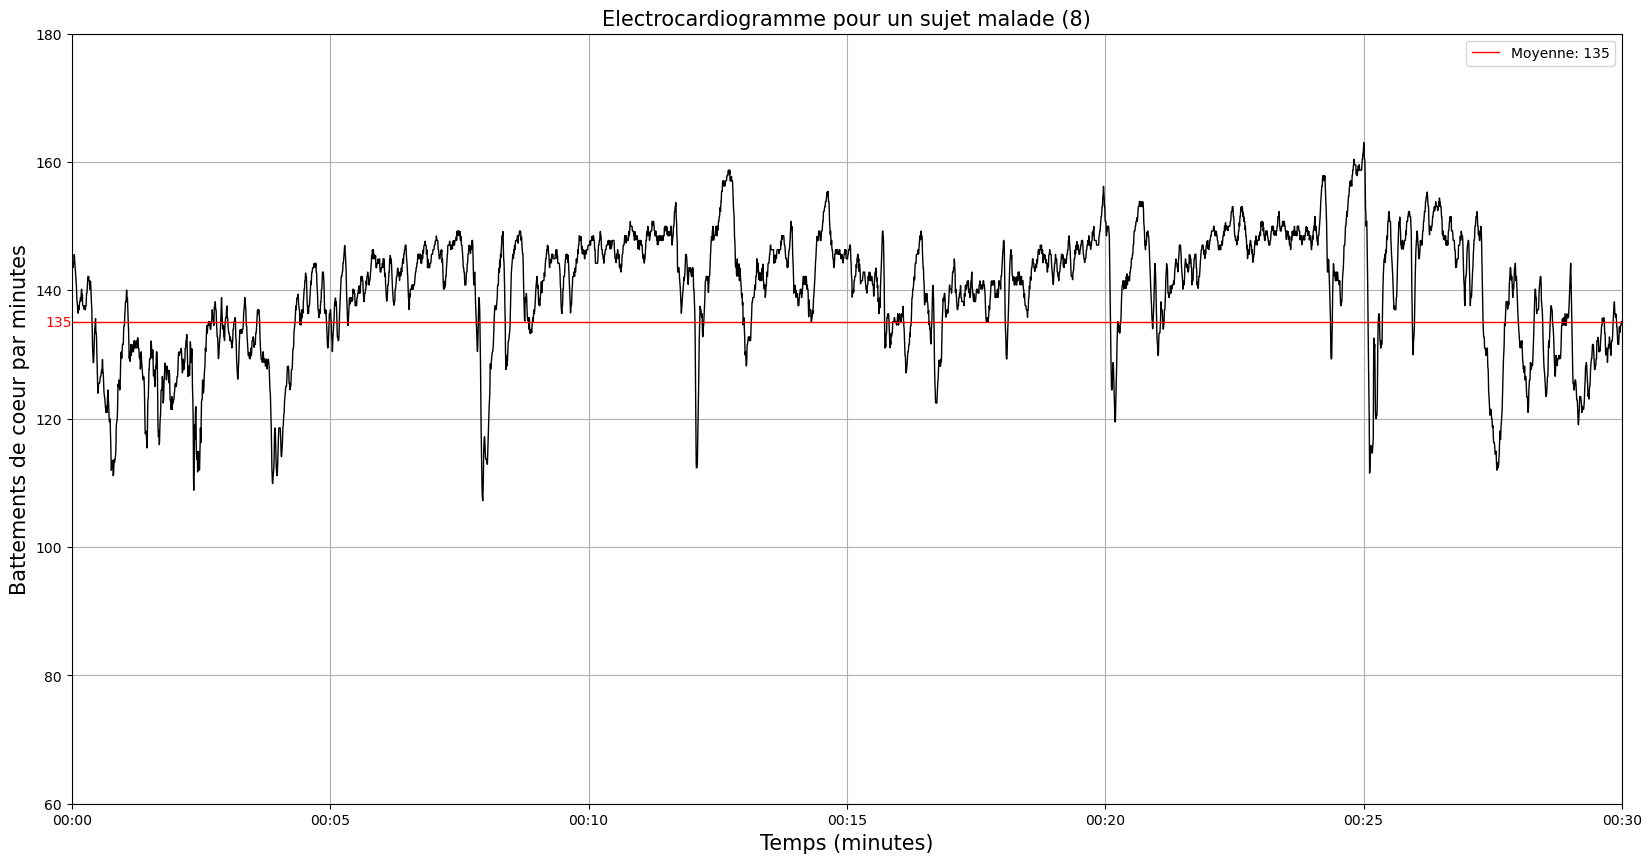

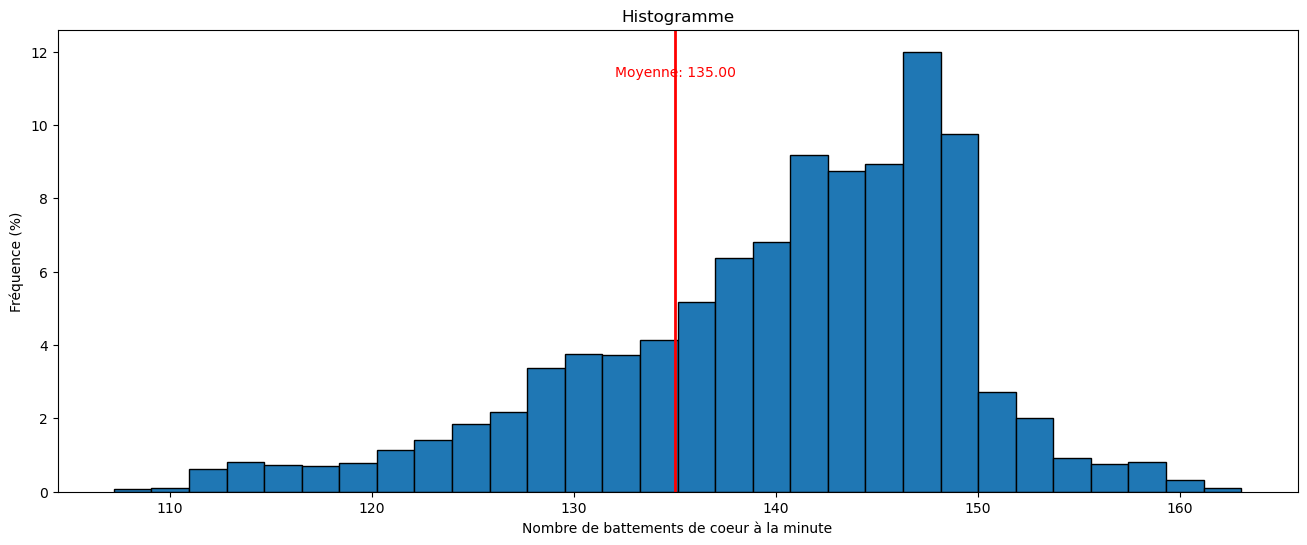

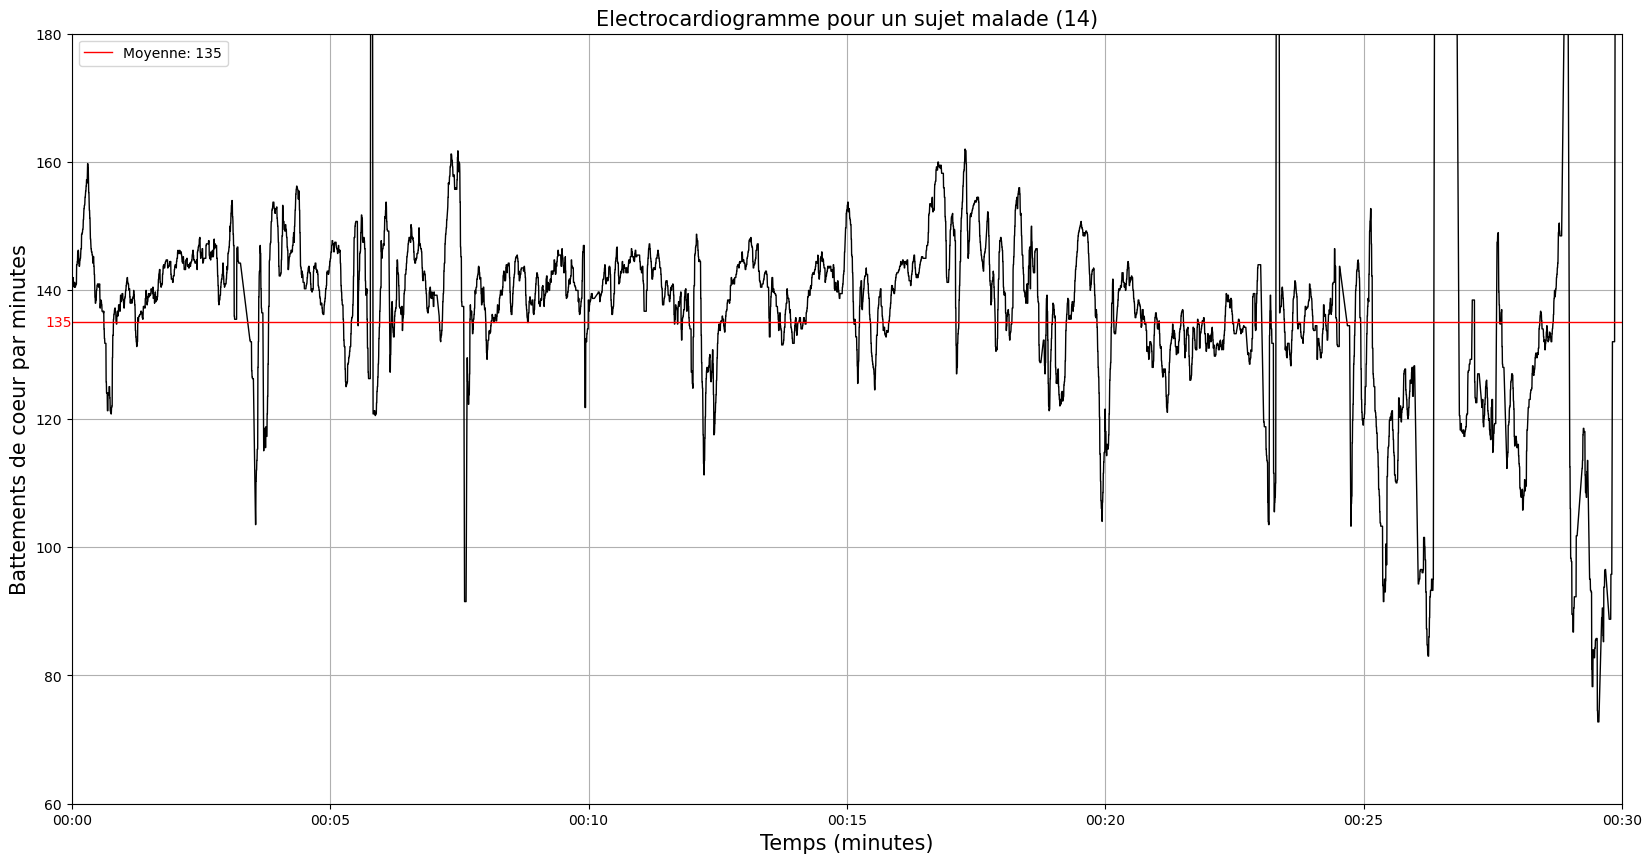

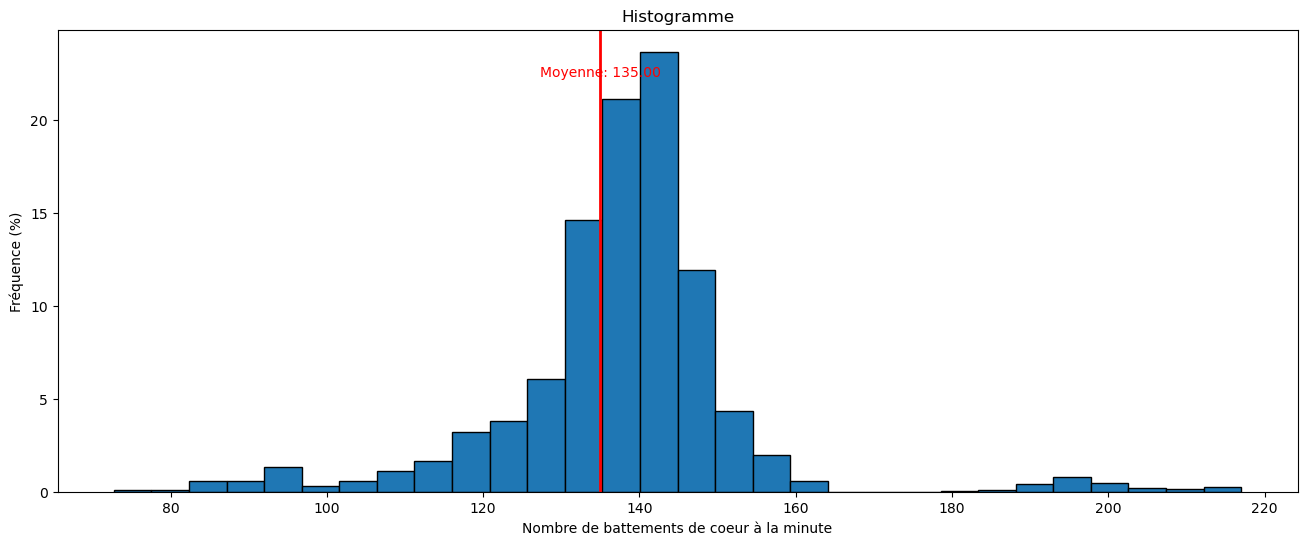

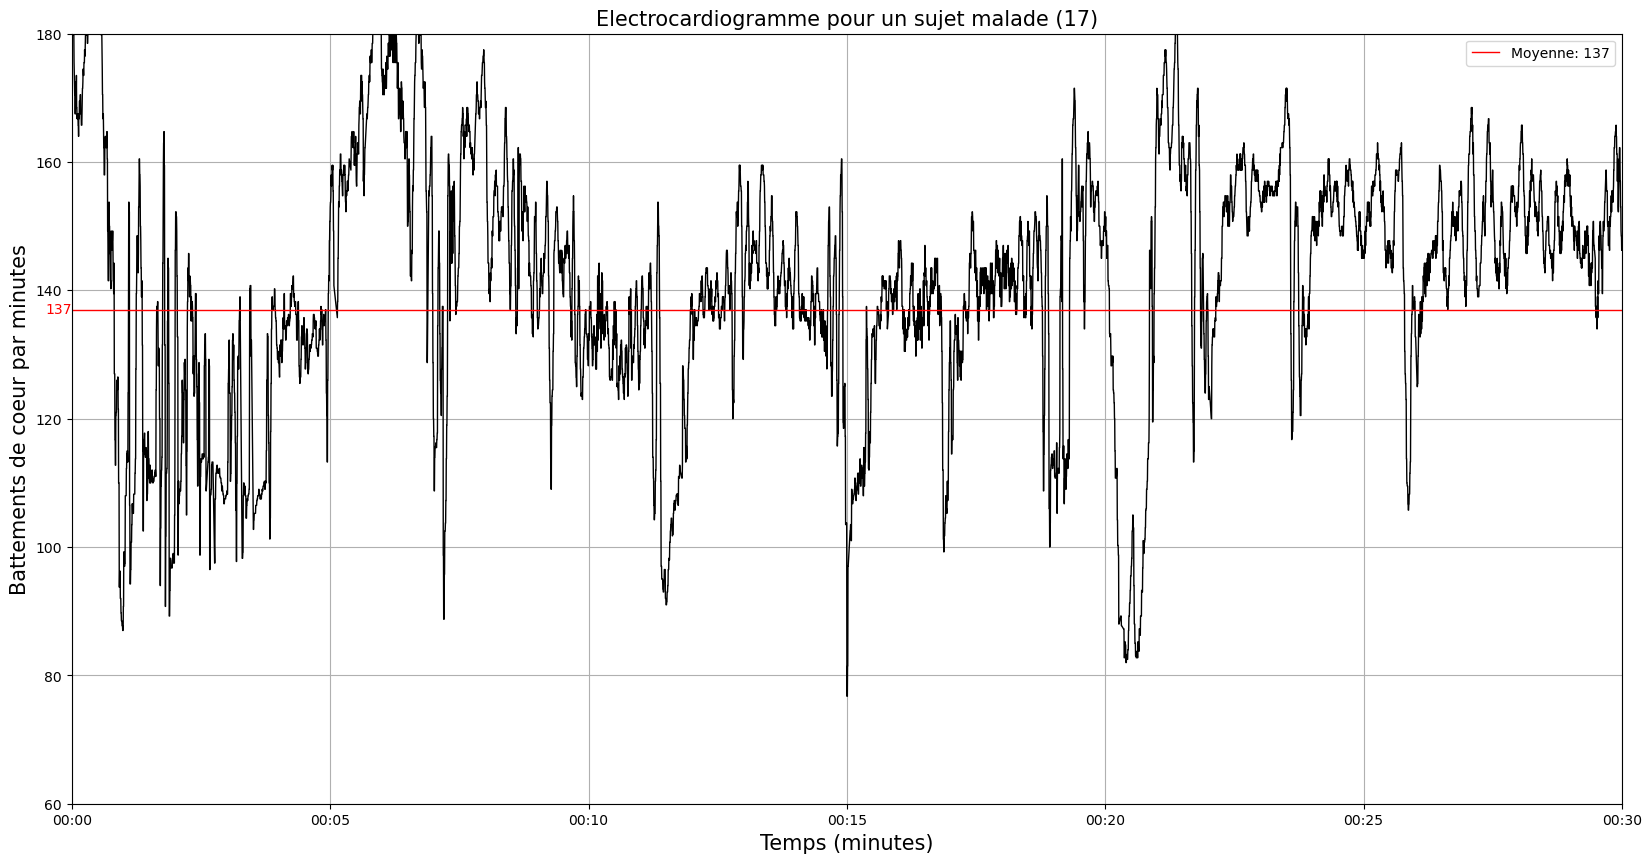

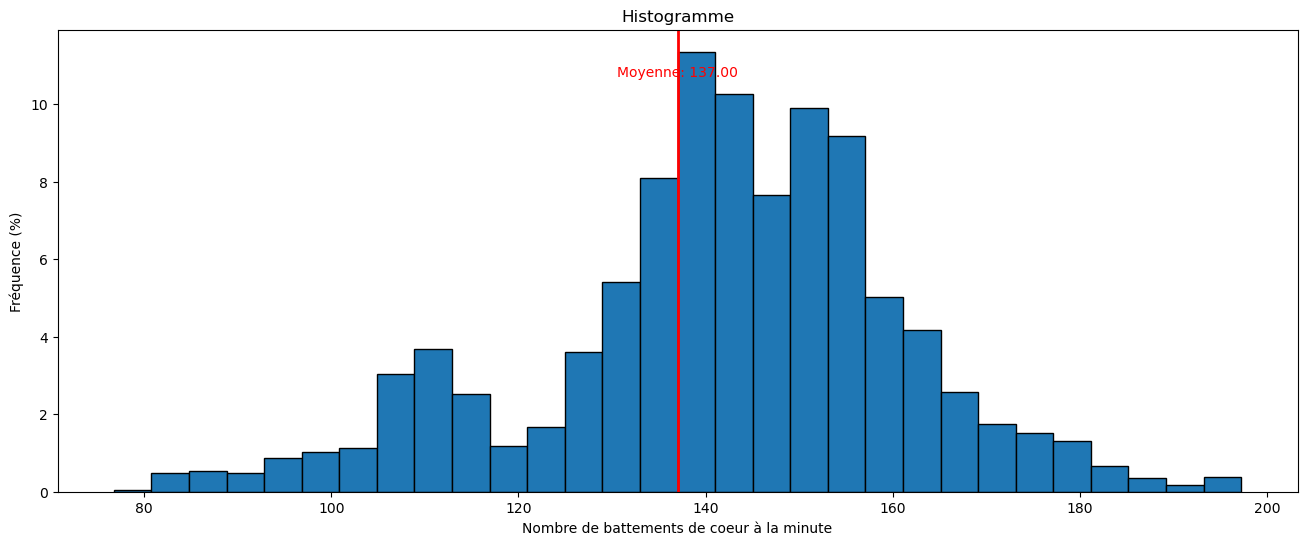

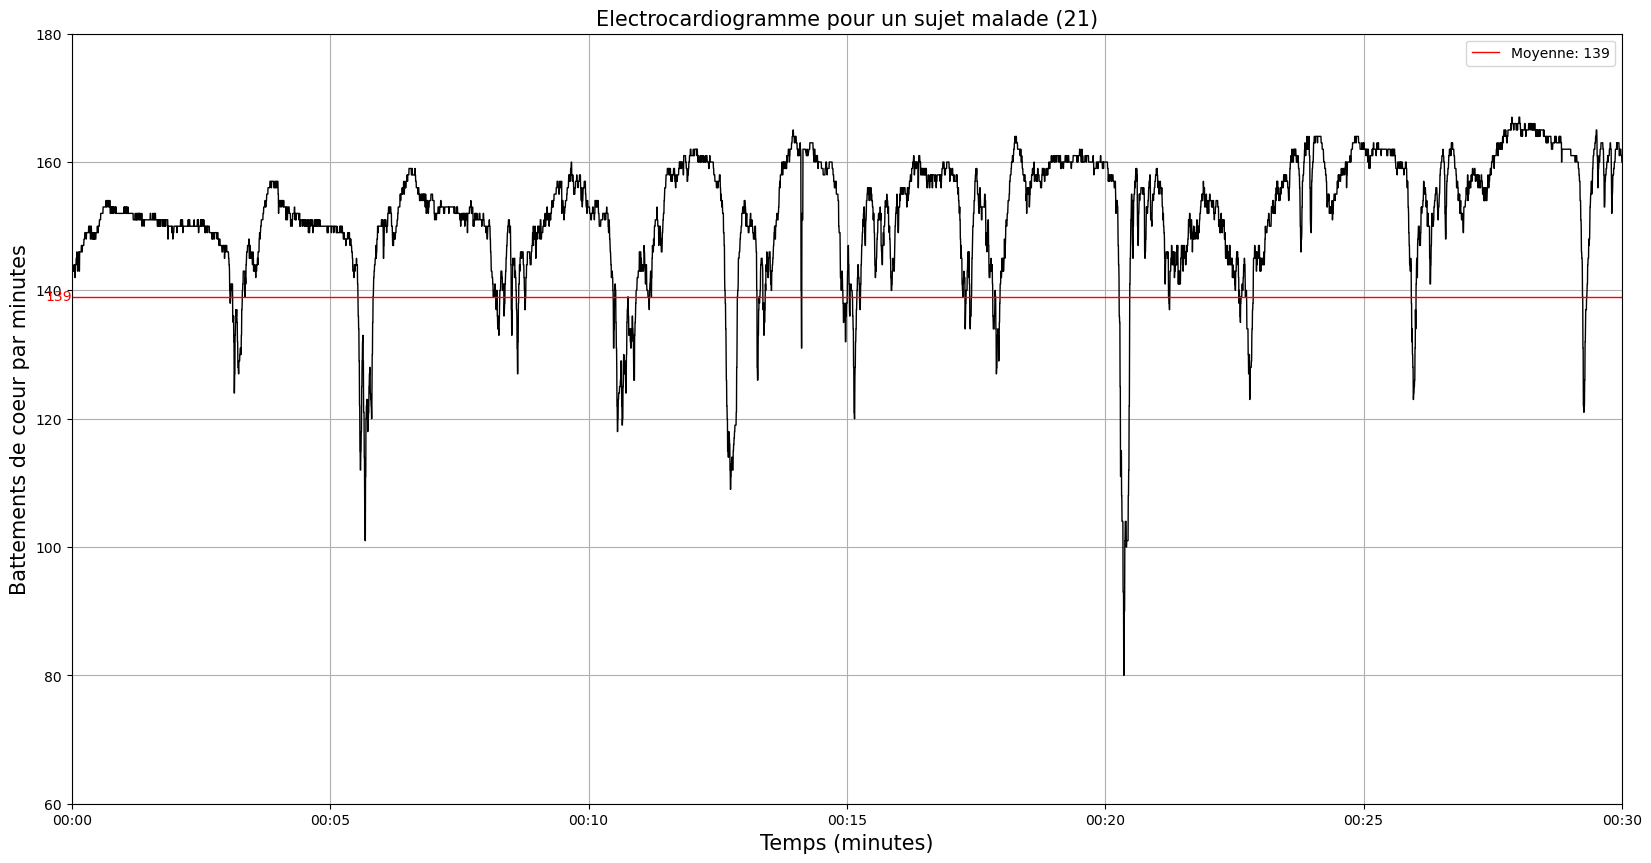

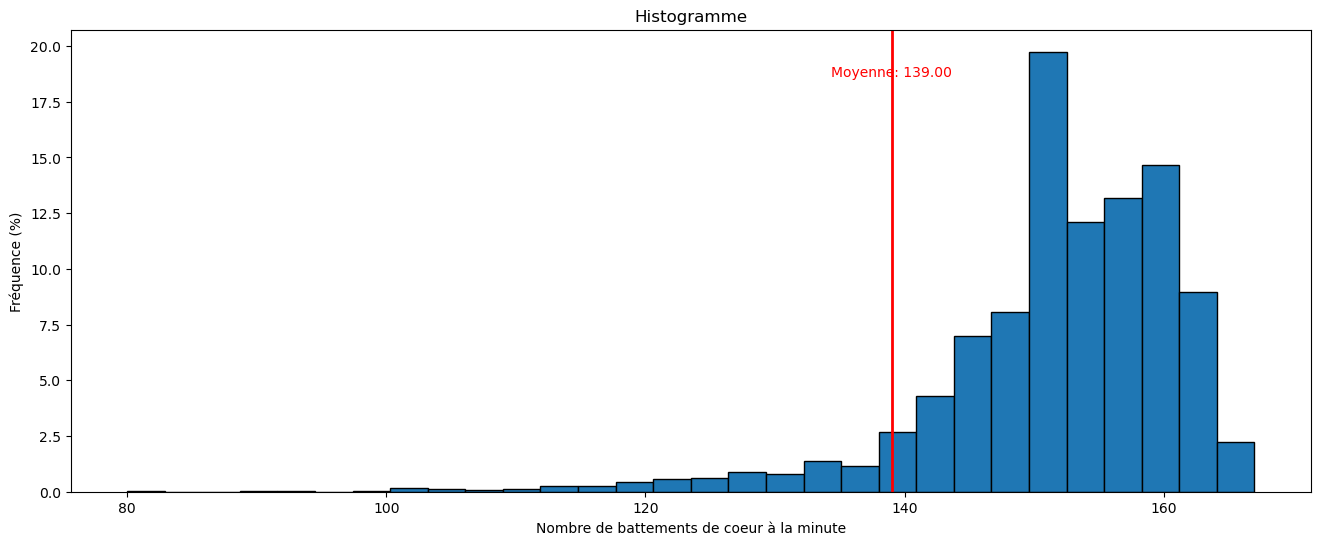

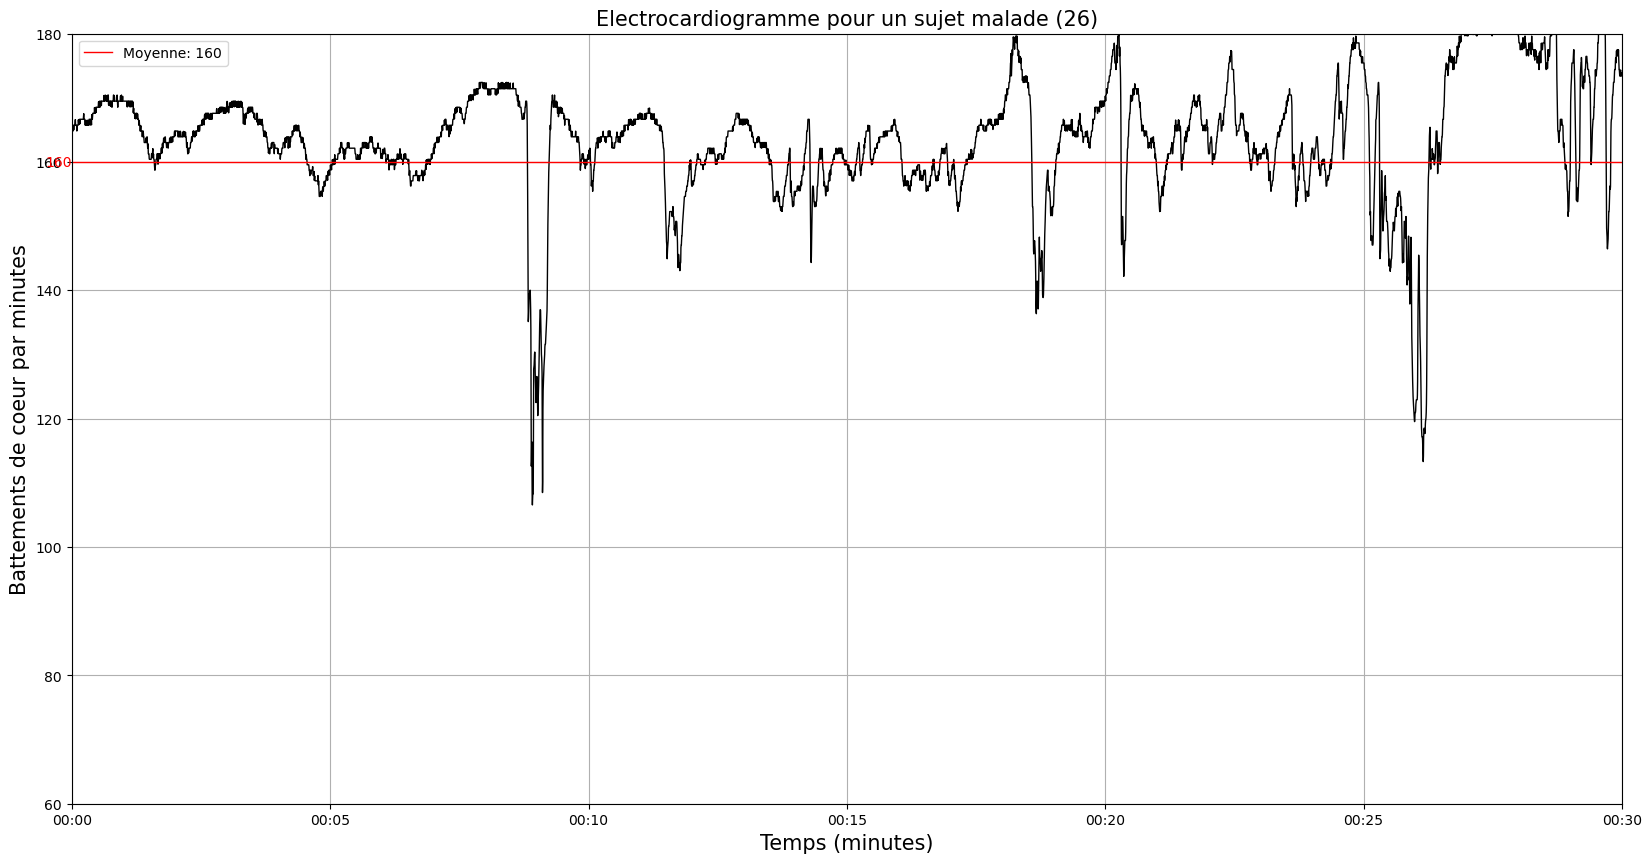

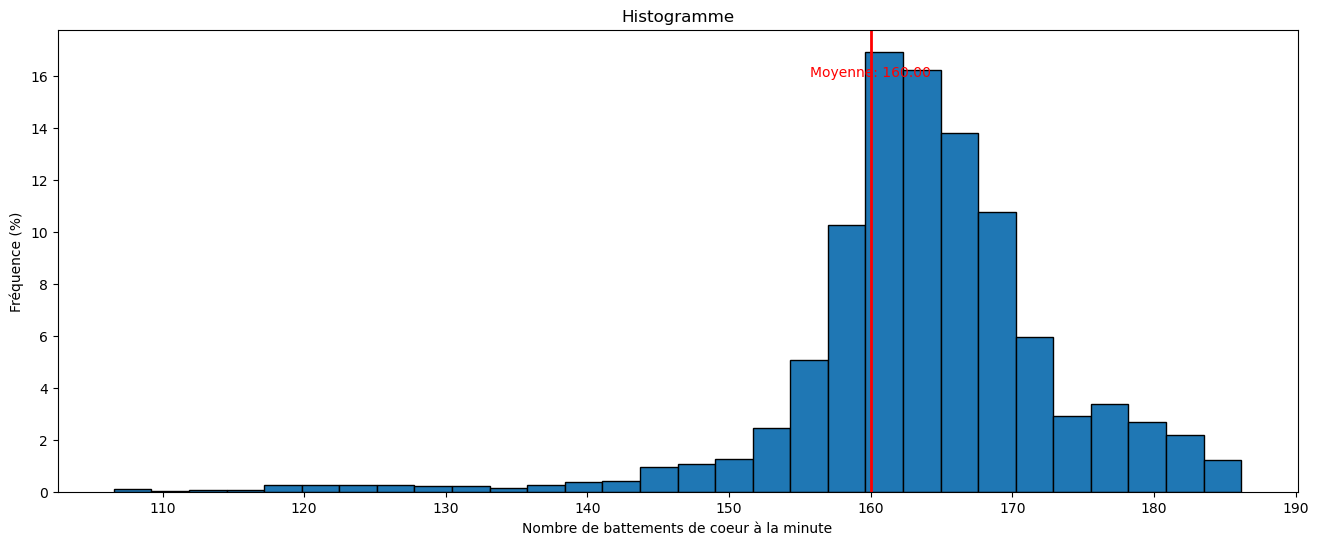

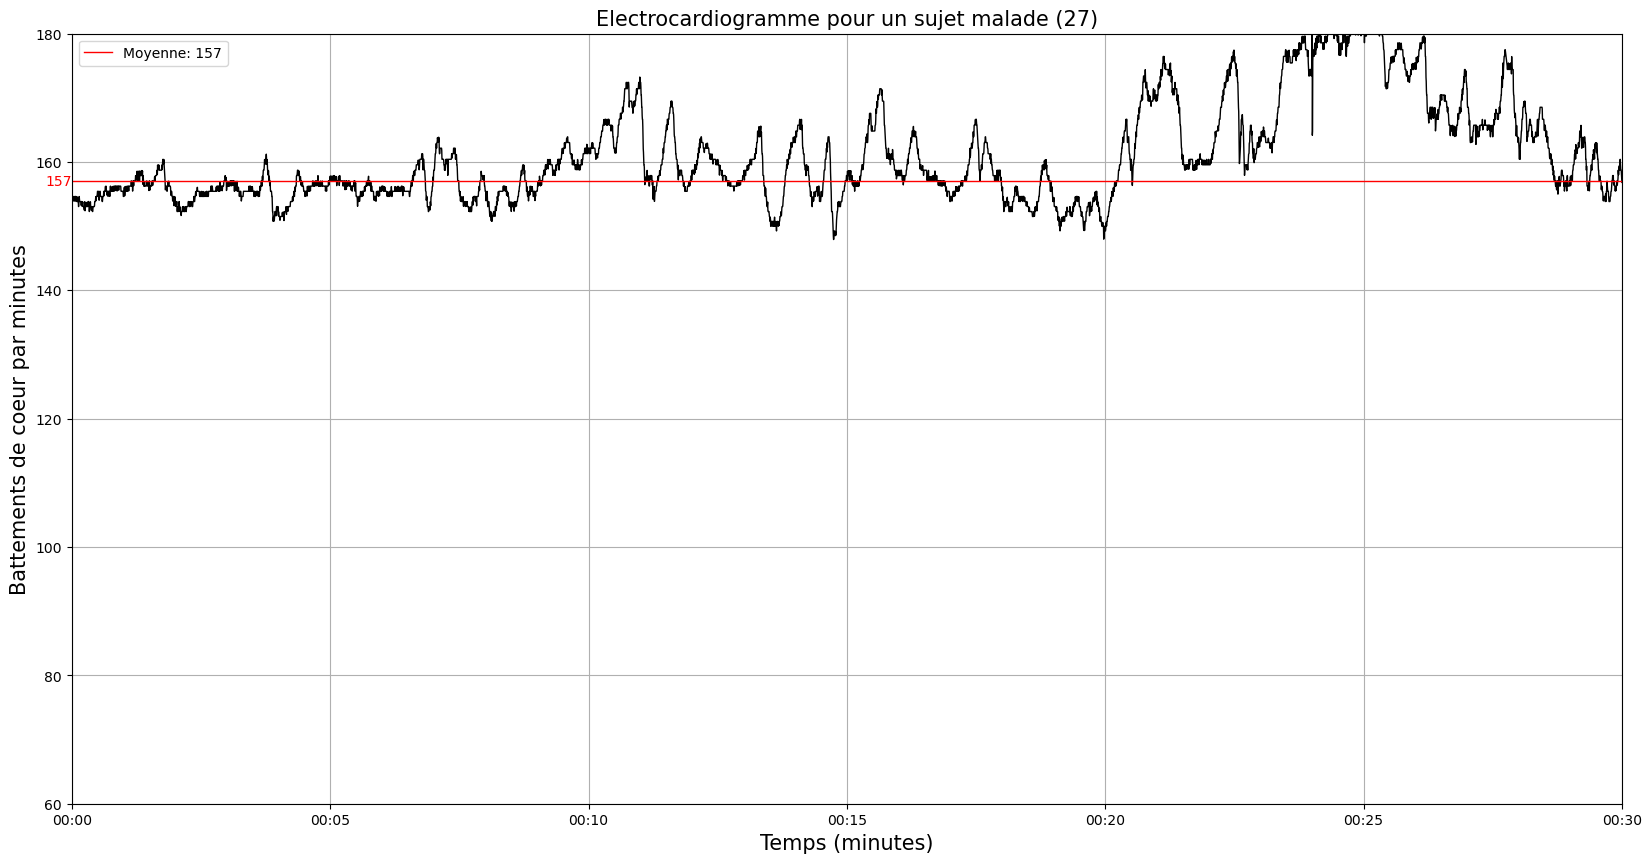

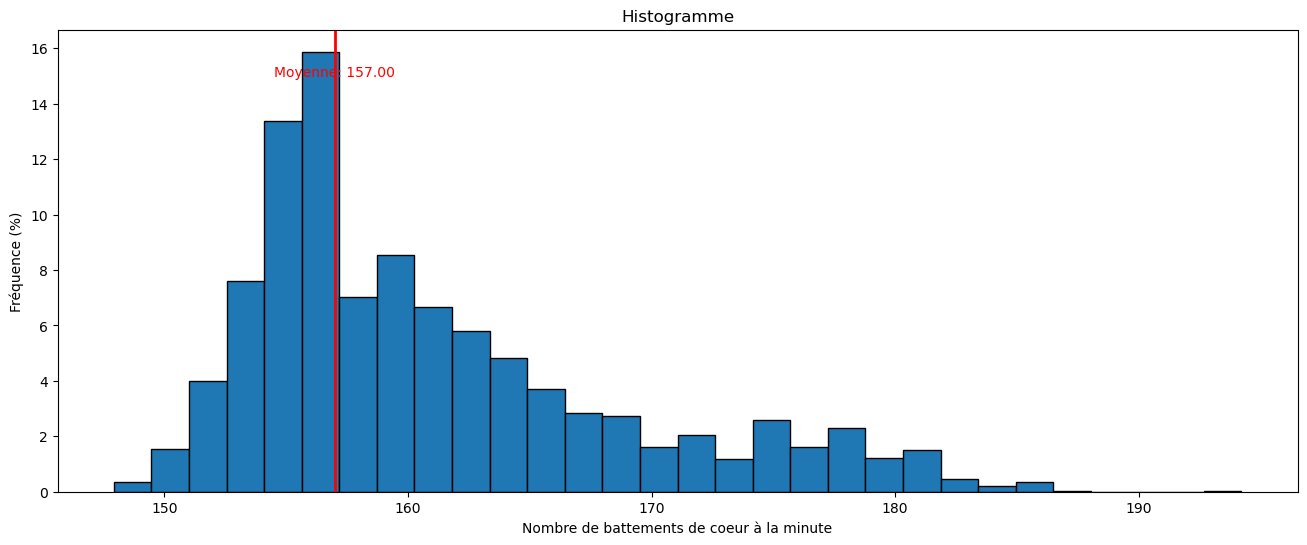

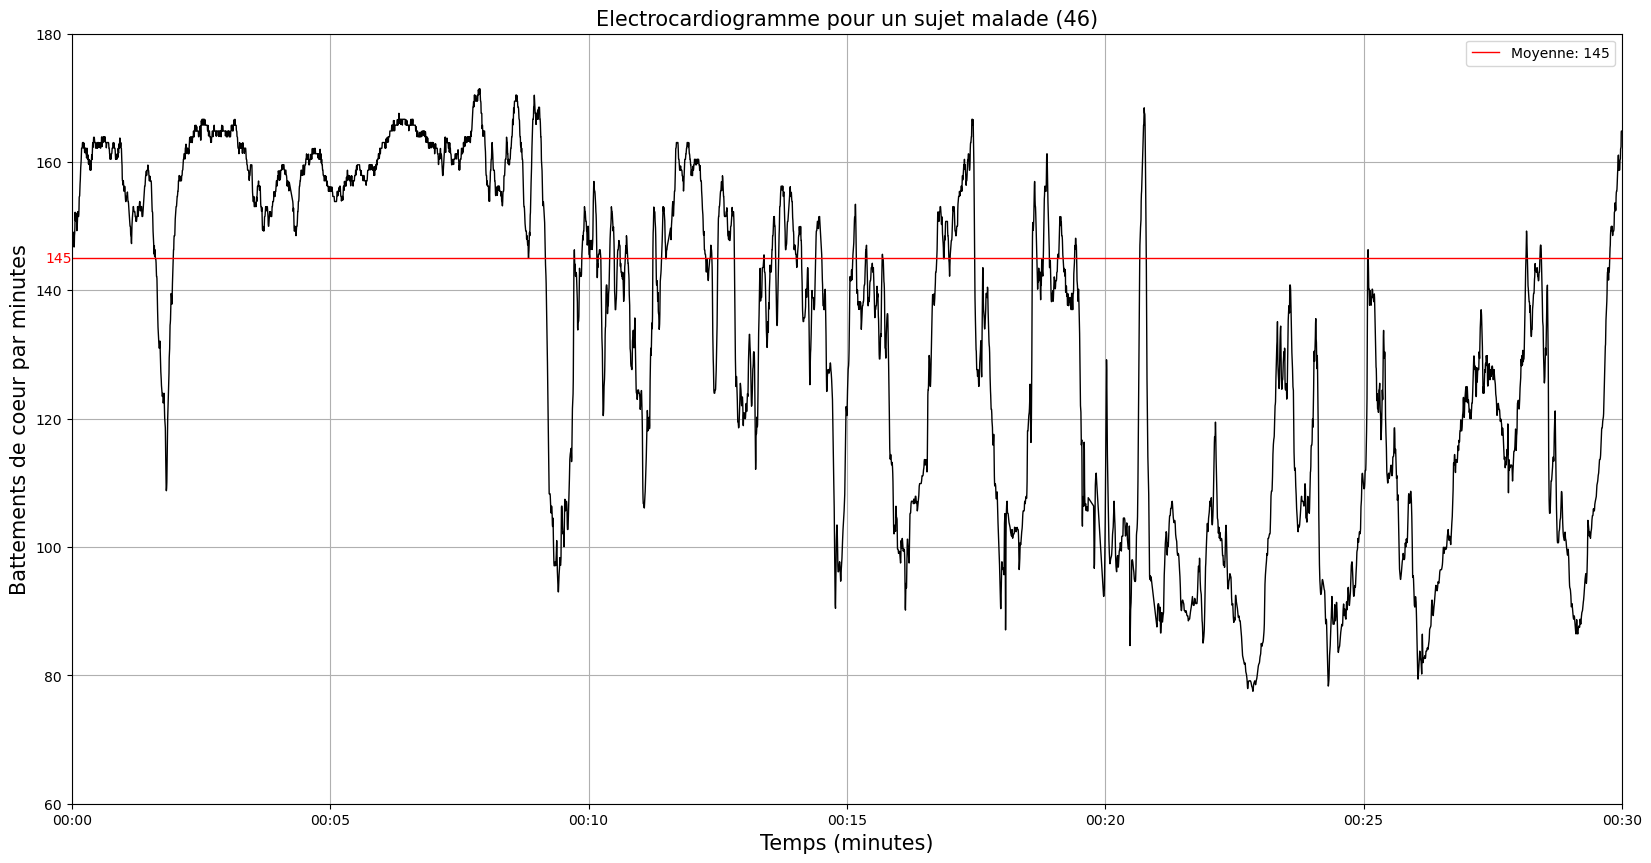

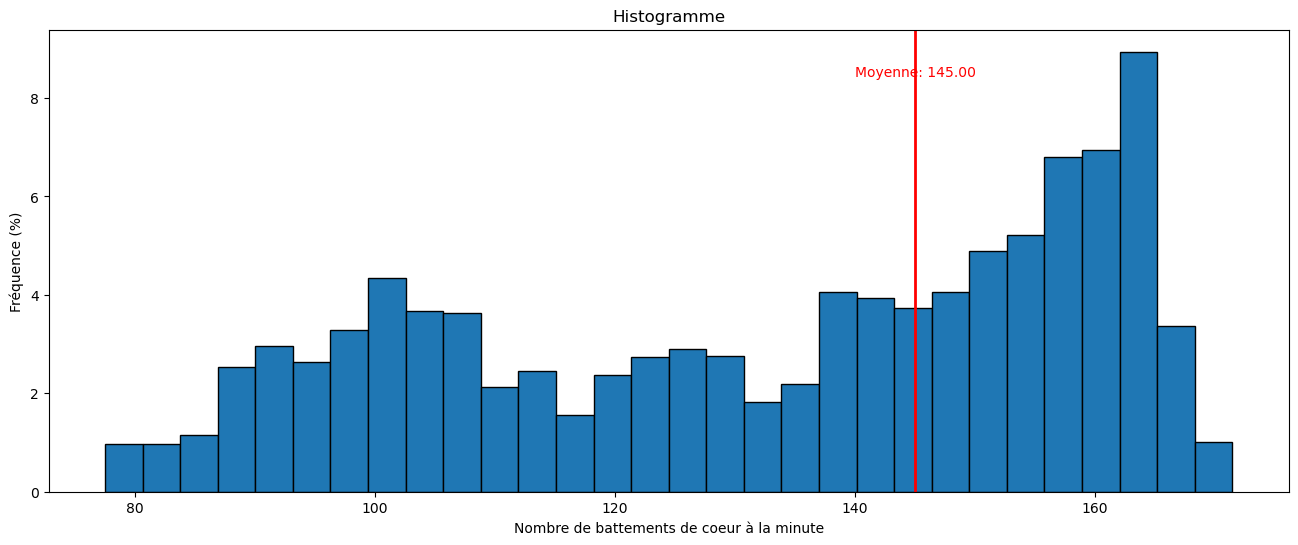

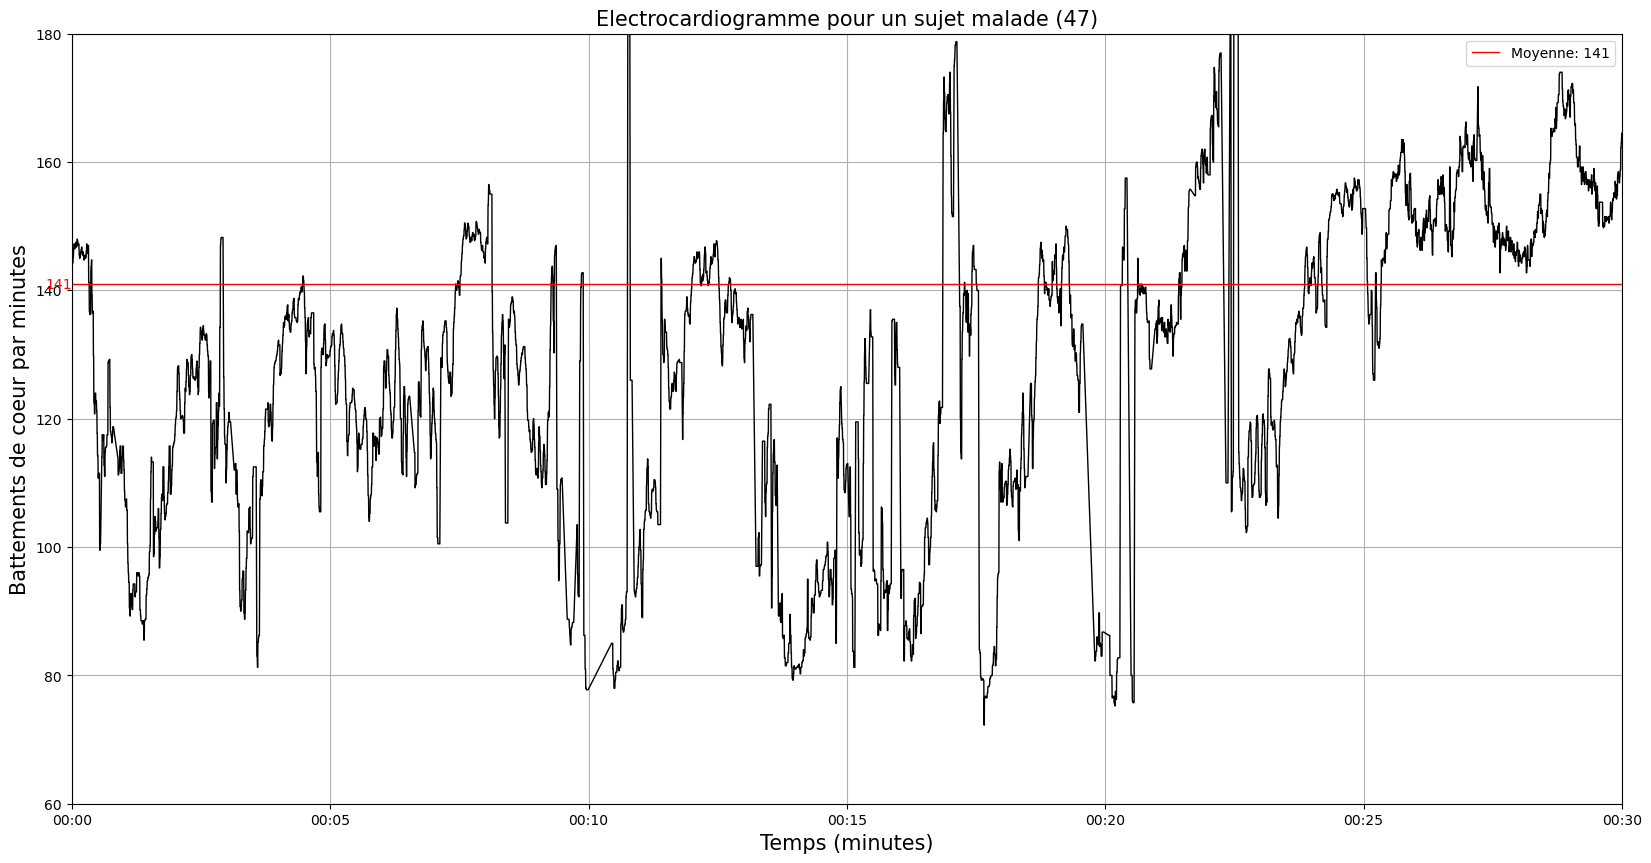

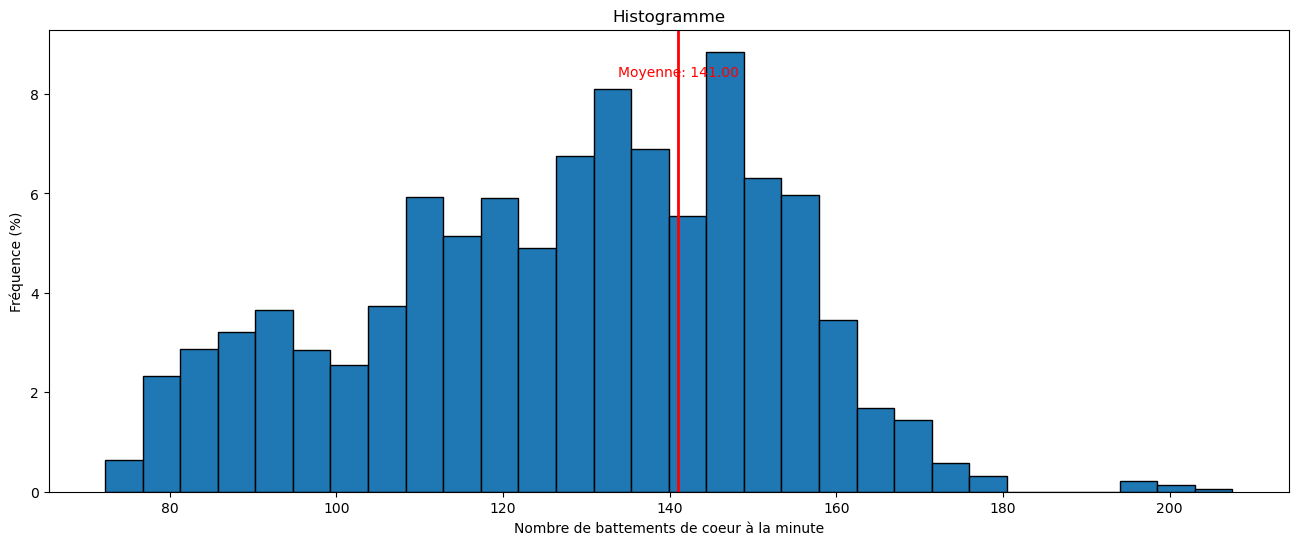

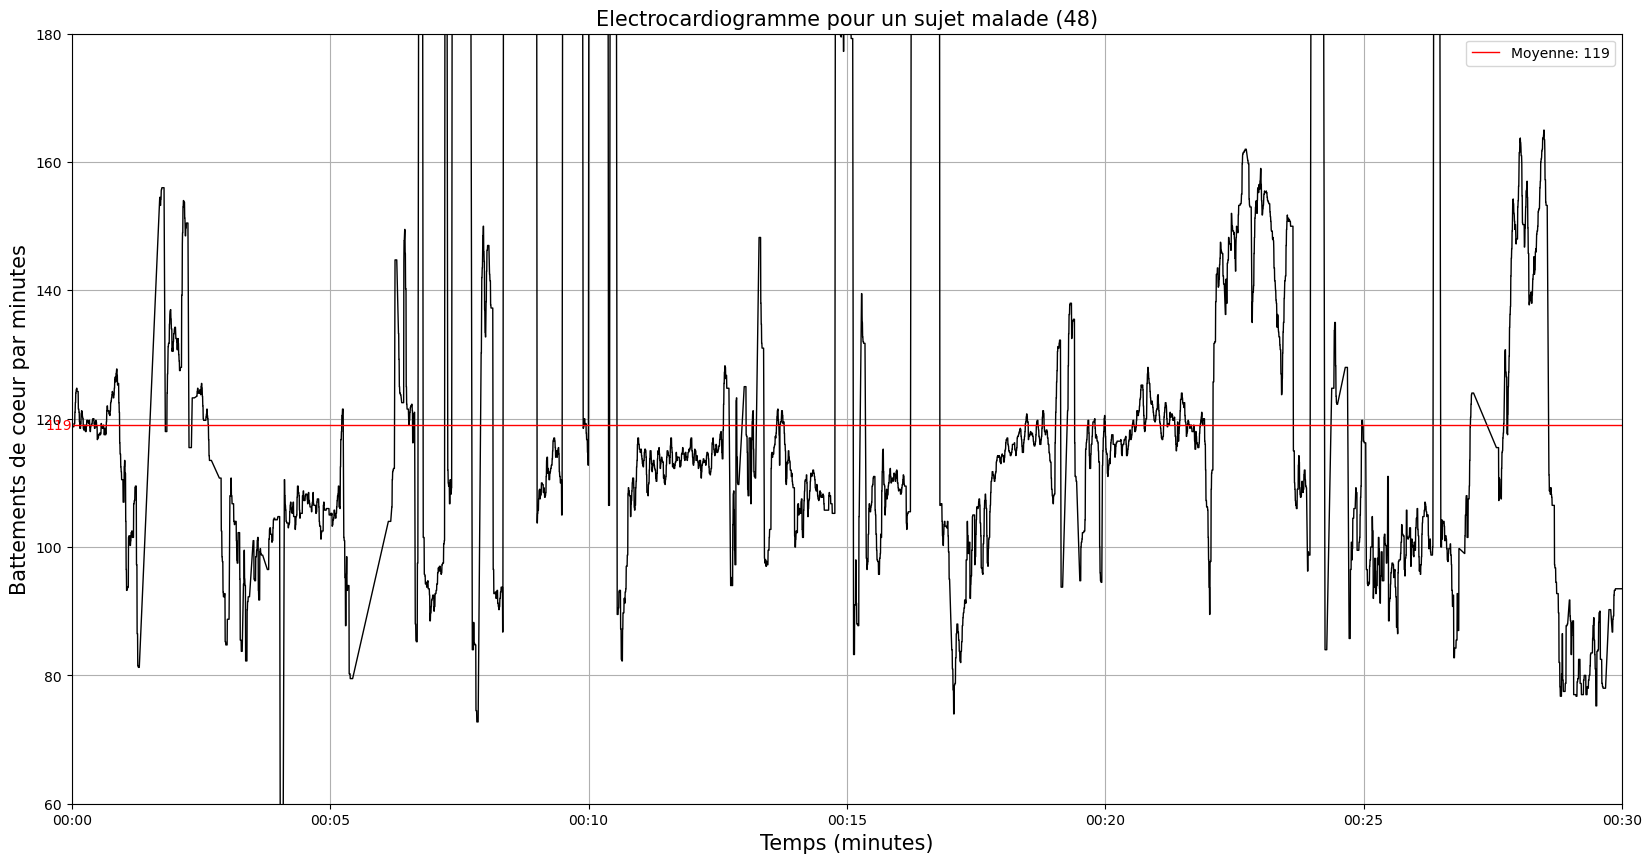

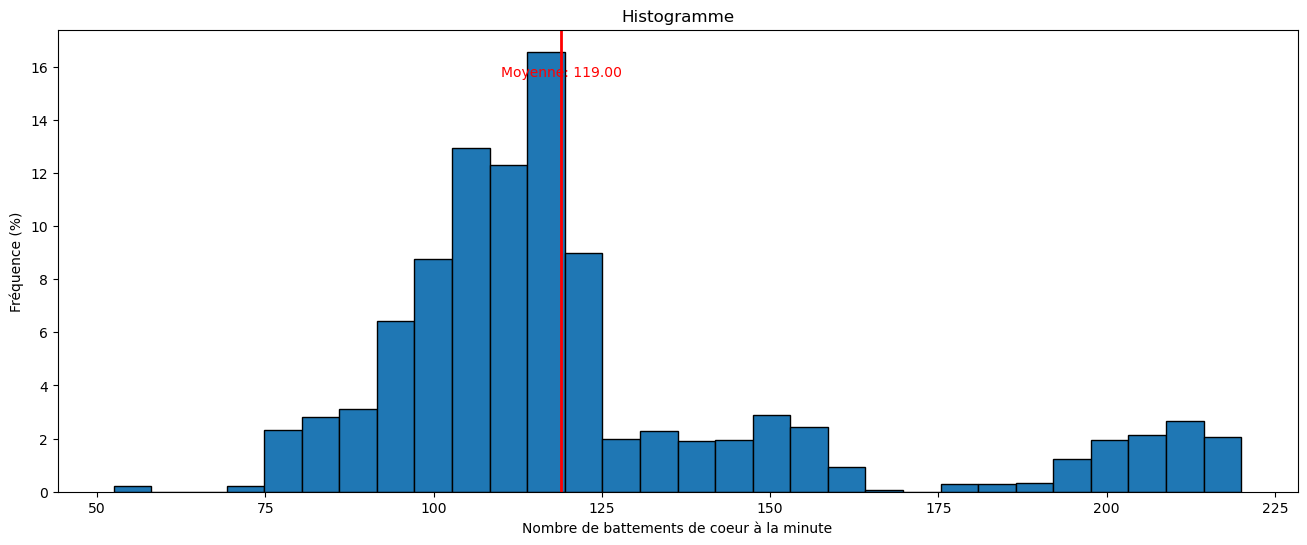

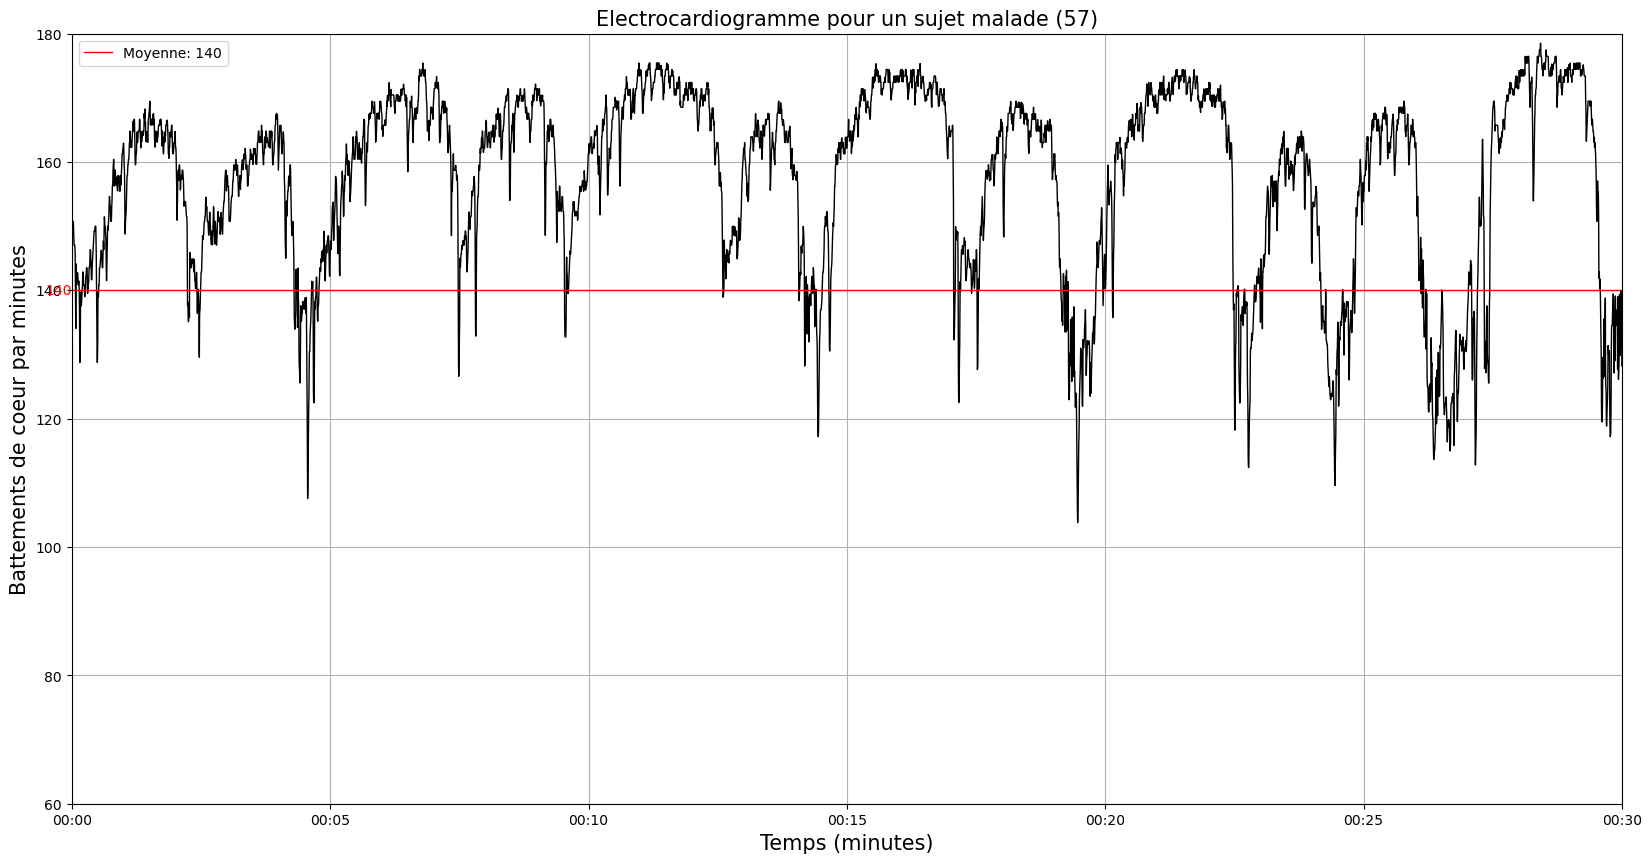

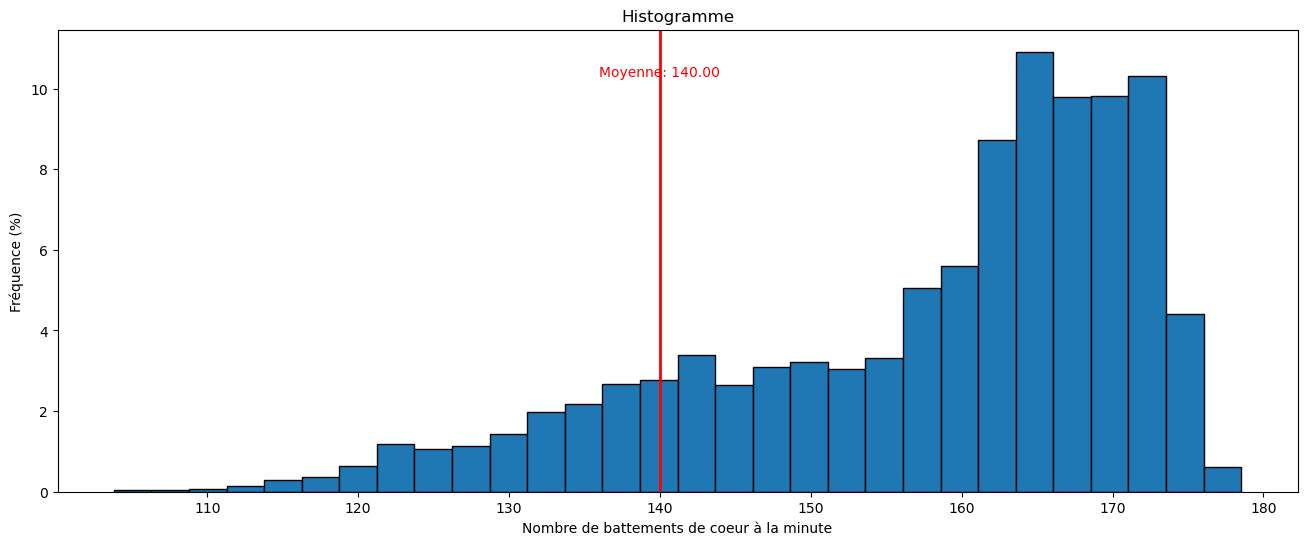

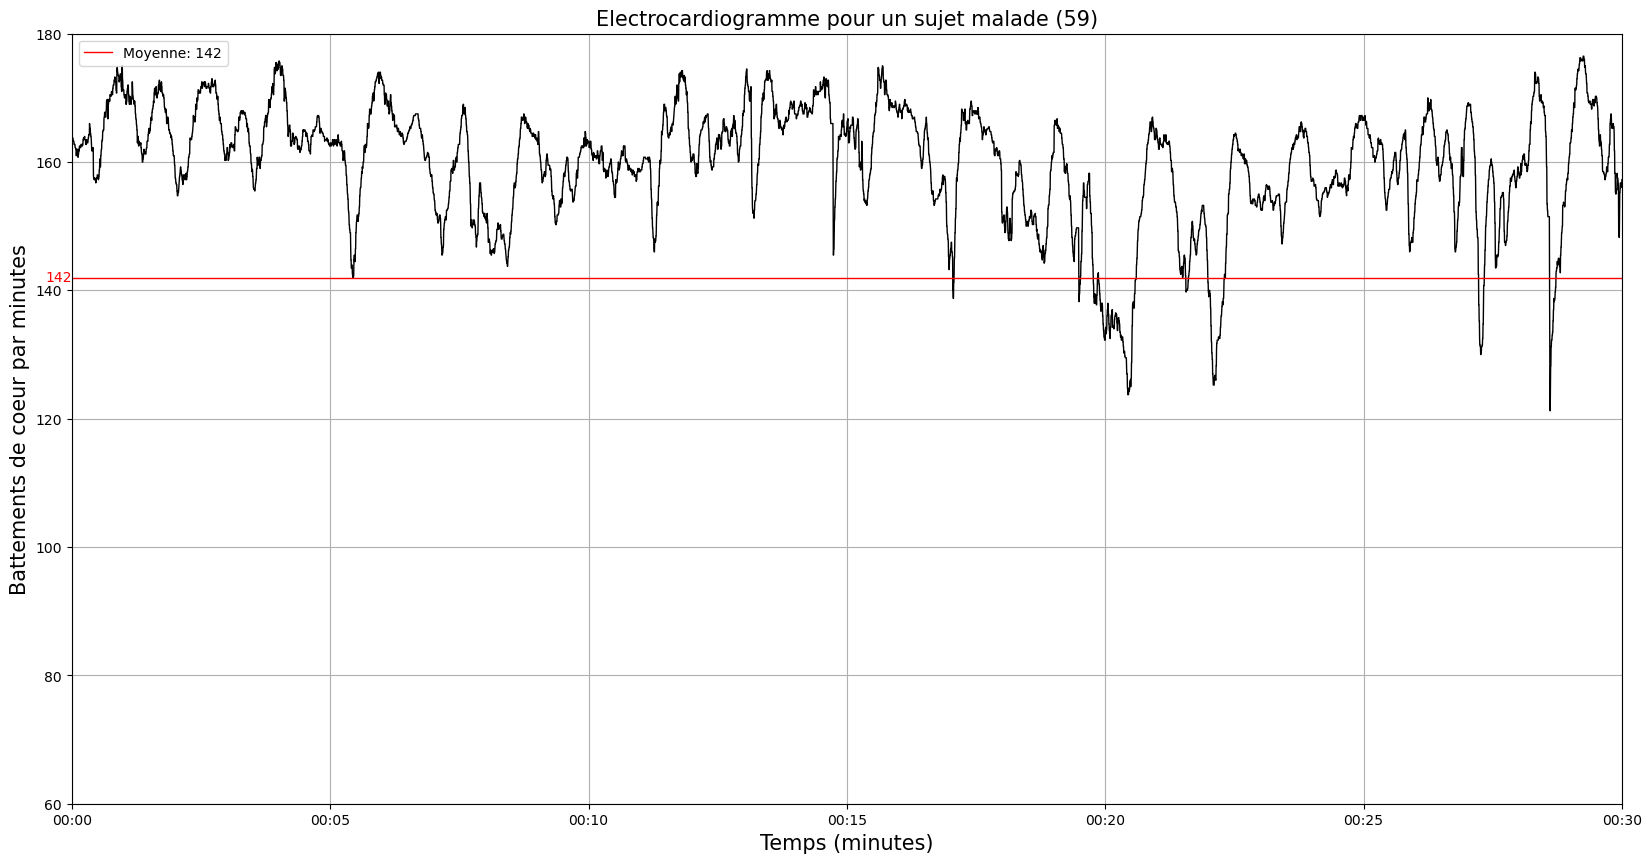

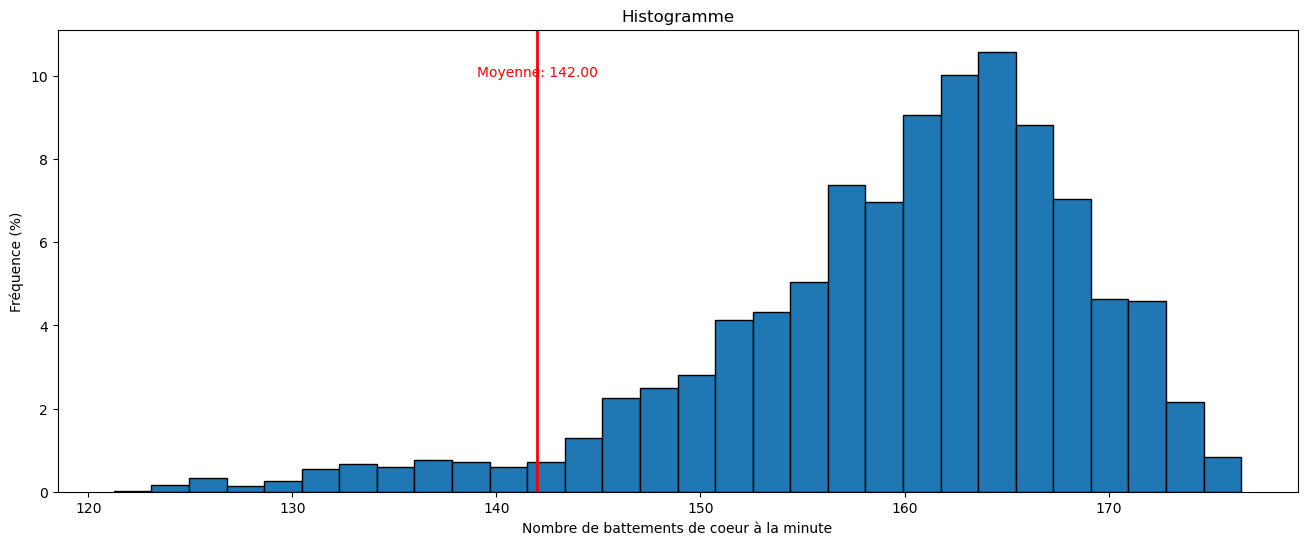

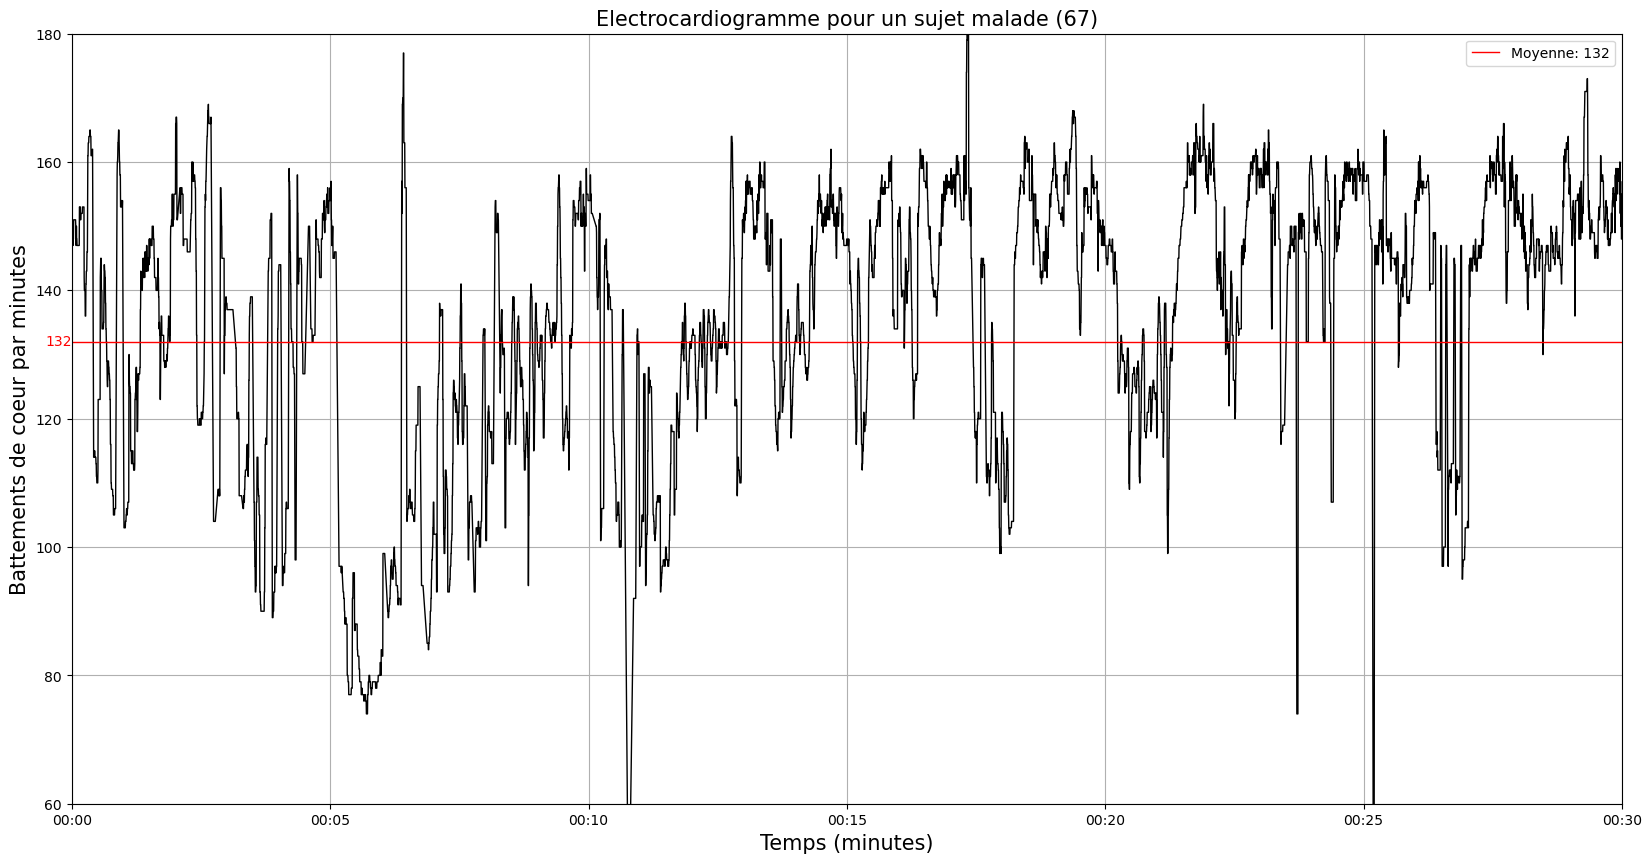

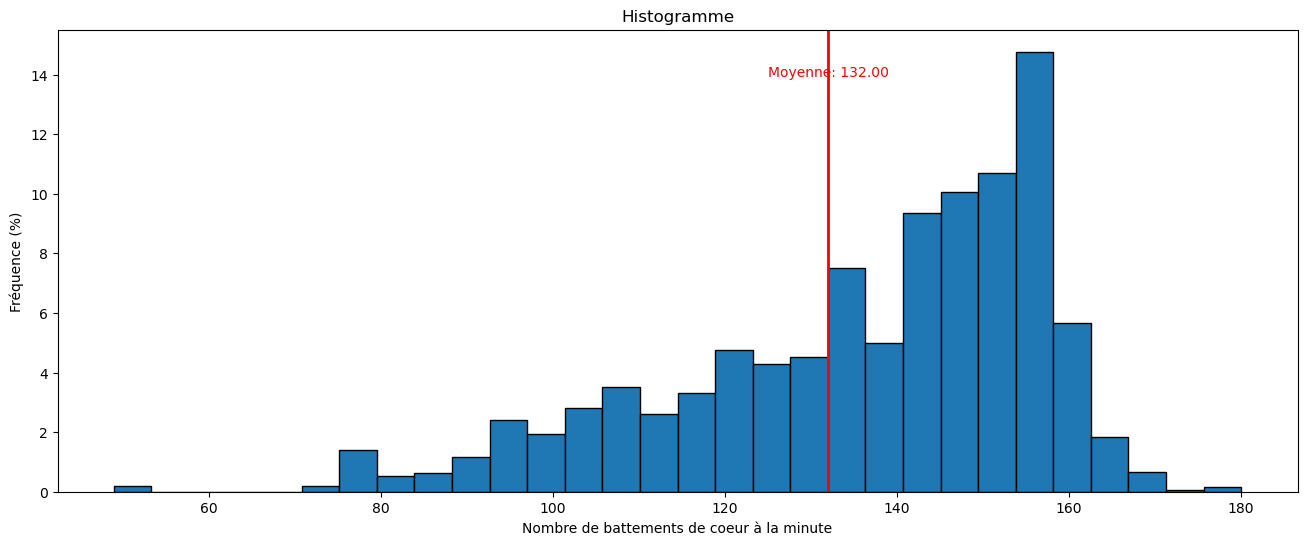

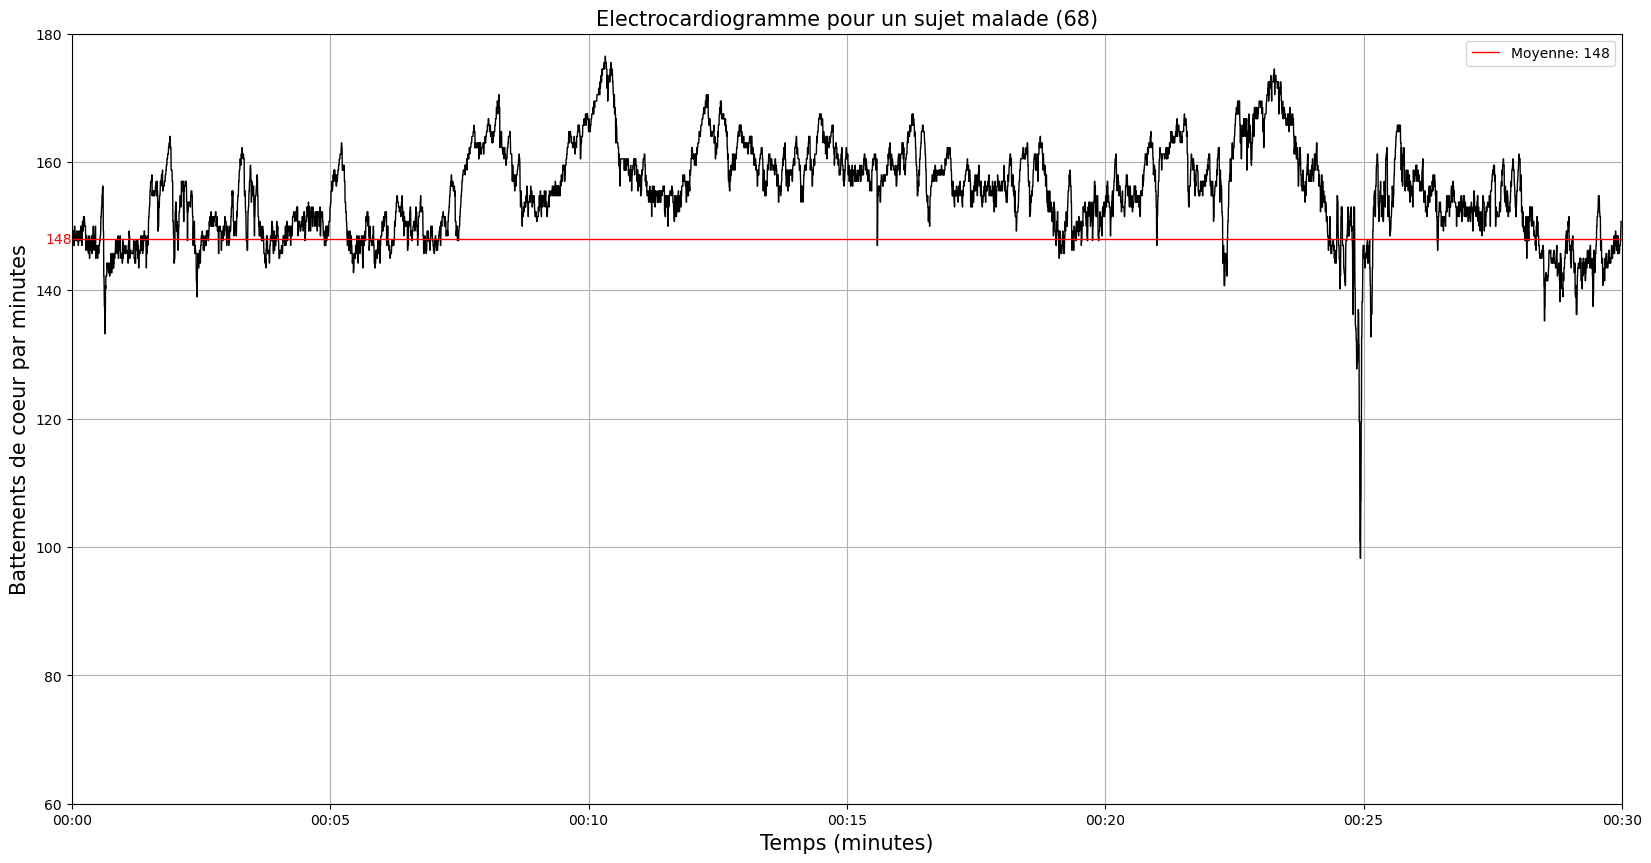

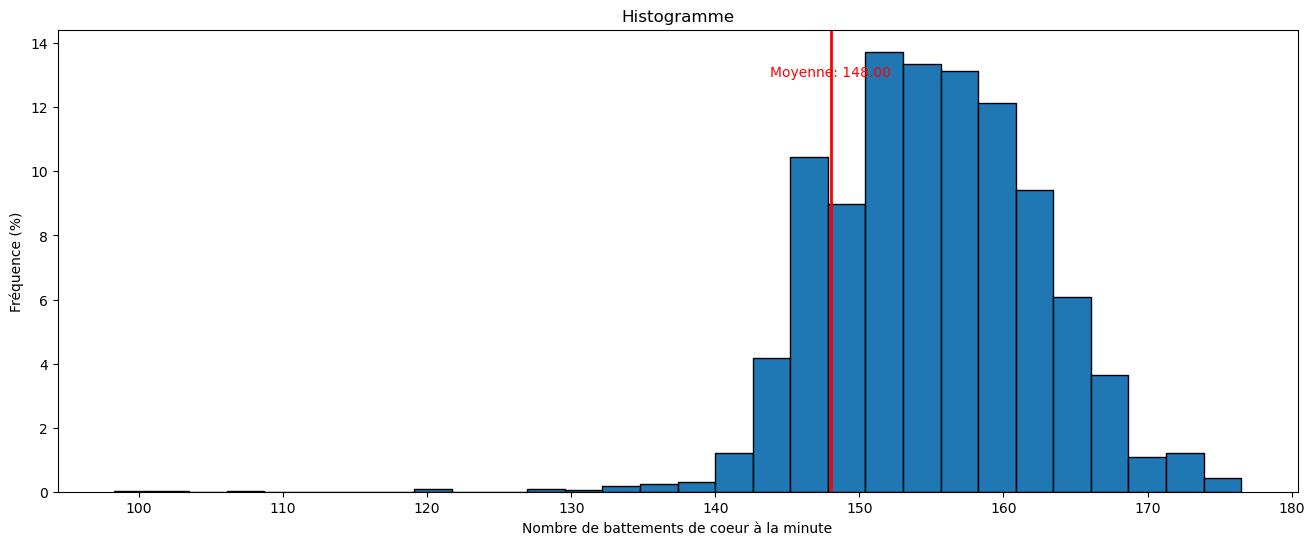

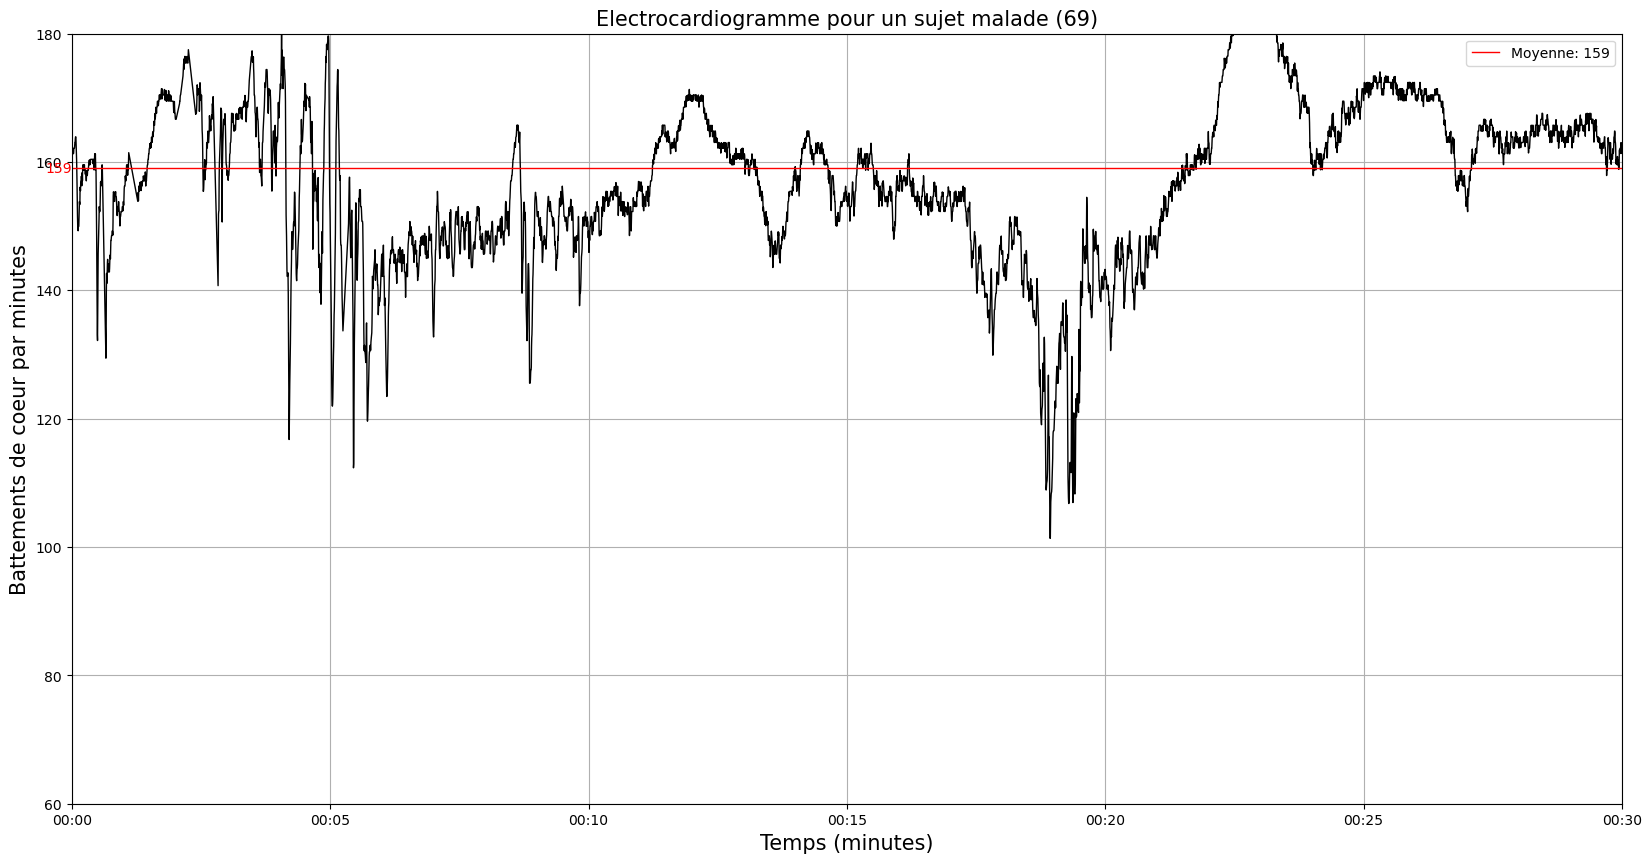

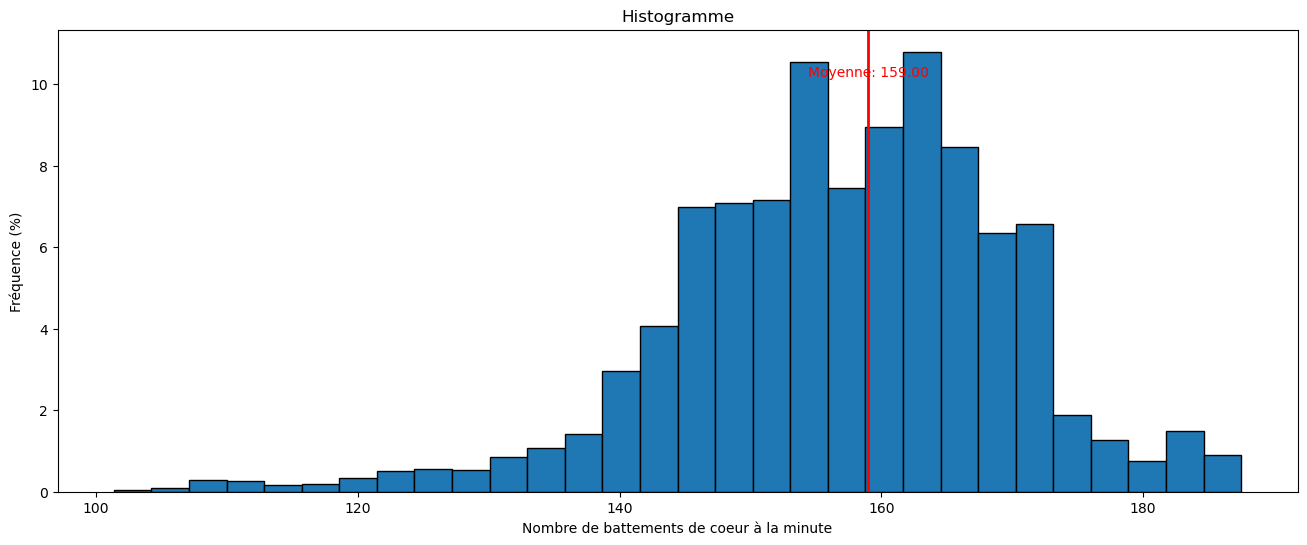

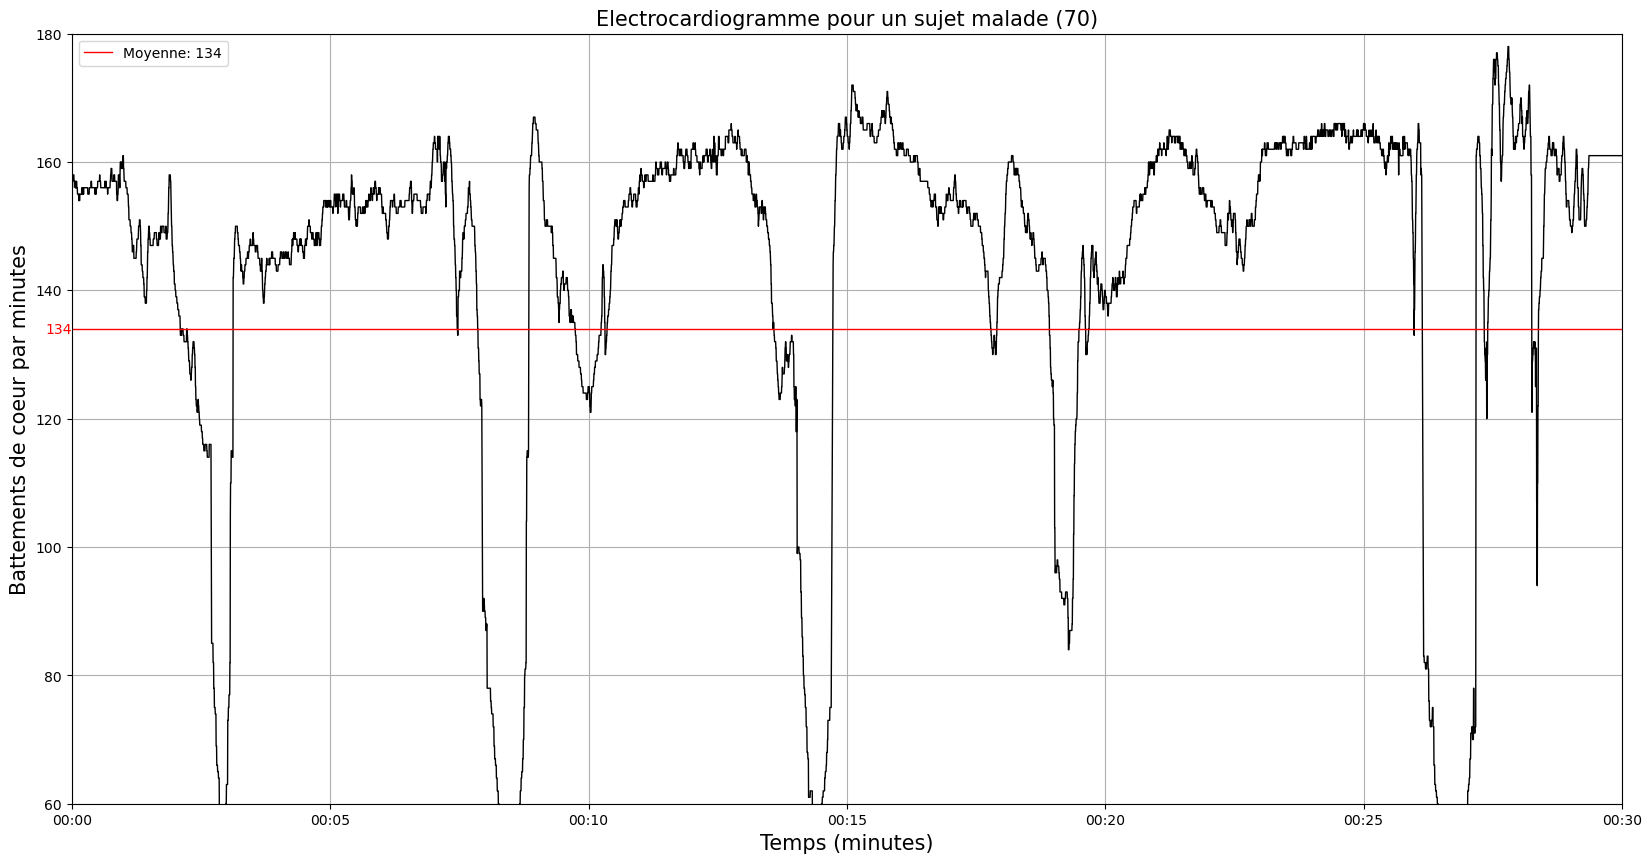

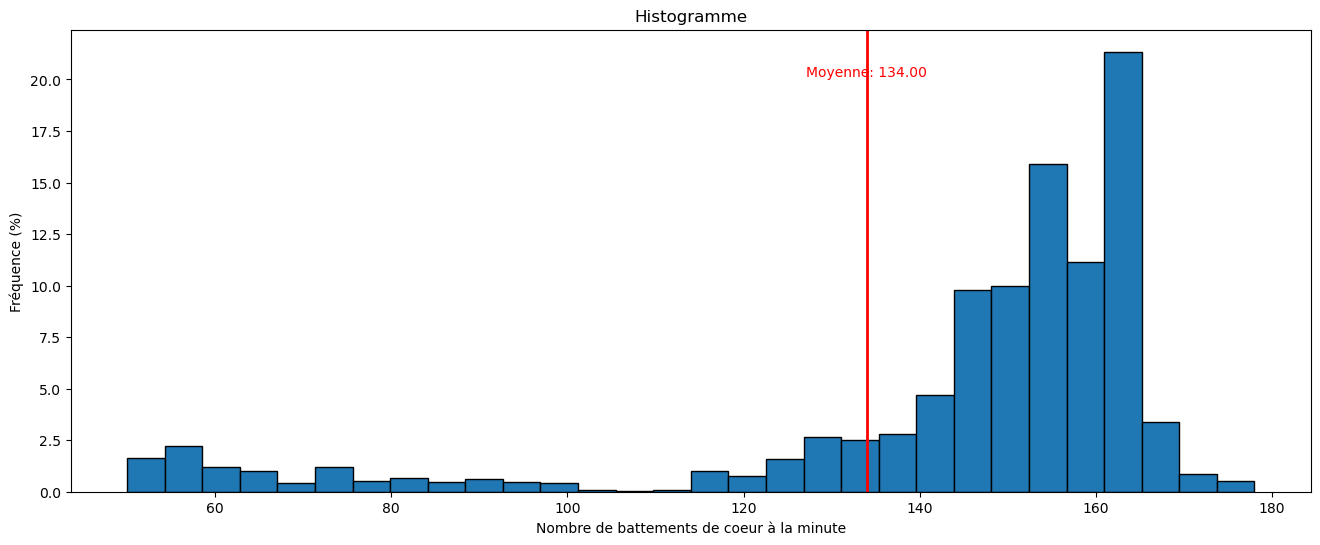

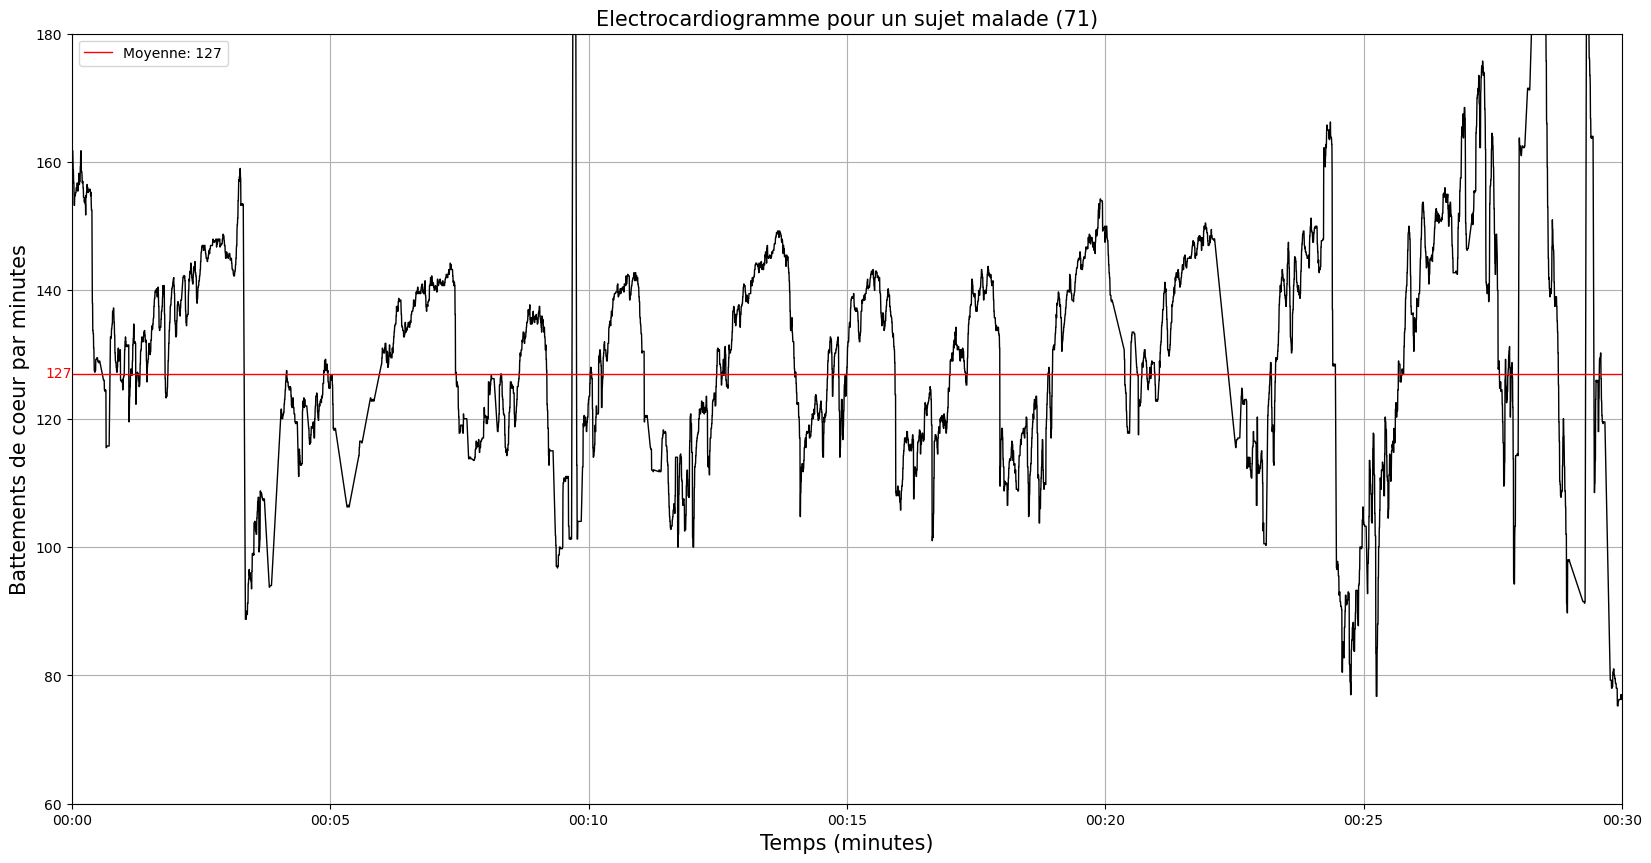

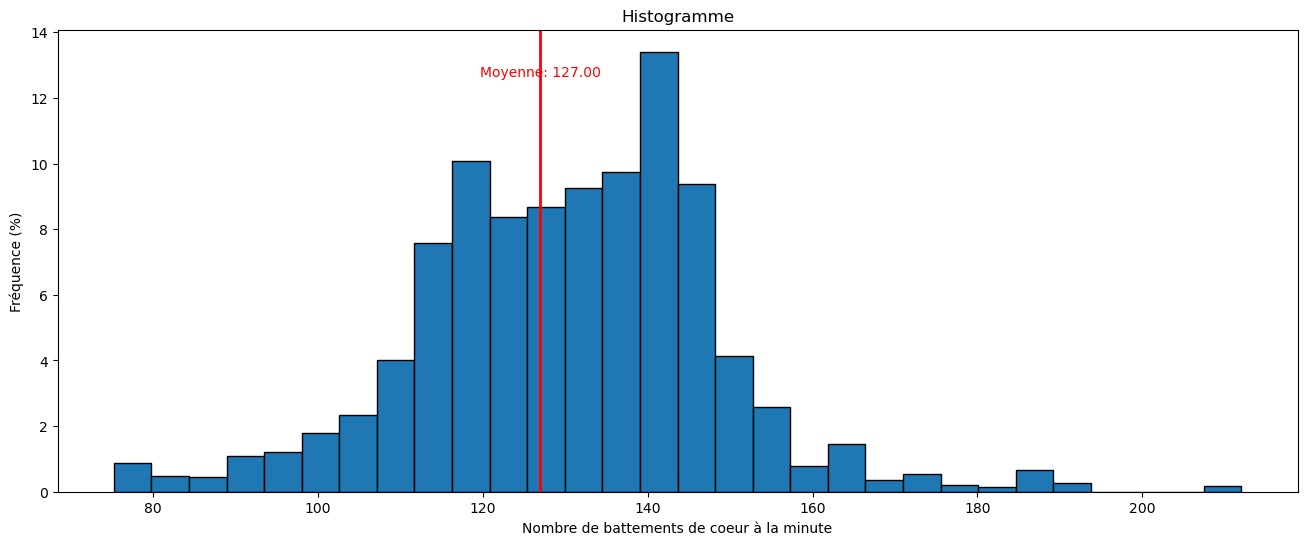

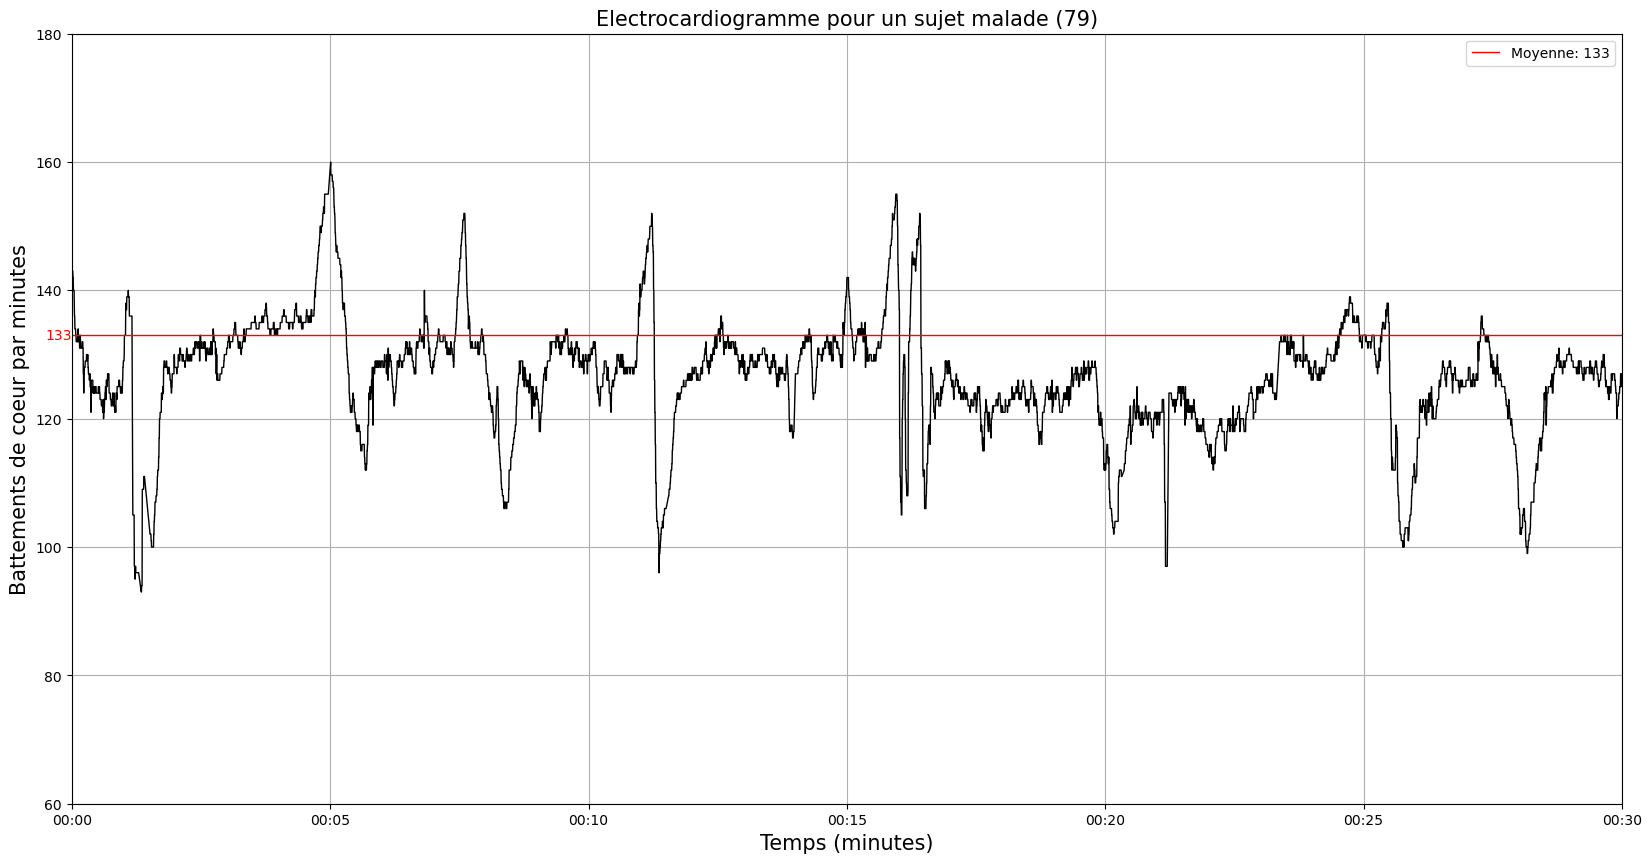

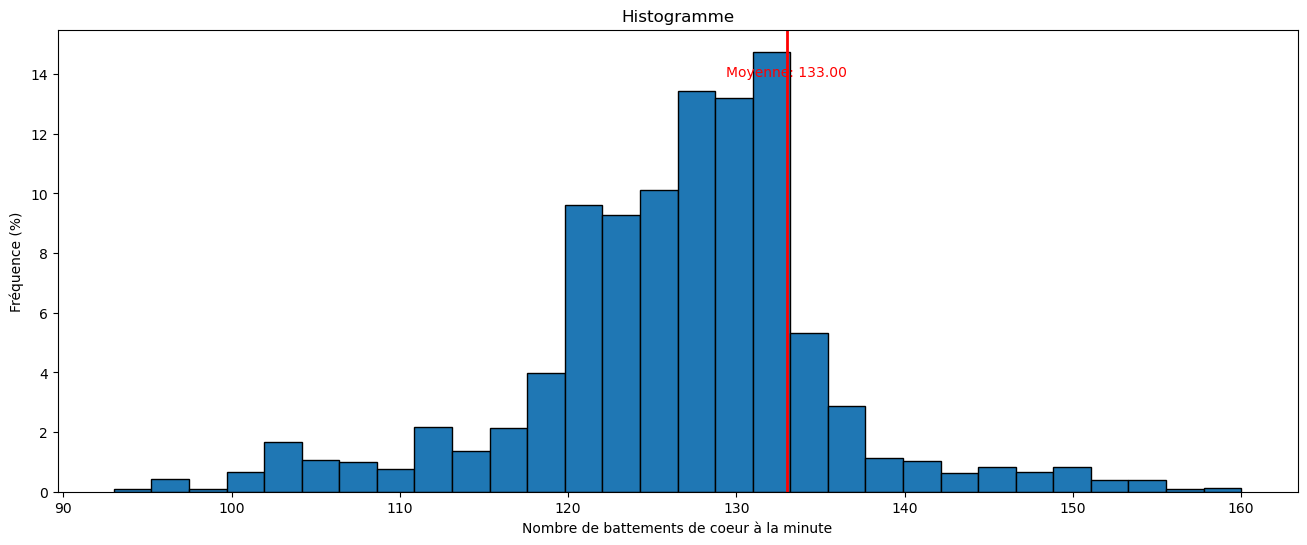

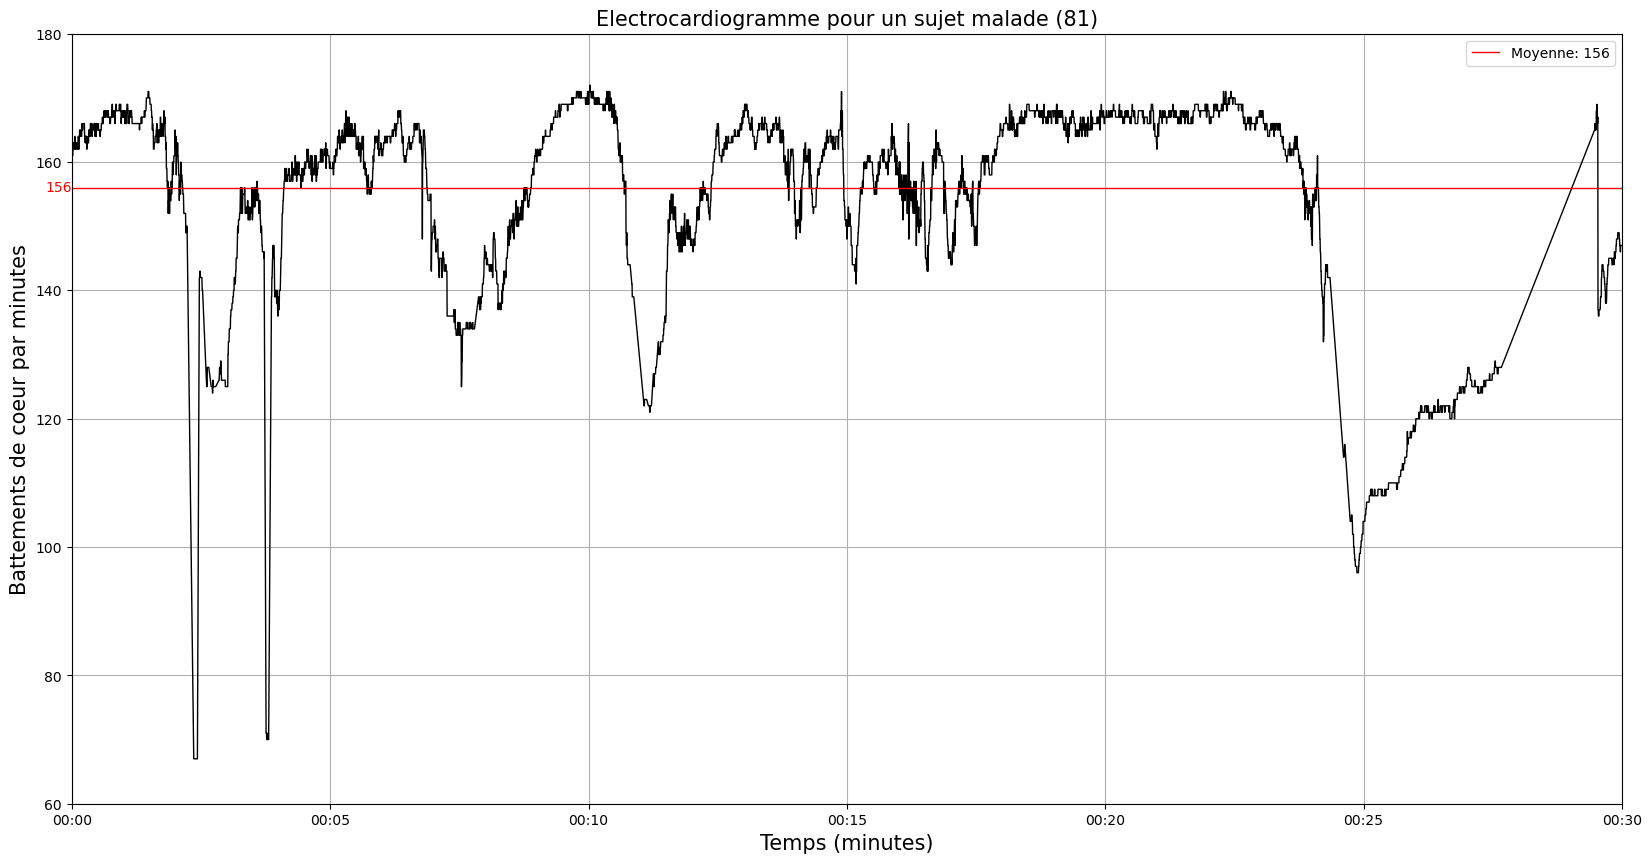

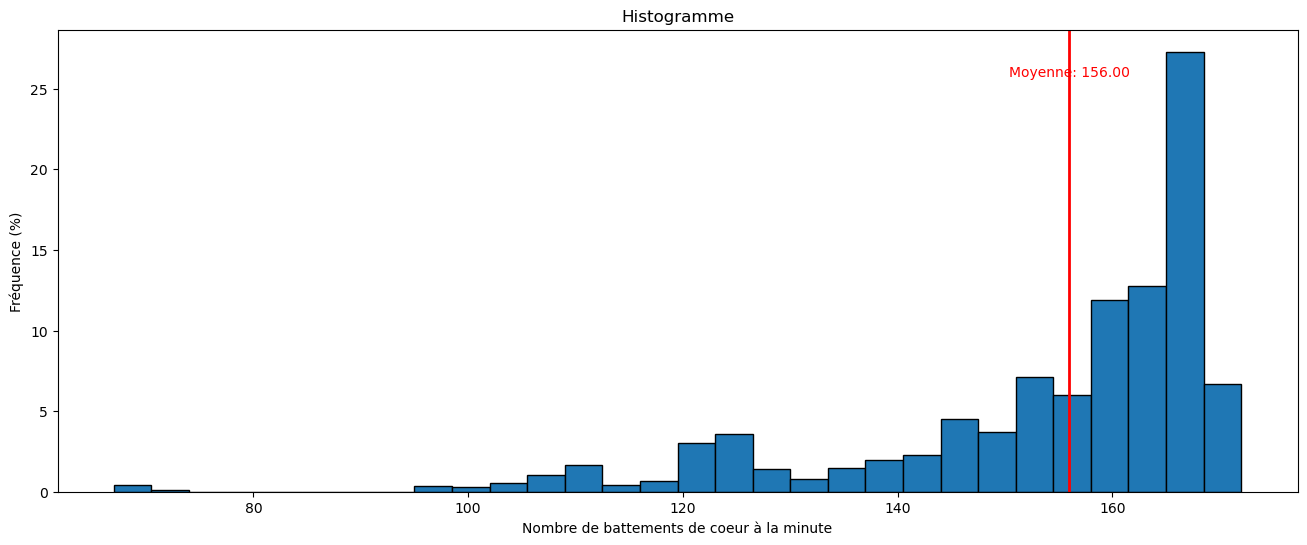

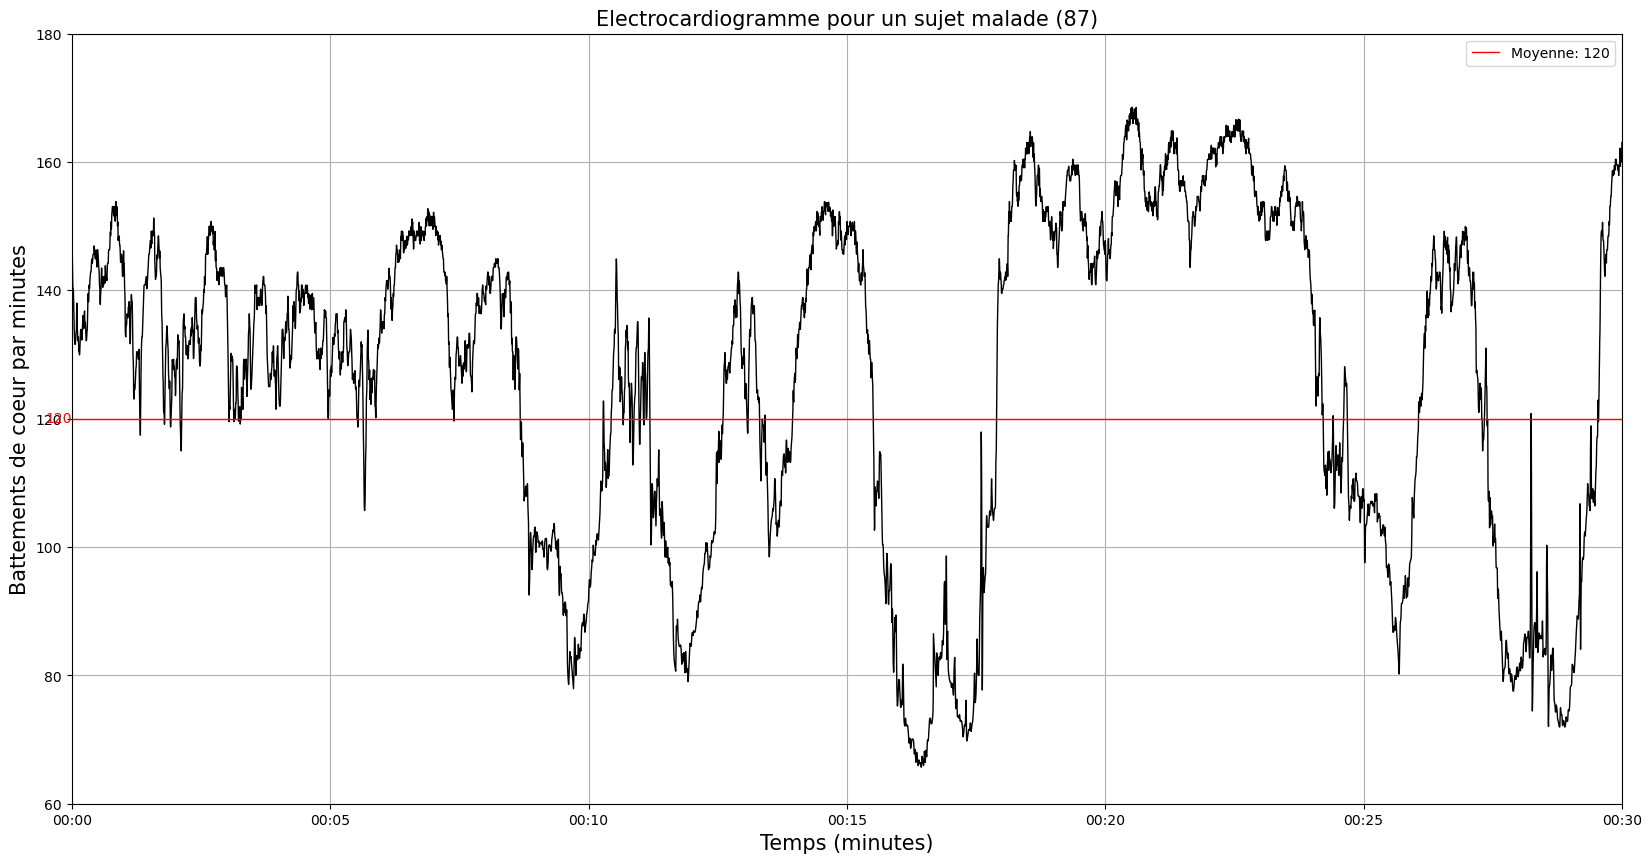

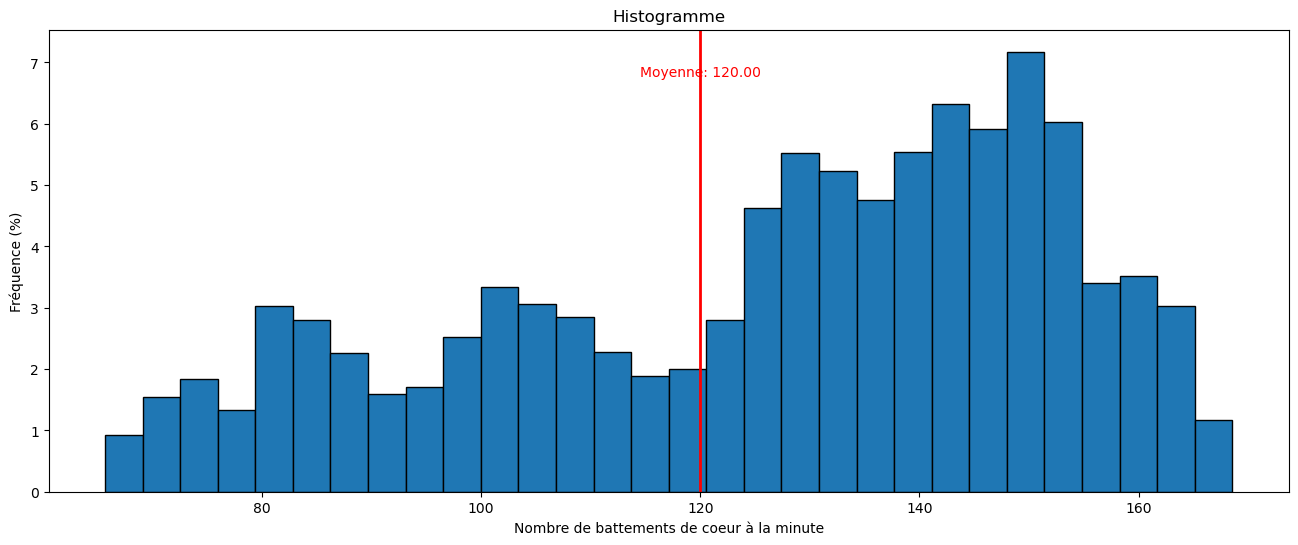

In [6]:
nombre_a_afficher = 20
start_minut = -60
duration_in_minuts = 30
label = 1  #0 pour les sujets sains , 1 pour les sujets malades
start_id = 1 # id du 1er élément à afficher


display_electrocardiograms(nombre_a_afficher, start_minut, duration_in_minuts, label, start_id, display_mean=True)

# PRIVE: Liste des caractéristiques

In [7]:
import functools

# calcul de l'écart type
@functools.lru_cache(maxsize=None)
def compute_id_std_dev_last_hour(id: int):
    return ecart_type(id_to_fhr_last_hour[id])

# calcul de la variance
@functools.lru_cache(maxsize=None)
def compute_id_variance_last_hour(id: int) -> float:
    std_dev = compute_id_std_dev_last_hour(id)
    return std_dev*std_dev

# calcul de l'etendue de la séquence associée à l'id 'id' en ignorant les NaN
@functools.lru_cache(maxsize=None)
def compute_id_range_last_hour(id: int):
    data = id_to_fhr_last_hour[id]
    return np.nanmax(data)-np.nanmin(data)

# calcul de l'écart interquartile (en ignorant les NaN)
@functools.lru_cache(maxsize=None)
def compute_id_interquartile_range_last_hour(id: int) -> float:
    (Q1,Q2,Q3) = compute_quartiles_Q1_Q2_Q3(id_to_fhr_last_hour[id])
    return Q3-Q1

# caracteristique 3: sujet sain si l'étendue est inférieure à un seuil.
def calcul_caracteristique3(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_range_last_hour(id)< hyperparameters['seuil_'+suffix] else 1

# caracteristique 7A: sujet sain si l'écart-type est inférieur à un seuil.
def calcul_caracteristique7A(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_std_dev_last_hour(id) < hyperparameters['seuil_'+suffix] else 1

# caracteristique 7C: sujet sain si la variance est inférieure à un seuil.
def calcul_caracteristique7C(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_variance_last_hour(id) < hyperparameters['seuil_'+suffix] else 1

# caracteristique 15: sujet sain si l'écart interquartile est inférieur à un seuil
def calcul_caracteristique15(id: int, hyperparameters: dict, suffix: str) -> int:
    return 0 if compute_id_interquartile_range_last_hour(id) < hyperparameters['seuil_'+suffix] else 1


# PRIVE: Hyperparameters Management

In [8]:
import numpy as np
from sklearn.metrics import f1_score
import math
from hyperopt import fmin, tpe, space_eval, hp, Trials, rand as hyperopt_rand
import hashlib
import random
import time
import sys

current_lowest_error = None
stats_hpo = dict()
last_time_display_stats_hpo = time.time()

def compute_error(TP: int, TN: int, FP: int, FN: int):
    return (compute_error_target0(TP,TN,FP,FN)+compute_error_target1(TP,TN,FP,FN))/2

def compute_f1_score(TP: int, TN: int, FP: int, FN: int):
    return (2*TP)/(2*TP+FP+FN)
        
def compute_error_target0(TP: int, TN: int, FP: int, FN: int):
    return 1.0-TN/(1*TN+FP)

def compute_error_target1(TP: int, TN: int, FP: int, FN: int):
    return 1.0-TP/(1*TP+FN)
        
def compute_matrice_de_confusion(id_to_predictions, id_to_target) -> (int, int, int,int):
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for id, data in id_to_predictions.items():
            target = id_to_target[id]
            prediction = id_to_predictions[id]
            if prediction == target: # bonne prediction
                if target == 1:
                    TP += 1
                else:
                    TN += 1
            else: # erreur dans la prediciton
                if prediction == 1:
                    FP += 1
                else:
                    FN += 1
        return (TP,TN,FP,FN)

def compute_single_prediction_single_caracteristique(id: str, hyperparameters: dict, caracteristique: str) -> int:  
    if caracteristique[-1:] == 'i':
        # we compute the complement of caracteristique 'caracteristique[:-1]'
        # ex: caracteristique '10i' will compute the complement of caracteristique '10'
        return 1-globals()['calcul_caracteristique'+caracteristique[:-1]](id, hyperparameters, caracteristique)
    return globals()['calcul_caracteristique'+caracteristique](id, hyperparameters, caracteristique)

def compute_single_prediction(id: str, hyperparameters: dict) -> int:  
    valeurs_caracteristiques_a_utiliser = []
    for c in hyperparameters['caracteristiques_a_utiliser'].split('+'):
        valeurs_caracteristiques_a_utiliser.append(compute_single_prediction_single_caracteristique(id, hyperparameters, c))
    if not all_elements_same(valeurs_caracteristiques_a_utiliser):
        return hyperparameters['label_si_resultats_differents']
    return valeurs_caracteristiques_a_utiliser[0]
    
def all_elements_same(data):
    first_element = data[0]
    return all(element == first_element for element in data)

def compute_toutes_les_predictions(hyperparameters: dict) -> dict:
    id_to_predictions = dict()
    for id in id_to_fhr_last_hour.keys():
        id_to_predictions[id] = compute_single_prediction(id, hyperparameters)
    return id_to_predictions
    
def train(hyperparameters: dict, verbose: bool) -> dict:
    id_to_predictions = compute_toutes_les_predictions(hyperparameters)
    (TP,TN,FP,FN) = compute_matrice_de_confusion(id_to_predictions, id_to_target)
    metrics = dict()
    metrics['TP'] = TP
    metrics['TN'] = TN
    metrics['FP'] = FP
    metrics['FN'] = FN
    metrics['error_target0'] = compute_error_target0(TP,TN,FP,FN)
    metrics['error_target1'] = compute_error_target1(TP,TN,FP,FN)
    current_error = compute_error(TP,TN,FP,FN)
    metrics['erreur'] = current_error
    update_stats_hpo(current_error, hyperparameters)
    global last_time_display_stats_hpo
    if (time.time()-last_time_display_stats_hpo)>600:
        save_stats_hpo(False)
        last_time_display_stats_hpo = time.time()
    global current_lowest_error
    if not current_lowest_error or current_error<current_lowest_error:
        current_lowest_error = current_error
        if verbose:
            print(f"new lowest error {round(current_error,4)} for hyperparameters {[c for c in hyperparameters.items() if c[1] is not None]}")
        save_model(hyperparameters, metrics)
        save_stats_hpo(False)
    return metrics

    
def update_stats_hpo(error:float, hyperparameters: dict) -> None:
    for hpo_key, hpo_value in hyperparameters.items():
        if hpo_value is None:
            continue
        if hpo_key not in stats_hpo:
            stats_hpo[hpo_key] = dict()
        if hpo_value not in stats_hpo[hpo_key]:
            stats_hpo[hpo_key][hpo_value] = [0,0]
        stats_hpo[hpo_key][hpo_value][0] += 1
        stats_hpo[hpo_key][hpo_value][1] += error

    
# the objective used for Hyperparameters Optimization (HPO)
# it is the function to minimize
def objective(sample_from_search_space):
    hyperparameters = fix_hyperparameters(sample_from_search_space)
    model_name = get_model_name(hyperparameters)
    if model_name in already_processed_model_names_with_hpo:
        metrics = already_processed_model_names_with_hpo[model_name]
    else:
        metrics = train(hyperparameters, True)
        already_processed_model_names_with_hpo[model_name] = metrics
    # we want to minimize this mettric ('erreur')
    return metrics['erreur']

hpo_session_id = str(int(100*time.time()))

def save_stats_hpo(display: bool):
    res = stats_hpo_to_str()
    try:
        path = os.path.join(directory, 'hpo_'+hpo_session_id+".txt")
        with open(path, 'w') as f:
            f.write(res)
    except Exception as e:
        print(f'failed to save hp')
    if display:
        print(res)

# path to the last model saved
last_path_for_save_model = None
        
def save_model(hyperparameters: dict, metrics: dict) -> None:
    global last_path_for_save_model
    try:
        erreur = metrics['erreur']
        path = os.path.join(directory, 'hpo_'+hpo_session_id+'_'+hyperparameters['caracteristiques_a_utiliser']+'_'+str(erreur)+".txt")
        with open(path, 'w') as f:
            text = hyperparameters_to_str(hyperparameters)
            for m, v in metrics.items():
                text += f'\n#{m}={v}'
            f.write(text)
        try:
            if last_path_for_save_model and os.path.isfile(last_path_for_save_model):
                os.remove(last_path_for_save_model)
        except Exception as e:
            print(f'failed to delete file {last_path_for_save_model}: {e}')
        last_path_for_save_model = path
    except Exception as e:
        print(f'failed to save hp: {e}')
    
def stats_hpo_to_str() -> str:
    max_intervals = 10
    result = ""
    for hpo_key, hpo_key_stats in stats_hpo.items():
        result += f"stats for key '{hpo_key}':\n"
        all_values = list(hpo_key_stats.keys())
        old_value_to_new_value = dict()
        if len(all_values)>max_intervals and (isinstance(all_values[0], int) or isinstance(all_values[0], float)):
            min_value = float(min(all_values))
            max_value = float(max(all_values))
            for v in all_values:
                index_interval = int (max_intervals * (float(v-min_value)/(max_value-min_value)))
                index_interval = min(index_interval, max_intervals-1)
                min_value_interval = min_value+index_interval* (max_value-min_value)/max_intervals
                max_value_interval = min_value_interval+ (max_value-min_value)/max_intervals
                new_key = f'[{round(min_value_interval,2)}, {round(max_value_interval,2)}]'
                if new_key not in old_value_to_new_value:
                    old_value_to_new_value[new_key] = [0,0]
                old_value_to_new_value[new_key][0] += hpo_key_stats[v][0]
                old_value_to_new_value[new_key][1] += hpo_key_stats[v][1]
        else:
            for v in all_values:
                old_value_to_new_value[v] = hpo_key_stats[v]     
        
        for value, value_stats in sorted(old_value_to_new_value.items(), key=lambda item: item[1][1]/item[1][0], reverse=True):
            count = value_stats[0]
            avg_error = value_stats[1]/count
            result += f'\t{value} : {avg_error} ({count} samples)\n'
    return result
        
def extract_caracteristique_id(key: str):
    if key == 'caracteristiques_a_utiliser' or key == 'label_si_resultats_differents':
        return None
    splitted = key.split('_')
    if len(splitted)>=2 and len(splitted[-1]) >=1 and splitted[-1][0].isdigit():
        return splitted[-1]
    return None

# When conducting an HPO search, some hyperparameters may exhibit inconsistent values.
# This method aims to address those inconsistencies.
def fix_hyperparameters(hyperparameters: dict) -> dict :
    res = dict(hyperparameters)
    for key in list(res.keys()):
        caracteristique_id = extract_caracteristique_id(key)
        if caracteristique_id and caracteristique_id not in res['caracteristiques_a_utiliser'].split('+'):
            del res[key]
    if '+' not in res['caracteristiques_a_utiliser']:
        res['label_si_resultats_differents'] = None
    return res


# Transform the dictionary of hyperparameters 'hyperparameters' into string.
def hyperparameters_to_str(hyperparameters: dict) -> str:
    sorted_hyperparameters = sorted (hyperparameters.items())
    return "\n".join([hyperparameter_name+" = "+str(hyperparameter_value) for (hyperparameter_name,hyperparameter_value) in sorted_hyperparameters if hyperparameter_value is not None])

def get_model_name(hyperparameters: dict) -> str:
    file_content = hyperparameters_to_str(hyperparameters)
    return compute_hash(file_content, 10)

def compute_hash(input_string, max_length):
    # Calculate MD5 hash of the input string
    md5_hash = hashlib.md5(input_string.encode('ascii')).hexdigest().upper()
    # Return the hash truncated to the max_length
    return md5_hash[:max_length]

def launch_hpo_for_transformer_model(max_evals: int):
    seed = random.randint(0, 100000)
    print(f'using seed: {seed}')
    rstate = np.random.default_rng(seed)
    best_indexes = fmin(
        fn=objective,  # "Loss" function to minimize
        space=search_space,  # Hyperparameter space
        #algo=hyperopt_rand.suggest, #Random Search
        algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
        max_evals=max_evals,  # Perform 'max_evals' trials
        max_queue_len = 10,
        rstate =rstate,
    )

    # Get the best parameters
    best  = space_eval(search_space, best_indexes)
    print(f"Found minimum after {max_evals} trials:")
    print([c for c in best.items() if c[1] is not None])
    return best



def float_range(x1: float, x2: float, count:int = 100) -> List[float]:
    epsilon = (x2-x1)/count
    # Generate the range of float values with the specified step
    return list(np.arange(x1, x2, epsilon))

def int_range(x:int, y:int, count:int = 100) -> List[int]:
    epsilon = int ((y+1-x)/count )
    epsilon = max(epsilon, 1)
    return list(range(x, y+1,epsilon))



search_space = {

    # caracteristique 3: sujet sain si l'étendue est inférieure à un seuil.
    'seuil_3': hp.choice('seuil_3', int_range(50,200, 150)),

    # caracteristique 7A: sujet sain si l'écart type est inférieur à un seuil.
    'seuil_7A': hp.choice('seuil_7A', float_range(15.0, 25.0, 100)),
    
    # caracteristique 7C: sujet sain si la variance de est inférieure à un seuil.
    'seuil_7C': hp.choice('seuil_7C', int_range(400, 600, 200)),
    
    # caracteristique 15: sujet sain si l'écart interquartile est inférieur à un seuil
    'seuil_15': hp.choice('seuil_15', float_range(10, 50, 100)),

    'caracteristiques_a_utiliser': hp.choice('caracteristiques_a_utiliser', ['7C+15']),
    'label_si_resultats_differents': hp.choice('label_si_resultats_differents', [0, 1]),
}


if len(sys.argv) >=2 and str.isdigit(sys.argv[1][0]):
    caracteristiques_a_utiliser = sys.argv[1].split(',')
    print(f'caracteristiques_a_utiliser will be set to {caracteristiques_a_utiliser}')
    search_space['caracteristiques_a_utiliser'] =  hp.choice('caracteristiques_a_utiliser', caracteristiques_a_utiliser)


max_evals = 1000
if len(sys.argv) >=3 and str.isdigit(sys.argv[2]):
    print(f'max_evals will be set to {sys.argv[2]}')
    max_evals = int(sys.argv[2])
print(f'max_evals value is {max_evals}')

already_processed_model_names_with_hpo = dict()
start_time = time.time()
# Uncomment following line to enable HPO
#best = launch_hpo_for_transformer_model(max_evals)
print(f'hpo took {round(time.time()-start_time,2)}s')
save_stats_hpo(True)


max_evals value is 1000
hpo took 0.0s



<hr style="height:2px; border-width:0; color:black; background-color:black">
<span style="font-size: 48px;">1ère partie</span>
<hr style="height:2px; border-width:0; color:black; background-color:black">

## Faire constater par l'étudiant que l'étendue est plus importante pour les sujets malades que pour les sujets sains

In [9]:
def display_stats_etendue():
    etendue_target_0 =[]
    etendue_target_1 =[]
    for id in id_to_fhr_last_hour.keys():
        etendue = compute_id_range_last_hour(id)
        if 0 == id_to_target[id]:
            etendue_target_0.append(etendue)
        else:
            etendue_target_1.append(etendue)
    print(f"Valeur de l'étendue:")
    print(f'\tMoyenne pour les sujets sains = {round(np.mean(etendue_target_0),2)}')
    print(f'\tMoyenne pour les sujets malades = {round(np.mean(etendue_target_1),2)}')
display_stats_etendue()


Valeur de l'étendue:
	Moyenne pour les sujets sains = 116.23
	Moyenne pour les sujets malades = 130.95


# Affichage de la qualité de  l'outil en fonction de la valeur de la caractéristique: l'étendue.
## Au dessus de ce seuil, on considère que le sujet est malade

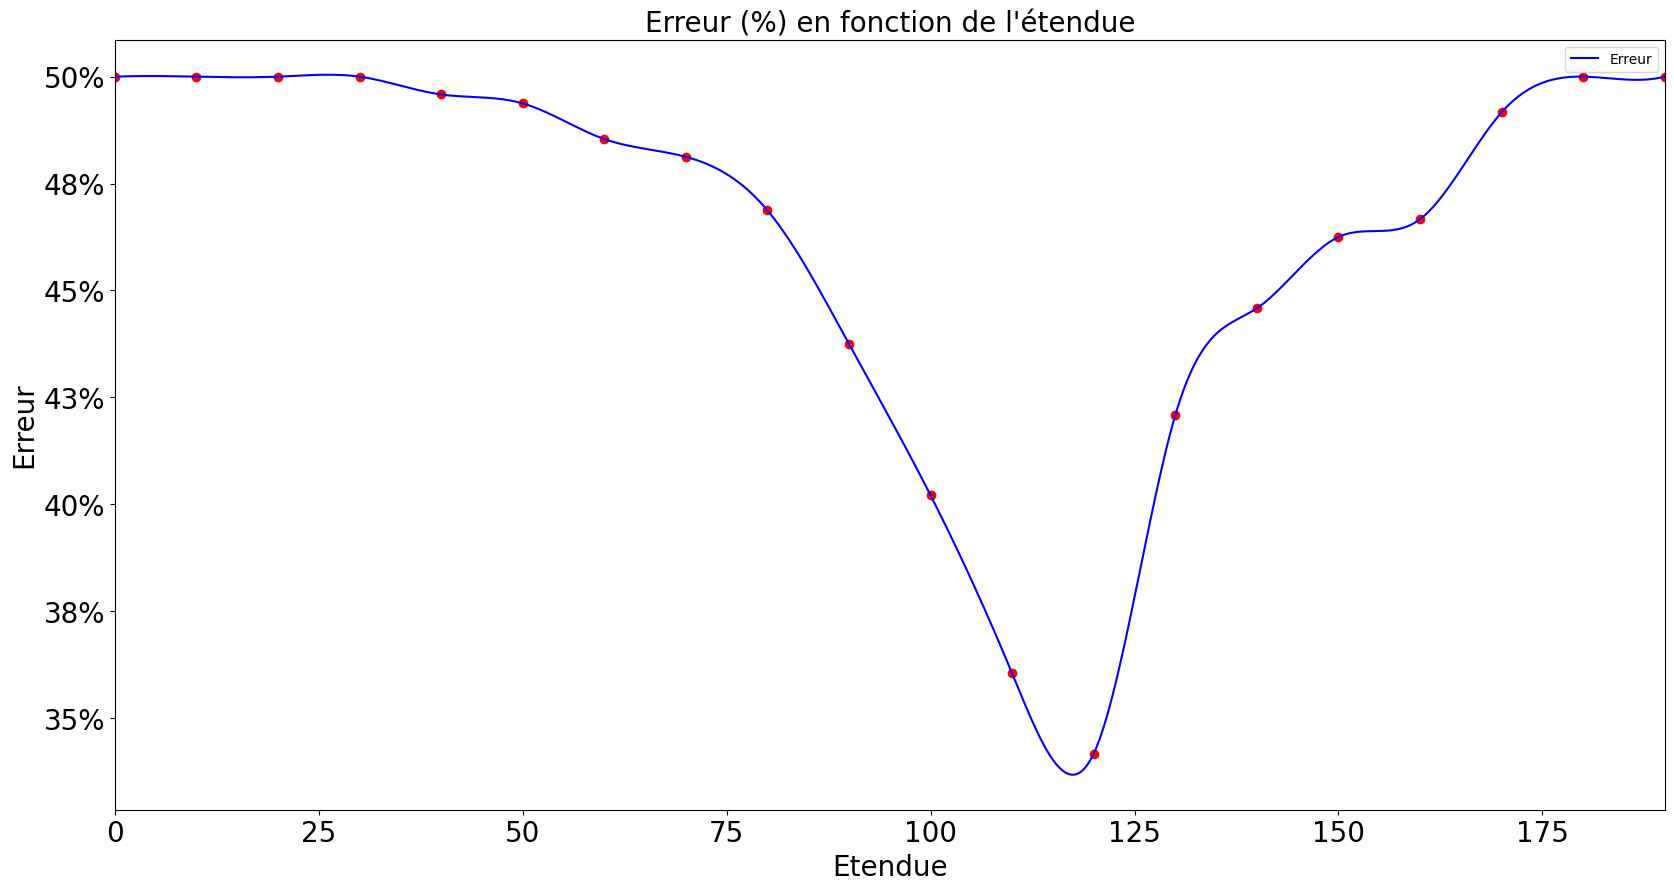

In [10]:
from scipy.interpolate import make_interp_spline
from matplotlib.ticker import PercentFormatter

valeurs_caracteristique = []
erreur_caracteristique = []
for seuil_etendue in range(0, 200, 10):
    config = {'caracteristiques_a_utiliser': '3', 'seuil_3': seuil_etendue}
    erreur = train(config, False)['erreur']
    valeurs_caracteristique.append(seuil_etendue)
    erreur_caracteristique.append(erreur)

x_dense = np.linspace(min(valeurs_caracteristique), max(valeurs_caracteristique), 500)  # 500 points pour une courbe lisse
spline = make_interp_spline(valeurs_caracteristique, erreur_caracteristique)
y_dense = spline(x_dense)

plt.figure(figsize=(20, 10))
plt.plot(x_dense, y_dense, label='Erreur', color='b')
plt.scatter(valeurs_caracteristique, erreur_caracteristique, color='r')
plt.gca().tick_params(axis='y', which='major', labelsize=20) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.xticks(fontsize=20)
plt.xlabel("Etendue", fontsize=20)
plt.ylabel('Erreur', fontsize=20)
plt.xlim(min(valeurs_caracteristique), max(valeurs_caracteristique))
plt.title("Erreur (%) en fonction de l'étendue", fontsize=20)
plt.legend()


In [11]:
# l'étudiant devra remplacer le 100 ci dessous

seuil_etendue = 100

config = {'caracteristiques_a_utiliser': '3', 'seuil_3': seuil_etendue}
metrics = train(config, False)
print(f"Erreur obtenue: {round(100*metrics['erreur'],1)}%")


Erreur obtenue: 40.2%


<hr style="height:2px; border-width:0; color:black; background-color:black">
<span style="font-size: 48px;">2ème partie</span>
<hr style="height:2px; border-width:0; color:black; background-color:black">

# Faire constater par l'étudiant que l'écart type observé pour les sujets malades est en moyenne plus élevé que l'écart type observé pour les sujets sains

In [12]:
def display_stats_std_dev():
    std_dev_target_0 =[]
    srd_dev_target_1 =[]
    for id in id_to_fhr_last_hour.keys():
        std_dev = compute_id_std_dev_last_hour(id)
        if 0 == id_to_target[id]:
            std_dev_target_0.append(std_dev)
        else:
            srd_dev_target_1.append(std_dev)
    print(f'Ecart type:')
    print(f'\tMoyenne pour les sujets sains = {round(np.mean(std_dev_target_0),2)}')
    print(f'\tMoyenne pour les sujets malades = {round(np.mean(srd_dev_target_1),2)}')
display_stats_std_dev()

Ecart type:
	Moyenne pour les sujets sains = 16.34
	Moyenne pour les sujets malades = 24.0


# Affichage de la qualité de  l'outil en fonction du seuil d'écart type choisi pour identifier les sujets malades

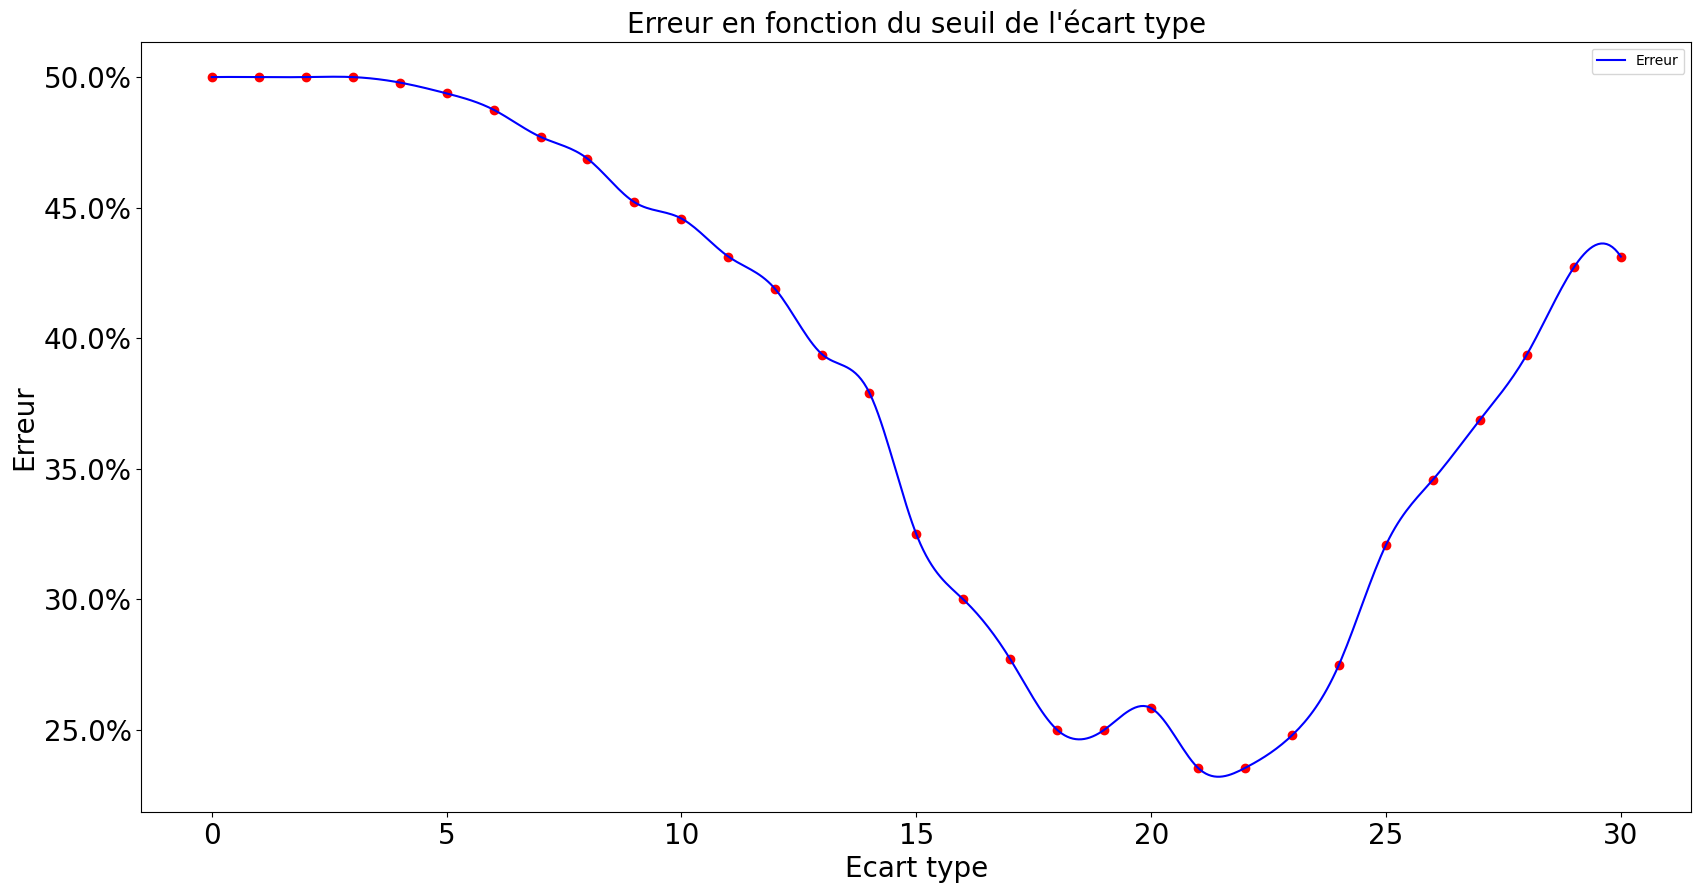

In [13]:
valeurs_caracteristique = []
erreur_caracteristique = []
for threshold_ecart_type in range(0,30+1,1):
    config = {'caracteristiques_a_utiliser': '7A', 'seuil_7A': threshold_ecart_type}
    erreur = train(config, False)['erreur']
    valeurs_caracteristique.append(threshold_ecart_type)
    erreur_caracteristique.append(erreur)

x_dense = np.linspace(min(valeurs_caracteristique), max(valeurs_caracteristique), 500)  # 500 points pour une courbe lisse
spline = make_interp_spline(valeurs_caracteristique, erreur_caracteristique)
y_dense = spline(x_dense)

plt.figure(figsize=(20, 10))
plt.plot(x_dense, y_dense, label='Erreur', color='b')
plt.scatter(valeurs_caracteristique, erreur_caracteristique, color='r')
plt.gca().tick_params(axis='y', which='major', labelsize=20) 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=20)
plt.xlabel("Ecart type", fontsize=20)
plt.ylabel('Erreur', fontsize=20)
plt.title("Erreur en fonction du seuil de l'écart type", fontsize=20)
plt.legend()


# On demande à l'étudiant de choisir le seuil pour l'écart type 

In [14]:
# l'étudiant devra remplacer le 10 ci dessous
seuil_ecart_type = 10

config = {'caracteristiques_a_utiliser': '7A', 'seuil_7A': seuil_ecart_type}
metrics = train(config, False)
print(f"Erreur obtenue: {round(100*metrics['erreur'],1)}%")


Erreur obtenue: 44.6%


<hr style="height:2px; border-width:0; color:black; background-color:black">
<span style="font-size: 48px;">3ème partie</span>
<hr style="height:2px; border-width:0; color:black; background-color:black">

# On combine les 2 caractéristiques précédentes

# PRIVE: Affichage de graphiques montrant les sujets sains et les sujets malades en fonction de 2 caractéristiques

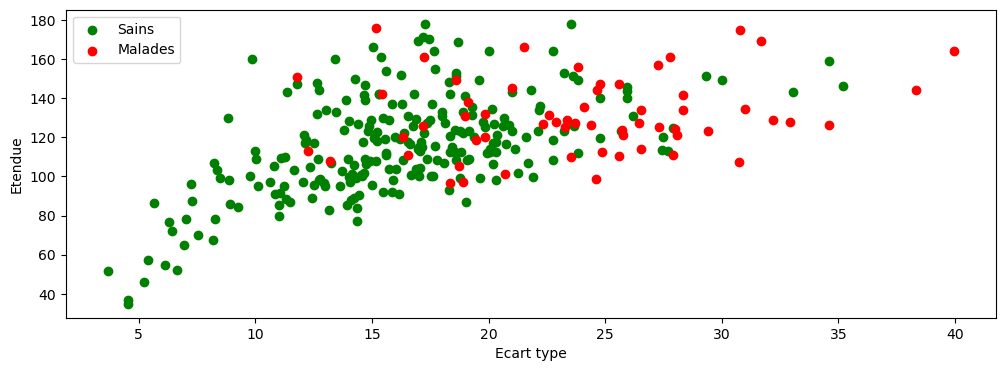

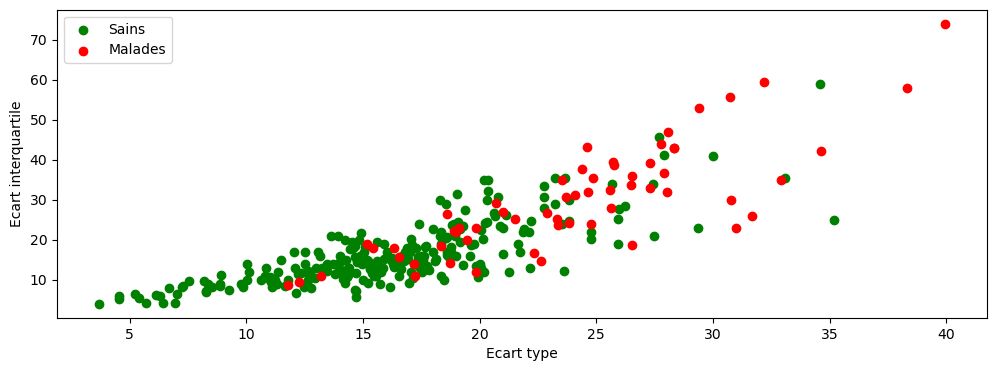

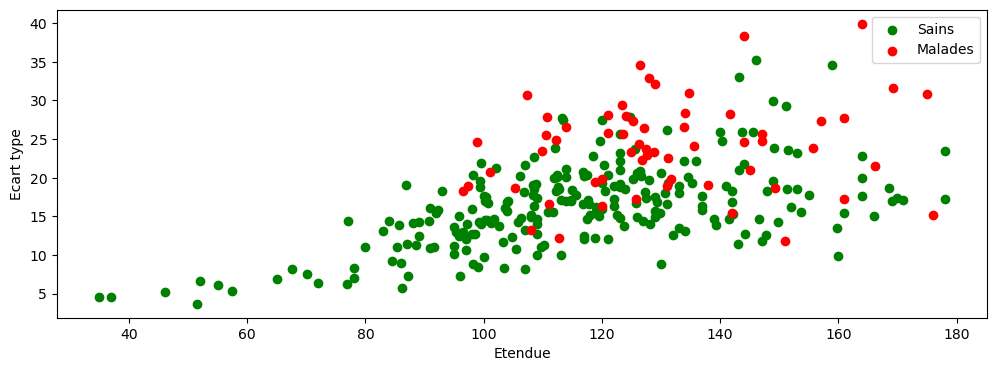

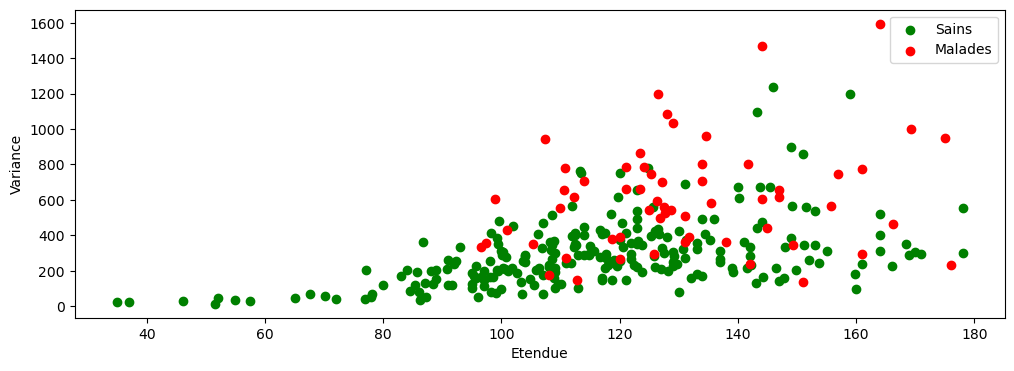

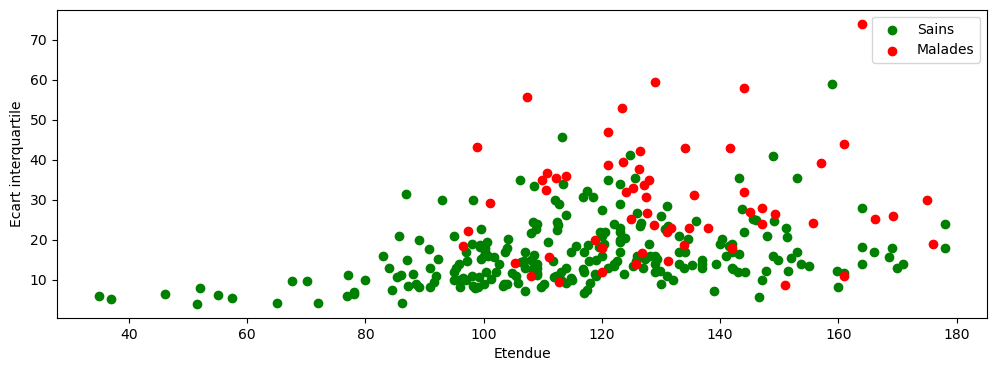

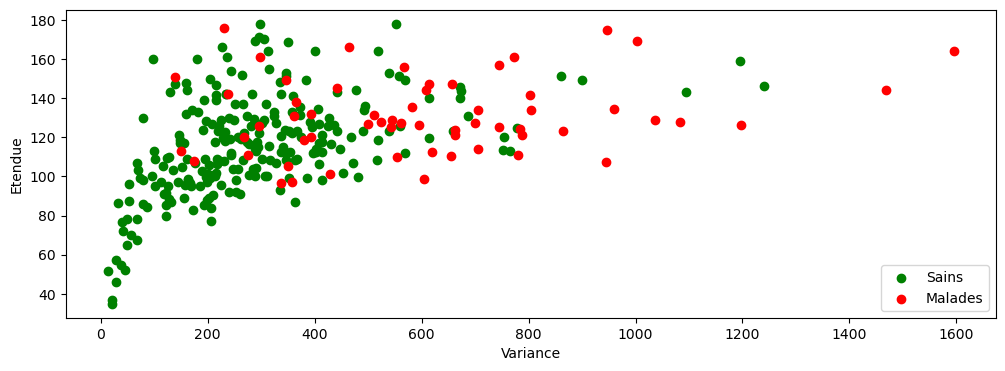

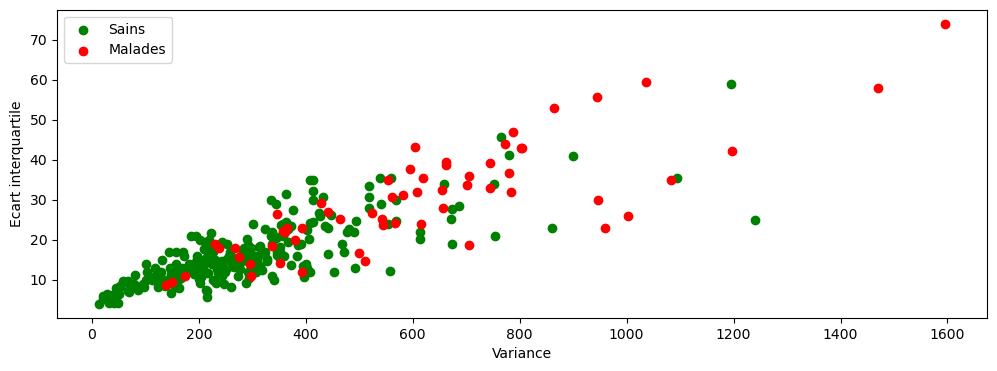

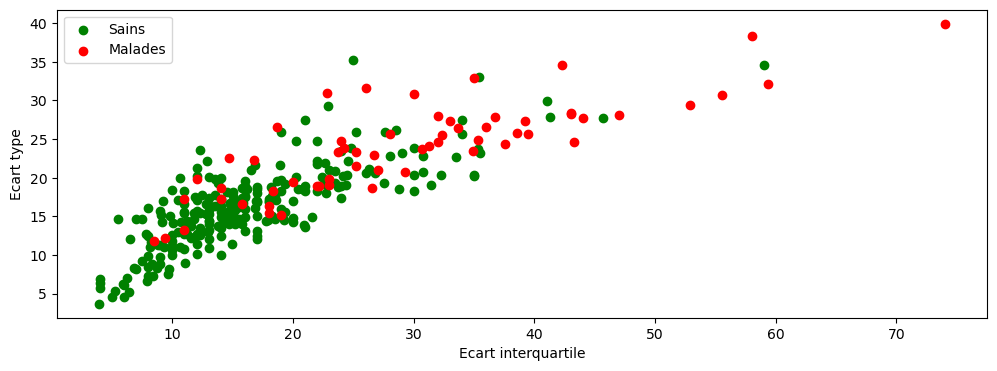

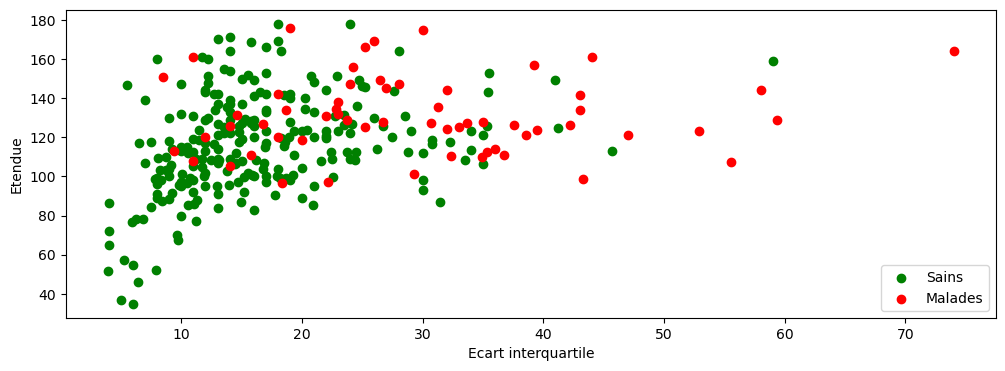

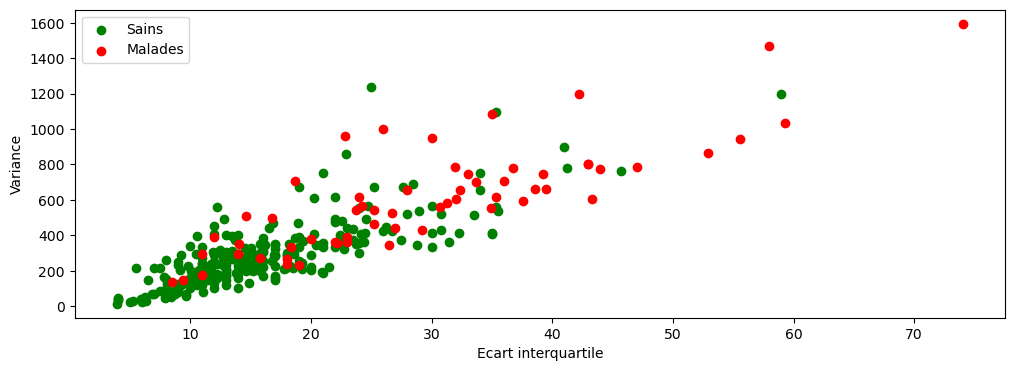

In [15]:

def display_plot(x_method, x_method_name:str, y_method, y_method_name:str):
    label0_coordinates = []
    label1_coordinates = []
    for id in id_to_fhr_last_hour.keys():
        x =x_method(id)
        y =y_method(id)
        if id_to_target[id] == 0:
            label0_coordinates.append((x,y))
        else:
            label1_coordinates.append((x,y))
    x_label0, y_label0 = zip(*label0_coordinates)
    plt.figure(figsize=(12, 4))
    plt.scatter(x_label0, y_label0, color='green', label='Sains')
    x_label1, y_label1 = zip(*label1_coordinates)
    plt.scatter(x_label1, y_label1, color='red', label='Malades')
    #plt.title('Sujets sains et malades')
    plt.xlabel(x_method_name)
    plt.ylabel(y_method_name)
    # Adding a legend to distinguish the series
    plt.legend()
    plt.show()
    
caracteristiques = [(compute_id_std_dev_last_hour, "Ecart type"), 
                    (compute_id_range_last_hour, "Etendue"),
                    (compute_id_variance_last_hour, "Variance"),
                    (compute_id_interquartile_range_last_hour, "Ecart interquartile")
                   ]

for (x_method, x_method_name) in caracteristiques:
    for (y_method, y_method_name) in caracteristiques:
        if x_method_name == y_method_name:
            continue
        if min(x_method_name,y_method_name) == "Ecart type" and max(x_method_name,y_method_name) == "Variance":
            continue
        display_plot(x_method, x_method_name, y_method, y_method_name)




# PRIVE: Affichage de graphiques montrant les sujets sains et les sujets malades en fonction de 2 caractéristiques en prenant toutes les données (pas seulement la dernière heure)

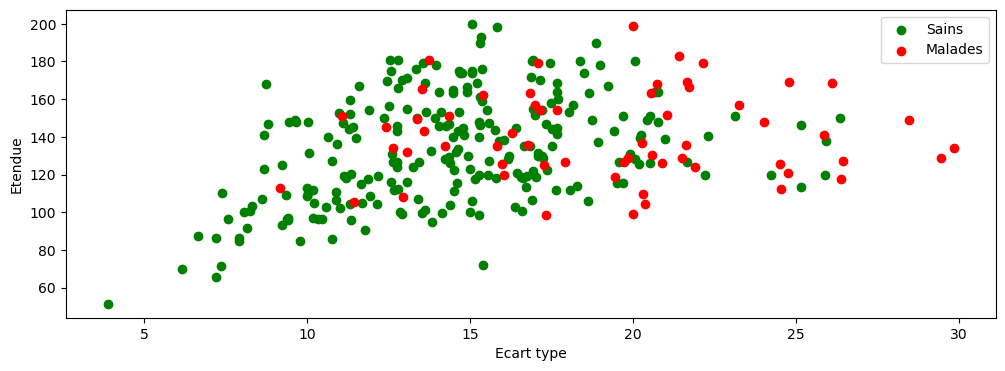

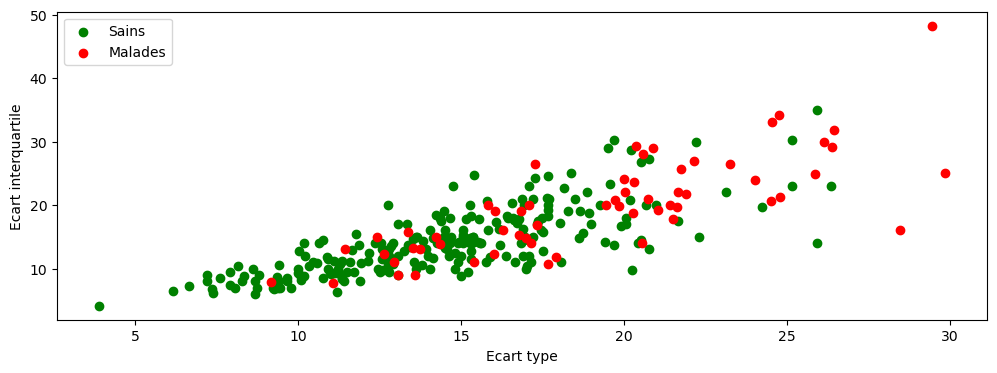

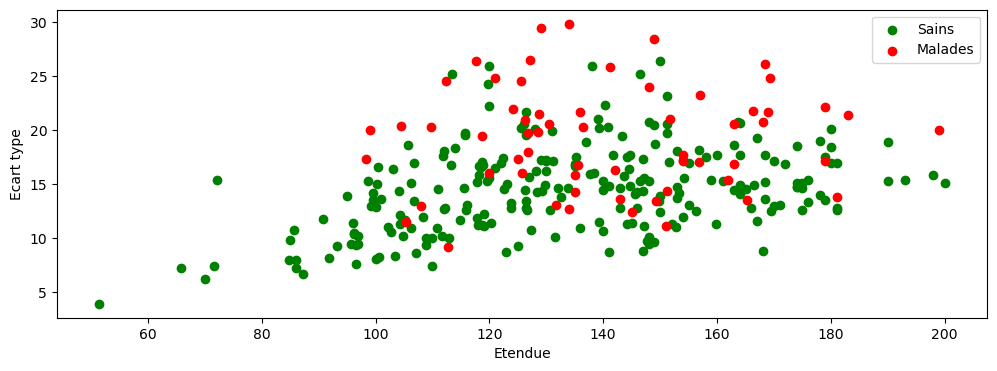

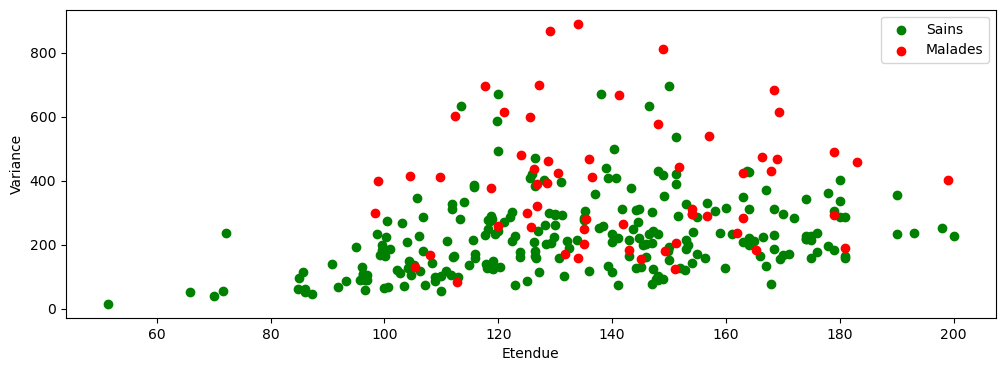

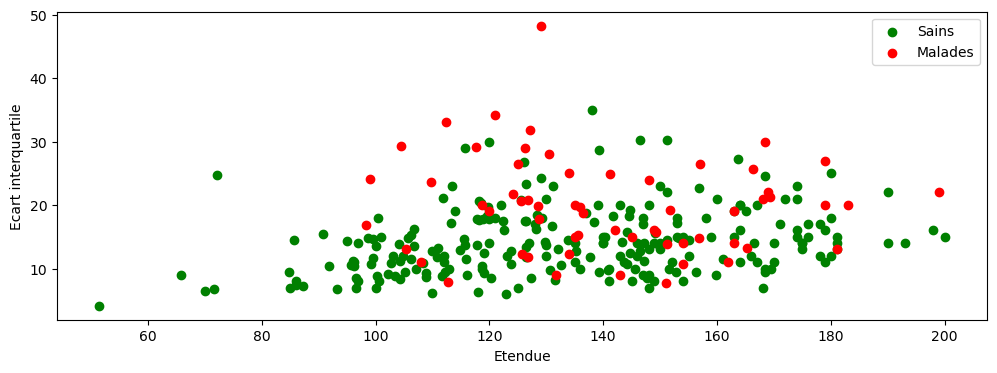

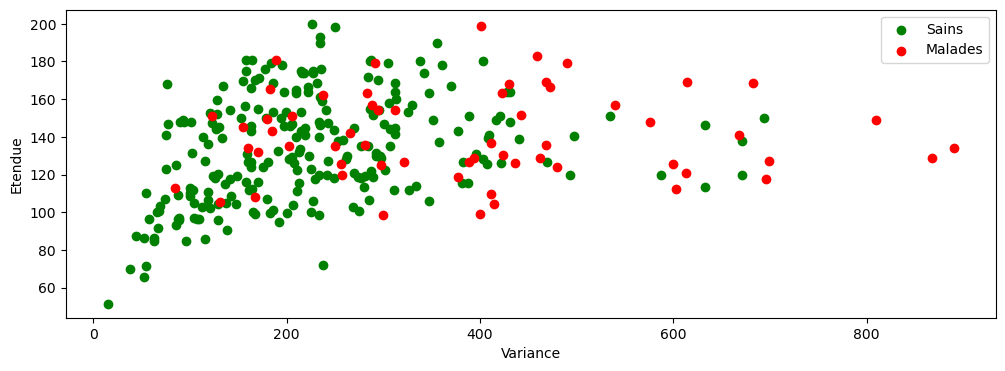

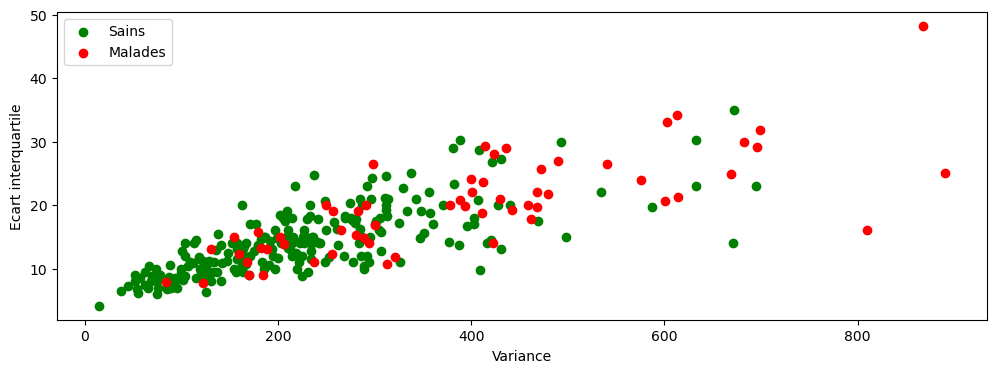

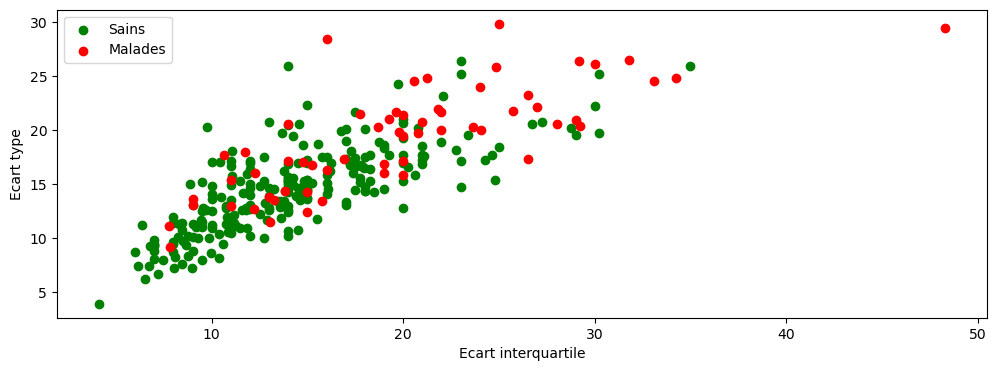

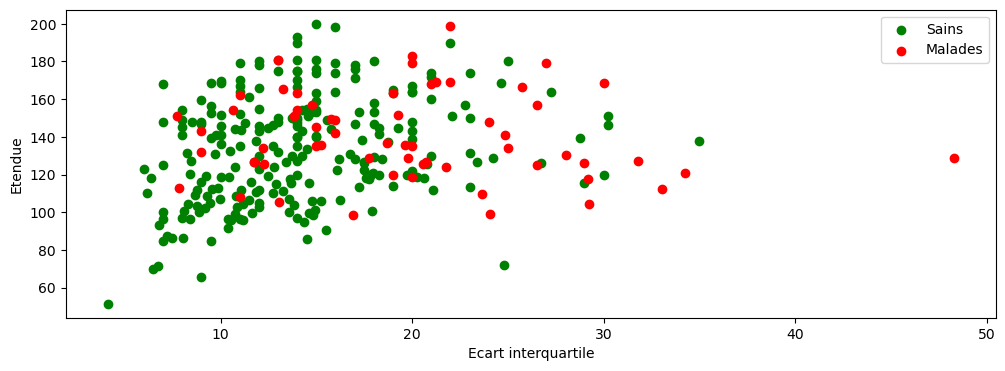

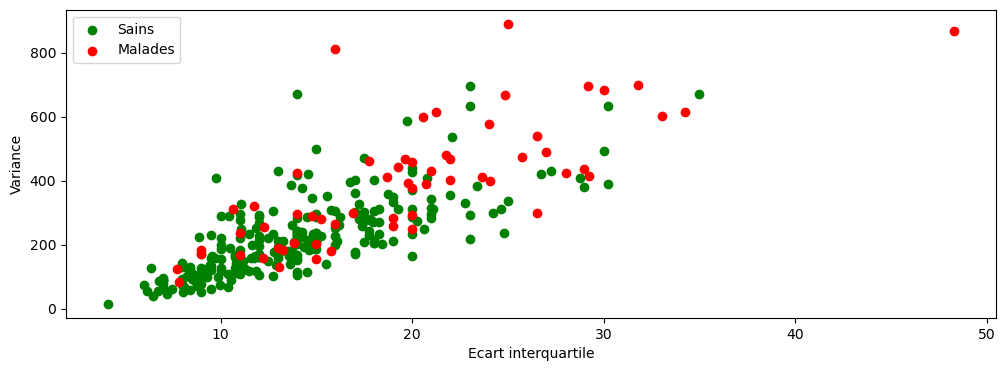

In [16]:

# calcul de l'écart type
@functools.lru_cache(maxsize=None)
def compute_id_std_dev_full(id: int):
    return ecart_type(id_to_fhr_full[id])

# calcul de la variance
@functools.lru_cache(maxsize=None)
def compute_id_variance_full(id: int) -> float:
    std_dev = compute_id_std_dev_full(id)
    return std_dev*std_dev

# calcul de l'etendue de la séquence associée à l'id 'id' en ignorant les NaN
@functools.lru_cache(maxsize=None)
def compute_id_range_full(id: int):
    data = id_to_fhr_full[id]
    return np.nanmax(data)-np.nanmin(data)

# calcul de l'écart interquartile (en ignorant les NaN)
@functools.lru_cache(maxsize=None)
def compute_id_interquartile_range_full(id: int) -> float:
    (Q1,Q2,Q3) = compute_quartiles_Q1_Q2_Q3(id_to_fhr_full[id])
    return Q3-Q1

caracteristiques = [(compute_id_std_dev_full, "Ecart type"), 
                    (compute_id_range_full, "Etendue"),
                    (compute_id_variance_full, "Variance"),
                    (compute_id_interquartile_range_full, "Ecart interquartile")
                   ]

for (x_method, x_method_name) in caracteristiques:
    for (y_method, y_method_name) in caracteristiques:
        if x_method_name == y_method_name:
            continue
        if min(x_method_name,y_method_name) == "Ecart type" and max(x_method_name,y_method_name) == "Variance":
            continue
        display_plot(x_method, x_method_name, y_method, y_method_name)



# On demande à l'étudiant de choisir la valeur de ces 2 caractéristiques

In [17]:
# l'étudiant devra remplacer les 2 valeurs ci dessous

seuil_ecart_type = 10
seuil_etendue = 100

config = {'caracteristiques_a_utiliser': '7A+3', 'seuil_7A': seuil_ecart_type, 'seuil_3': seuil_etendue,'label_si_resultats_differents': 1}
metrics = train(config, False)
print(f"Erreur obtenue: {round(100*metrics['erreur'],1)}%")


Erreur obtenue: 45.6%
